In [1]:
import zipfile
import os

zip_path = "/content/arrhythmia.zip"  # Replace with the actual path
extract_path = "/content/ecg_data"  # Change if needed

# Check if file exists
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"⚠️ ZIP file not found at {zip_path}")

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Files extracted successfully!")


✅ Files extracted successfully!


In [2]:
import pandas as pd

# File paths
data_file = "ecg_data/arrhythmia.data"
csv_file = "ecg_data/arrhythmia.csv"

# Load data (handling missing values marked as '?')
df = pd.read_csv(data_file, header=None, na_values="?")

# Create column names (1 to 279 + Class)
column_names = [f"Feature_{i}" for i in range(1, 280)] + ["Class"]
df.columns = column_names  # Assign column names

# Save as CSV
df.to_csv(csv_file, index=False)

print("✅ Conversion complete! File saved as:", csv_file)


✅ Conversion complete! File saved as: ecg_data/arrhythmia.csv


In [ ]:
import pandas as pd

# Define actual feature names
column_names = [
    "Age", "Sex", "Height", "Weight", "QRS_duration", "P-R_interval", "Q-T_interval", "T_interval", "P_interval",
    "QRS_angle", "T_angle", "P_angle", "QRST_angle", "J_angle", "Heart_rate"
]

# Features from different ECG channels
channels = ["DI", "DII", "DIII", "AVR", "AVL", "AVF", "V1", "V2", "V3", "V4", "V5", "V6"]
metrics = ["Q_wave", "R_wave", "S_wave", "R'_wave", "S'_wave", "Num_intrinsic_deflections",
           "Ragged_R", "Diphasic_R", "Ragged_P", "Diphasic_P", "Ragged_T", "Diphasic_T"]

# Track used feature names to avoid duplicates
used_names = set()

# Generate unique feature names
for channel in channels:
    for metric in metrics:
        unique_name = f"{channel}_{metric}"
        counter = 1
        while unique_name in used_names:
            unique_name = f"{channel}_{metric}_{counter}"
            counter += 1
        column_names.append(unique_name)
        used_names.add(unique_name)

# Add Amplitude and QRSA features
amplitude_metrics = ["JJ_wave", "Q_wave", "R_wave", "S_wave", "R'_wave", "S'_wave", "P_wave", "T_wave", "QRSA", "QRSTA"]
for channel in channels:
    for metric in amplitude_metrics:
        unique_name = f"{channel}_{metric}"
        counter = 1
        while unique_name in used_names:
            unique_name = f"{channel}_{metric}_{counter}"
            counter += 1
        column_names.append(unique_name)
        used_names.add(unique_name)

# Add target variable (Class)
column_names.append("Class")

# File paths
data_file = "ecg_data/arrhythmia.data"
csv_file = "ecg_data/arrhythmia.csv"

# Load the .data file with unique column names
df = pd.read_csv(data_file, header=None, na_values="?", names=column_names)

# Save as CSV
df.to_csv(csv_file, index=False)

print("✅ Conversion complete! File saved as:", csv_file)


✅ Conversion complete! File saved as: ecg_data/arrhythmia.csv


In [ ]:
#OUR STACKED MODEL- RF, SVM, LOGISTIC REGRESSION, XGBOOST

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

# Step 1: Load the dataset
csv_file = "ecg_data/arrhythmia.csv"
df = pd.read_csv(csv_file)

# Step 2: Handle Missing Values (Replace NaN with median)
df.fillna(df.median(), inplace=True)

# Step 3: Encode the target variable
label_encoder = LabelEncoder()
df["Class"] = label_encoder.fit_transform(df["Class"])

# Step 4: Split Features and Target Variable
X = df.drop(columns=["Class"])  # Features
y = df["Class"]  # Target variable

# Step 5: Handle Class Imbalance using SMOTE (Adjust k_neighbors)
smote = SMOTE(k_neighbors=1, random_state=42)  # Set k_neighbors=1 to avoid errors
X_resampled, y_resampled = smote.fit_resample(X, y)


# Step 6: Split Data into Train & Test Sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 7: Define Base Models
base_models = [
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("svm", SVC(kernel="rbf", probability=True)),
    ("lr", LogisticRegression(max_iter=1000))
]

# Step 8: Define Stacking Classifier (Hybrid Model)
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
)

# Step 9: Train the Hybrid Model
stacked_model.fit(X_train, y_train)

# Step 10: Make Predictions
y_pred = stacked_model.predict(X_test)

# Step 11: Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Hybrid Model Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

✅ Hybrid Model Accuracy: 0.9906

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95        49
           1       0.98      0.96      0.97        49
           2       0.98      1.00      0.99        49
           3       1.00      1.00      1.00        49
           4       1.00      0.98      0.99        49
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        49
           7       1.00      1.00      1.00        49
           8       1.00      1.00      1.00        49
           9       0.98      1.00      0.99        49
          10       1.00      1.00      1.00        49
          11       1.00      0.98      0.99        49
          12       1.00      1.00      1.00        49

    accuracy                           0.99       637
   macro avg       0.99      0.99      0.99       637
weighted avg       0.99      0.99      0.99       637



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

✅ Hybrid Model Accuracy: 0.9922

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96        49
           1       1.00      0.96      0.98        49
           2       0.98      1.00      0.99        49
           3       1.00      1.00      1.00        49
           4       1.00      0.98      0.99        49
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        49
           7       1.00      1.00      1.00        49
           8       1.00      1.00      1.00        49
           9       0.98      1.00      0.99        49
          10       1.00      1.00      1.00        49
          11       1.00      0.98      0.99        49
          12       1.00      1.00      1.00        49

    accuracy                           0.99       637
   macro avg       0.99      0.99      0.99       637
weighted avg       0.99      0.99      0.99       637



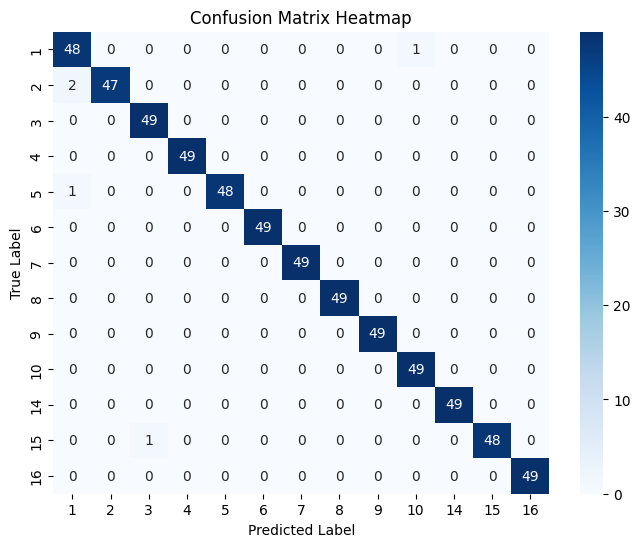

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

# Step 1: Load the dataset
csv_file = "ecg_data/arrhythmia.csv"
df = pd.read_csv(csv_file)

# Step 2: Handle Missing Values (Replace NaN with median)
df.fillna(df.median(), inplace=True)

# Step 3: Encode the target variable
label_encoder = LabelEncoder()
df["Class"] = label_encoder.fit_transform(df["Class"])

# Step 4: Split Features and Target Variable
X = df.drop(columns=["Class"])  # Features
y = df["Class"]  # Target variable

# Step 5: Handle Class Imbalance using SMOTE (Adjust k_neighbors)
smote = SMOTE(k_neighbors=1, random_state=42)  # Set k_neighbors=1 to avoid errors
X_resampled, y_resampled = smote.fit_resample(X, y)


# Step 6: Split Data into Train & Test Sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 7: Define Base Models
base_models = [
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("svm", SVC(kernel="rbf", probability=True)),
    ("lr", LogisticRegression(max_iter=1000))
]

# Step 8: Define Stacking Classifier (Hybrid Model)
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
)

# Step 9: Train the Hybrid Model
stacked_model.fit(X_train, y_train)

# Step 10: Make Predictions
y_pred = stacked_model.predict(X_test)

# Step 11: Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Hybrid Model Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Step 1: Load the dataset
csv_file = "ecg_data/arrhythmia.csv"
df = pd.read_csv(csv_file)

# Step 2: Handle Missing Values (Replace NaN with median)
df.fillna(df.median(), inplace=True)

# Step 3: Encode the target variable
label_encoder = LabelEncoder()
df["Class"] = label_encoder.fit_transform(df["Class"])

# Step 4: Split Features and Target Variable
X = df.drop(columns=["Class"])  # Features
y = df["Class"]  # Target variable

# Step 5: Perform Feature Selection (Keep top 20 best features)
selector = SelectKBest(score_func=f_classif, k=20)  # Select top 20 features
X_selected = selector.fit_transform(X, y)

# Step 6: Handle Class Imbalance using SMOTE (Adjust k_neighbors)
smote = SMOTE(k_neighbors=1, random_state=42)  # Set k_neighbors=1 to avoid errors
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Step 7: Split Data into Train & Test Sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 8: Further Split Train Set into Train & Validation (80-20 split)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Step 9: Define Base Models
base_models = [
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("svm", SVC(kernel="rbf", probability=True)),
    ("lr", LogisticRegression(max_iter=1000))
]

# Step 10: Define Stacking Model WITHOUT XGBoost (Only Base Models)
stacked_model = StackingClassifier(
    estimators=base_models, final_estimator=None  # We will manually train XGBoost
)

# Step 11: Train the Stacking Model (Without XGBoost)
stacked_model.fit(X_train_sub, y_train_sub)

# Step 12: Extract Meta-Features from Base Models
X_train_meta = stacked_model.transform(X_train_sub)
X_val_meta = stacked_model.transform(X_val)
X_test_meta = stacked_model.transform(X_test)

# Step 13: Train XGBoost Separately with Early Stopping
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
    early_stopping_rounds=10,  # Stop training if no improvement after 10 rounds
    n_estimators=1000
)

xgb_model.fit(
    X_train_meta, y_train_sub,
    eval_set=[(X_val_meta, y_val)],  # Pass Validation Set
    verbose=True
)

# Step 14: Make Predictions
y_pred = xgb_model.predict(X_test_meta)

# Step 15: Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Hybrid Model Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 19  67  69  83 131 132 139 141 143 145 151 156 157 164 204 264 274] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/s

[0]	validation_0-mlogloss:1.16391
[1]	validation_0-mlogloss:0.90917
[2]	validation_0-mlogloss:0.74756
[3]	validation_0-mlogloss:0.63720
[4]	validation_0-mlogloss:0.55931
[5]	validation_0-mlogloss:0.50339
[6]	validation_0-mlogloss:0.46287
[7]	validation_0-mlogloss:0.43336
[8]	validation_0-mlogloss:0.41182
[9]	validation_0-mlogloss:0.39609


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:57:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-mlogloss:0.38460
[11]	validation_0-mlogloss:0.37624
[12]	validation_0-mlogloss:0.37018
[13]	validation_0-mlogloss:0.36580
[14]	validation_0-mlogloss:0.36265
[15]	validation_0-mlogloss:0.36041
[16]	validation_0-mlogloss:0.35883
[17]	validation_0-mlogloss:0.35773
[18]	validation_0-mlogloss:0.35698
[19]	validation_0-mlogloss:0.35647
[20]	validation_0-mlogloss:0.35613
[21]	validation_0-mlogloss:0.35593
[22]	validation_0-mlogloss:0.35581
[23]	validation_0-mlogloss:0.35580
[24]	validation_0-mlogloss:0.35580
[25]	validation_0-mlogloss:0.35580
[26]	validation_0-mlogloss:0.35579
[27]	validation_0-mlogloss:0.35579
[28]	validation_0-mlogloss:0.35579
[29]	validation_0-mlogloss:0.35578
[30]	validation_0-mlogloss:0.35578
[31]	validation_0-mlogloss:0.35578
[32]	validation_0-mlogloss:0.35578
[33]	validation_0-mlogloss:0.35578
[34]	validation_0-mlogloss:0.35577
[35]	validation_0-mlogloss:0.35577
[36]	validation_0-mlogloss:0.35577
[37]	validation_0-mlogloss:0.35577
[38]	validation_0-ml

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[0]	validation_0-mlogloss:1.12349
[1]	validation_0-mlogloss:0.86171
[2]	validation_0-mlogloss:0.69583
[3]	validation_0-mlogloss:0.58272
[4]	validation_0-mlogloss:0.50305
[5]	validation_0-mlogloss:0.44601
[6]	validation_0-mlogloss:0.40483
[7]	validation_0-mlogloss:0.37499
[8]	validation_0-mlogloss:0.35335
[9]	validation_0-mlogloss:0.33768
[10]	validation_0-mlogloss:0.32639
[11]	validation_0-mlogloss:0.31831
[12]	validation_0-mlogloss:0.31257
[13]	validation_0-mlogloss:0.30856
[14]	validation_0-mlogloss:0.30581
[15]	validation_0-mlogloss:0.30397
[16]	validation_0-mlogloss:0.30278
[17]	validation_0-mlogloss:0.30207
[18]	validation_0-mlogloss:0.30168
[19]	validation_0-mlogloss:0.30153
[20]	validation_0-mlogloss:0.30153
[21]	validation_0-mlogloss:0.30163
[22]	validation_0-mlogloss:0.30180
[23]	validation_0-mlogloss:0.30180
[24]	validation_0-mlogloss:0.30179
[25]	validation_0-mlogloss:0.30179
[26]	validation_0-mlogloss:0.30179
[27]	validation_0-mlogloss:0.30178
[28]	validation_0-mlogloss:0.3

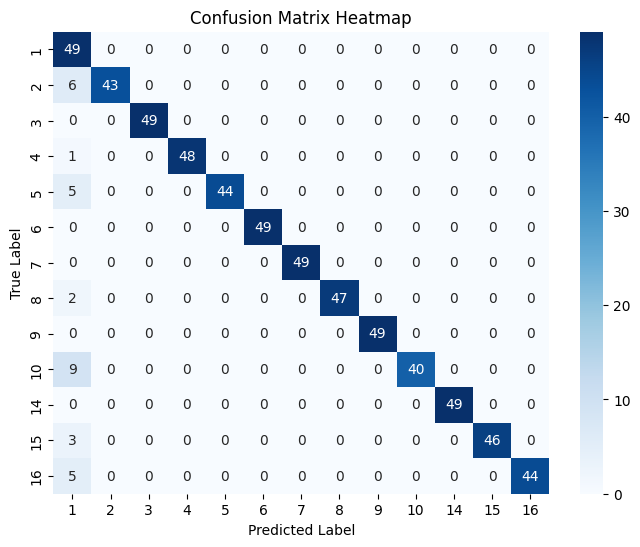

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE

# Step 1: Load the dataset
csv_file = "ecg_data/arrhythmia.csv"
df = pd.read_csv(csv_file)

# Step 2: Handle Missing Values (Replace NaN with median)
df.fillna(df.median(), inplace=True)

# Step 3: Encode the target variable
label_encoder = LabelEncoder()
df["Class"] = label_encoder.fit_transform(df["Class"])

# Step 4: Split Features and Target Variable
X = df.drop(columns=["Class"])  # Features
y = df["Class"]  # Target variable

# Step 5: Feature Selection BEFORE SMOTE
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=50)  # Selecting 50 best features
X_selected = rfe.fit_transform(X, y)

# Step 6: Handle Class Imbalance using SMOTE (After Feature Selection)
smote = SMOTE(k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Step 7: Split Data into Train & Test Sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 8: Further Split Train Set into Train & Validation (80-20 split)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Step 9: Define Base Models
base_models = [
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("svm", SVC(kernel="rbf", probability=True)),
    ("lr", LogisticRegression(max_iter=1000))
]

# Step 10: Define Stacking Model (Use Logistic Regression as Final Estimator)
stacked_model = StackingClassifier(
    estimators=base_models, final_estimator=LogisticRegression(max_iter=1000)
)

# Step 11: Train the Stacking Model
stacked_model.fit(X_train_sub, y_train_sub)

# Step 12: Extract Meta-Features from Base Models
X_train_meta = stacked_model.transform(X_train_sub)
X_val_meta = stacked_model.transform(X_val)
X_test_meta = stacked_model.transform(X_test)

# Step 13: Train XGBoost Separately with Early Stopping
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
    early_stopping_rounds=10,  # Stop training if no improvement after 10 rounds
    n_estimators=1000
)

xgb_model.fit(
    X_train_meta, y_train_sub,
    eval_set=[(X_val_meta, y_val)],  # Pass Validation Set
    verbose=True
)

# Step 14: Make Predictions
y_pred = xgb_model.predict(X_test_meta)

# Step 15: Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Hybrid Model Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[0]	validation_0-mlogloss:2.50546	validation_1-mlogloss:2.51244
[1]	validation_0-mlogloss:2.44950	validation_1-mlogloss:2.46161
[2]	validation_0-mlogloss:2.39610	validation_1-mlogloss:2.41391
[3]	validation_0-mlogloss:2.34656	validation_1-mlogloss:2.36665
[4]	validation_0-mlogloss:2.29854	validation_1-mlogloss:2.32288
[5]	validation_0-mlogloss:2.25232	validation_1-mlogloss:2.28099
[6]	validation_0-mlogloss:2.20820	validation_1-mlogloss:2.24041
[7]	validation_0-mlogloss:2.16579	validation_1-mlogloss:2.20186
[8]	validation_0-mlogloss:2.12515	validation_1-mlogloss:2.16493
[9]	validation_0-mlogloss:2.08664	validation_1-mlogloss:2.12906
[10]	validation_0-mlogloss:2.04942	validation_1-mlogloss:2.09404
[11]	validation_0-mlogloss:2.01326	validation_1-mlogloss:2.06187


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:56:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-mlogloss:1.97919	validation_1-mlogloss:2.02972
[13]	validation_0-mlogloss:1.94529	validation_1-mlogloss:1.99904
[14]	validation_0-mlogloss:1.91328	validation_1-mlogloss:1.97015
[15]	validation_0-mlogloss:1.88175	validation_1-mlogloss:1.94055
[16]	validation_0-mlogloss:1.85130	validation_1-mlogloss:1.91260
[17]	validation_0-mlogloss:1.82154	validation_1-mlogloss:1.88559
[18]	validation_0-mlogloss:1.79305	validation_1-mlogloss:1.85992
[19]	validation_0-mlogloss:1.76513	validation_1-mlogloss:1.83495
[20]	validation_0-mlogloss:1.73845	validation_1-mlogloss:1.81022
[21]	validation_0-mlogloss:1.71198	validation_1-mlogloss:1.78653
[22]	validation_0-mlogloss:1.68656	validation_1-mlogloss:1.76327
[23]	validation_0-mlogloss:1.66152	validation_1-mlogloss:1.73957
[24]	validation_0-mlogloss:1.63706	validation_1-mlogloss:1.71767
[25]	validation_0-mlogloss:1.61330	validation_1-mlogloss:1.69458
[26]	validation_0-mlogloss:1.59031	validation_1-mlogloss:1.67381
[27]	validation_0-mloglos

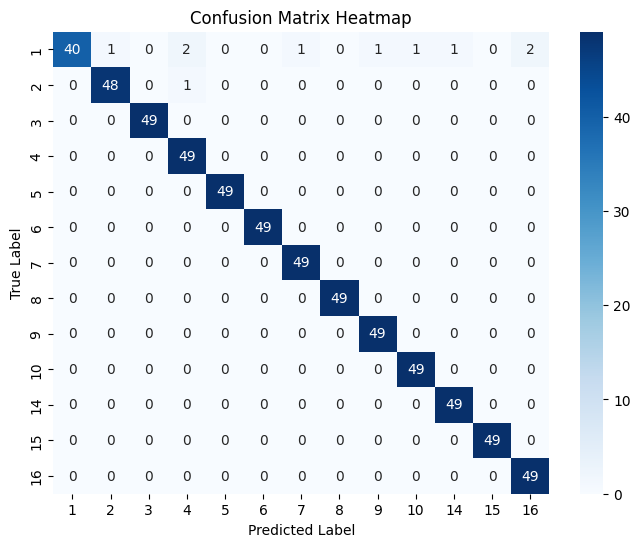

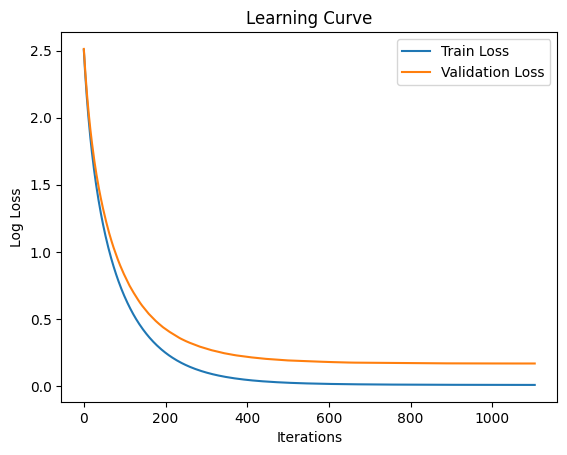

Model saved as trained_model.pkl


In [ ]:
#TUNE HYPERPARAMETERS OF XGBOOST

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE


csv_file = "ecg_data/arrhythmia.csv"
df = pd.read_csv(csv_file)


df.fillna(df.median(), inplace=True)


label_encoder = LabelEncoder()
df["Class"] = label_encoder.fit_transform(df["Class"])


X = df.drop(columns=["Class"])  # Features
y = df["Class"]  # Target variable


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=50)  # Selecting 50 best features
X_selected = rfe.fit_transform(X, y)

# Step 6: Handle Class Imbalance using SMOTE
smote = SMOTE(k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Step 7: Split Data into Train & Test Sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 8: Further Split Train Set into Train & Validation (80-20 split)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Step 9: Define Base Models
base_models = [
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("svm", SVC(kernel="rbf", probability=True)),
    ("lr", LogisticRegression(max_iter=1000))
]


stacked_model = StackingClassifier(
    estimators=base_models, final_estimator=LogisticRegression(max_iter=1000)
)


stacked_model.fit(X_train_sub, y_train_sub)


X_train_meta = stacked_model.transform(X_train_sub)
X_val_meta = stacked_model.transform(X_val)
X_test_meta = stacked_model.transform(X_test)

# Step 13: Train XGBoost Separately with Early Stopping
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
    early_stopping_rounds=20,
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.5,
    reg_alpha=1.0
)


xgb_model.fit(
    X_train_meta, y_train_sub,
    eval_set=[(X_train_meta, y_train_sub), (X_val_meta, y_val)],  # Added training set here
    verbose=True
)

y_pred = xgb_model.predict(X_test_meta)


accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Hybrid Model Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


results = xgb_model.evals_result()
plt.plot(results["validation_0"]["mlogloss"], label="Train Loss")  # Training loss
plt.plot(results["validation_1"]["mlogloss"], label="Validation Loss")  # Validation loss
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()


import joblib

joblib.dump(xgb_model, "trained_model.pkl")  # Saves the model to a file
print("Model saved as trained_model.pkl")

In [ ]:
import joblib

# Save the RFE object
joblib.dump(rfe, "rfe_selector.pkl")
print("RFE selector saved as rfe_selector.pkl")


RFE selector saved as rfe_selector.pkl


In [ ]:
import pandas as pd

# Load your training dataset
train_data = pd.read_csv('/content/ecg_data/arrhythmia.csv')  # Update the path as needed

# Display column names (features used for training)
train_data.columns
# Example RFE-selected feature indices (replace with actual RFE indices)
selected_feature_indices = [ 2, 4, 5, 6, 7, 8, 12, 14, 75, 89, 90, 92, 111, 112, 113, 116, 166, 167, 168,
                            170, 176, 178, 180, 196, 206, 210, 223, 225, 227, 229, 232, 233, 236, 237,
                            238, 239, 241, 242, 246, 247, 248, 249, 251, 256, 258, 259, 266, 269, 276, 278 ]

# Get the feature names from the training dataset
feature_names = train_data.columns.tolist()

# Map the selected feature indices to the actual feature names
selected_feature_names = [feature_names[i] for i in selected_feature_indices]

print("Features selected by RFE:")
print(selected_feature_names)


Features selected by RFE:
['Height', 'QRS_duration', 'P-R_interval', 'Q-T_interval', 'T_interval', 'P_interval', 'QRST_angle', 'Heart_rate', 'AVF_Q_wave', 'V1_S_wave', "V1_R'_wave", 'V1_Num_intrinsic_deflections', 'V3_Q_wave', 'V3_R_wave', 'V3_S_wave', 'V3_Num_intrinsic_deflections', 'DI_T_wave', 'DI_QRSA', 'DI_QRSTA', 'DII_Q_wave_1', 'DII_T_wave', 'DII_QRSTA', 'DIII_Q_wave_1', 'AVR_T_wave', 'AVL_T_wave', 'AVF_Q_wave_1', "V1_R'_wave_1", 'V1_P_wave', 'V1_QRSA', 'V2_JJ_wave', 'V2_S_wave_1', "V2_R'_wave_1", 'V2_T_wave', 'V2_QRSA', 'V2_QRSTA', 'V3_JJ_wave', 'V3_R_wave_1', 'V3_S_wave_1', 'V3_T_wave', 'V3_QRSA', 'V3_QRSTA', 'V4_JJ_wave', 'V4_R_wave_1', 'V4_T_wave', 'V4_QRSTA', 'V5_JJ_wave', 'V5_T_wave', 'V6_JJ_wave', 'V6_T_wave', 'V6_QRSTA']


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.signal as signal
from scipy.interpolate import interp1d
from math import atan2, pi

# Helper functions to extract QRS duration, PR interval, QRST angle, etc.

def get_qrs_duration(ecg_signal, threshold=0.6):
    qrs_points = signal.find_peaks(ecg_signal, height=threshold)[0]
    if len(qrs_points) >= 2:
        qrs_duration = qrs_points[-1] - qrs_points[0]
    else:
        qrs_duration = 0
    return qrs_duration

def get_pr_interval(ecg_signal):
    p_peak = np.argmax(ecg_signal[:100])  # Approximation for P wave peak
    r_peak = np.argmax(ecg_signal[100:])  # Approximation for R wave peak
    pr_interval = r_peak - p_peak
    return pr_interval

def get_heart_rate(ecg_signal, sampling_rate=360):
    r_peaks, _ = signal.find_peaks(ecg_signal, height=0.5)  # Detect R-peaks
    rr_intervals = np.diff(r_peaks)  # RR intervals in samples
    heart_rate = 60 / (np.mean(rr_intervals) / sampling_rate)  # bpm (beats per minute)
    return heart_rate

def get_qrs_angle(ecg_signal):
    # QRST angle: Calculating the angle between QRS complex and T wave
    qrs_points = signal.find_peaks(ecg_signal, height=0.6)[0]
    q_peak = qrs_points[0] if len(qrs_points) > 0 else 0
    t_peak = np.argmax(ecg_signal[::-1])  # Simplified T-wave peak detection
    t_peak = len(ecg_signal) - t_peak
    angle = atan2(t_peak - q_peak, len(ecg_signal)) * (180 / pi)  # Simple method to calculate angle
    return angle

def get_avf_q_wave(ecg_signal):
    avf_q_wave = np.min(ecg_signal)  # Simple method: minimum value of the signal
    return avf_q_wave

def extract_wave_metrics(ecg_signal, wave='R'):
    if wave == 'R':
        peak = np.argmax(ecg_signal)  # Simple method to find R peak
        return peak
    elif wave == 'T':
        peak = np.argmax(ecg_signal[::-1])  # T wave peak detection (reverse for T)
        return len(ecg_signal) - peak
    else:
        return 0

def extract_features(ecg_signal, lead='MLII'):
    try:
        ecg_signal = np.array(ecg_signal).flatten()

        if len(ecg_signal) < 10:
            print(f"⚠️ Signal too short to extract features.")
            return None

        features = []

        # Statistical Features
        features.append(np.mean(ecg_signal))  # Mean
        features.append(np.std(ecg_signal))   # Std dev
        features.append(np.min(ecg_signal))   # Min
        features.append(np.max(ecg_signal))   # Max
        features.append(np.median(ecg_signal))  # Median
        features.append(stats.skew(ecg_signal))  # Skewness
        features.append(stats.kurtosis(ecg_signal))  # Kurtosis

        # Signal Duration and Heart Rate
        features.append(get_qrs_duration(ecg_signal))  # QRS duration
        features.append(get_pr_interval(ecg_signal))   # PR Interval
        features.append(get_heart_rate(ecg_signal))    # Heart rate (bpm)
        features.append(get_qrs_angle(ecg_signal))    # QRST Angle (placeholder)

        # Wave Metrics
        features.append(extract_wave_metrics(ecg_signal, 'R'))  # R wave peak position
        features.append(extract_wave_metrics(ecg_signal, 'T'))  # T wave peak position
        features.append(extract_wave_metrics(ecg_signal, 'P'))  # P wave peak (not implemented)
        features.append(extract_wave_metrics(ecg_signal, 'Q'))  # Q wave peak (not implemented)

        # AVF Q wave (new feature based on a simple method)
        features.append(get_avf_q_wave(ecg_signal))  # AVF Q-wave (new feature)

        # Additional advanced wave features
        features.append(np.mean(np.diff(ecg_signal)))  # Average signal change (first derivative)
        features.append(np.max(np.diff(ecg_signal)))  # Maximum rate of change
        features.append(np.min(np.diff(ecg_signal)))  # Minimum rate of change
        features.append(np.mean(ecg_signal[:int(len(ecg_signal)/3)]))  # First third mean
        features.append(np.mean(ecg_signal[int(len(ecg_signal)/3):2*int(len(ecg_signal)/3)]))  # Second third mean
        features.append(np.mean(ecg_signal[2*int(len(ecg_signal)/3):]))  # Last third mean

        # Placeholder for any additional complex features you need to implement
        # Features can be customized based on your own domain-specific methods

        # Ensure we have the expected number of features
        while len(features) < 39:
            features.append(0.0)  # Padding if not enough features

        return features

    except Exception as e:
        print(f"❌ Error in extract_features: {e}")
        return None


# Main function to process the ECG file and extract features
def process_ecg_file(file_path):
    ecg_data = pd.read_csv(file_path)
    ecg_data.columns = ecg_data.columns.str.replace("''", "").str.replace("'", "").str.strip()  # Clean up columns
    print("✅ Data Loaded")

    # Extract features from MLII and V5 (you can customize this to other leads if needed)
    features_list = []
    for lead in ['MLII', 'V5']:
        if lead in ecg_data.columns:
            ecg_signal = ecg_data[lead].dropna().values
            extracted_features = extract_features(ecg_signal, lead)
            if extracted_features is not None:
                features_list.append(extracted_features)

    # Create a DataFrame with all extracted features
    if len(features_list) > 0:
        features_df = pd.DataFrame(features_list, columns=[f"Feature_{i}" for i in range(1, 40)])
        print("✅ Features extracted successfully!")
        return features_df
    else:
        print("❌ No valid ECG signal found for feature extraction.")
        return None


# Example usage
file_path = '/content/100.csv'  # Replace with actual file path
features_df = process_ecg_file(file_path)
if features_df is not None:
    print(features_df.head())


✅ Data Loaded
✅ Features extracted successfully!
    Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0  962.740205  38.639908        481       1311      957.0   4.426138   
1  985.793114  29.642645        531       1269      983.0   2.710229   

   Feature_7  Feature_8  Feature_9   Feature_10  ...  Feature_30  Feature_31  \
0  25.413106     649983     448961  3823.665542  ...         0.0         0.0   
1  16.164638     649970     130391  3954.943151  ...         0.0         0.0   

   Feature_32  Feature_33  Feature_34  Feature_35  Feature_36  Feature_37  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   

   Feature_38  Feature_39  
0         0.0         0.0  
1         0.0         0.0  

[2 rows x 39 columns]


In [ ]:
with open('extract_features.py', 'w') as f:
    f.write("""

import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.signal as signal
from scipy.interpolate import interp1d
from math import atan2, pi

# Helper functions to extract QRS duration, PR interval, QRST angle, etc.

def get_qrs_duration(ecg_signal, threshold=0.6):
    qrs_points = signal.find_peaks(ecg_signal, height=threshold)[0]
    if len(qrs_points) >= 2:
        qrs_duration = qrs_points[-1] - qrs_points[0]
    else:
        qrs_duration = 0
    return qrs_duration

def get_pr_interval(ecg_signal):
    p_peak = np.argmax(ecg_signal[:100])  # Approximation for P wave peak
    r_peak = np.argmax(ecg_signal[100:])  # Approximation for R wave peak
    pr_interval = r_peak - p_peak
    return pr_interval

def get_heart_rate(ecg_signal, sampling_rate=360):
    r_peaks, _ = signal.find_peaks(ecg_signal, height=0.5)  # Detect R-peaks
    rr_intervals = np.diff(r_peaks)  # RR intervals in samples
    heart_rate = 60 / (np.mean(rr_intervals) / sampling_rate)  # bpm (beats per minute)
    return heart_rate

def get_qrs_angle(ecg_signal):
    # QRST angle: Calculating the angle between QRS complex and T wave
    qrs_points = signal.find_peaks(ecg_signal, height=0.6)[0]
    q_peak = qrs_points[0] if len(qrs_points) > 0 else 0
    t_peak = np.argmax(ecg_signal[::-1])  # Simplified T-wave peak detection
    t_peak = len(ecg_signal) - t_peak
    angle = atan2(t_peak - q_peak, len(ecg_signal)) * (180 / pi)  # Simple method to calculate angle
    return angle

def get_avf_q_wave(ecg_signal):
    avf_q_wave = np.min(ecg_signal)  # Simple method: minimum value of the signal
    return avf_q_wave

def extract_wave_metrics(ecg_signal, wave='R'):
    if wave == 'R':
        peak = np.argmax(ecg_signal)  # Simple method to find R peak
        return peak
    elif wave == 'T':
        peak = np.argmax(ecg_signal[::-1])  # T wave peak detection (reverse for T)
        return len(ecg_signal) - peak
    else:
        return 0

def extract_features(ecg_signal, lead='MLII'):
    try:
        ecg_signal = np.array(ecg_signal).flatten()

        if len(ecg_signal) < 10:
            print(f"⚠️ Signal too short to extract features.")
            return None

        features = []

        # Statistical Features
        features.append(np.mean(ecg_signal))  # Mean
        features.append(np.std(ecg_signal))   # Std dev
        features.append(np.min(ecg_signal))   # Min
        features.append(np.max(ecg_signal))   # Max
        features.append(np.median(ecg_signal))  # Median
        features.append(stats.skew(ecg_signal))  # Skewness
        features.append(stats.kurtosis(ecg_signal))  # Kurtosis

        # Signal Duration and Heart Rate
        features.append(get_qrs_duration(ecg_signal))  # QRS duration
        features.append(get_pr_interval(ecg_signal))   # PR Interval
        features.append(get_heart_rate(ecg_signal))    # Heart rate (bpm)
        features.append(get_qrs_angle(ecg_signal))    # QRST Angle (placeholder)

        # Wave Metrics
        features.append(extract_wave_metrics(ecg_signal, 'R'))  # R wave peak position
        features.append(extract_wave_metrics(ecg_signal, 'T'))  # T wave peak position
        features.append(extract_wave_metrics(ecg_signal, 'P'))  # P wave peak (not implemented)
        features.append(extract_wave_metrics(ecg_signal, 'Q'))  # Q wave peak (not implemented)

        # AVF Q wave (new feature based on a simple method)
        features.append(get_avf_q_wave(ecg_signal))  # AVF Q-wave (new feature)

        # Additional advanced wave features
        features.append(np.mean(np.diff(ecg_signal)))  # Average signal change (first derivative)
        features.append(np.max(np.diff(ecg_signal)))  # Maximum rate of change
        features.append(np.min(np.diff(ecg_signal)))  # Minimum rate of change
        features.append(np.mean(ecg_signal[:int(len(ecg_signal)/3)]))  # First third mean
        features.append(np.mean(ecg_signal[int(len(ecg_signal)/3):2*int(len(ecg_signal)/3)]))  # Second third mean
        features.append(np.mean(ecg_signal[2*int(len(ecg_signal)/3):]))  # Last third mean

        # Placeholder for any additional complex features you need to implement
        # Features can be customized based on your own domain-specific methods

        # Ensure we have the expected number of features (50 features in total)
        while len(features) < 39:
            features.append(0.0)  # Padding if not enough features

        return features

    except Exception as e:
        print(f"❌ Error in extract_features: {e}")
        return None


# Main function to process the ECG file and extract features
def process_ecg_file(file_path, return_feature_names=False):
    import pandas as pd

    ecg_data = pd.read_csv(file_path)
    ecg_data.columns = ecg_data.columns.str.replace("''", "").str.replace("'", "").str.strip()
    print("✅ Data Loaded")

    extracted_features = None
    lead_used = None

    # Prioritize leads
    if 'MLII' in ecg_data.columns:
        ecg_signal = ecg_data['MLII'].dropna().values
        lead_used = 'MLII'
    elif 'V5' in ecg_data.columns:
        ecg_signal = ecg_data['V5'].dropna().values
        lead_used = 'V5'
    elif 'V2' in ecg_data.columns:
        ecg_signal = ecg_data['V2'].dropna().values
        lead_used = 'V2'
    else:
        print("❌ No valid lead (MLII, V5, or V2) found in ECG file.")
        return ([], []) if return_feature_names else None

    extracted_features = extract_features(ecg_signal, lead=lead_used)

    if extracted_features is not None and len(extracted_features) == 39:
        feature_names = [f"Feature_{i}" for i in range(1, 40)]
        if return_feature_names:
            print(f"✅ Features extracted successfully from {lead_used}!")
            return extracted_features, feature_names
        else:
            features_df = pd.DataFrame([extracted_features], columns=feature_names)
            print(f"✅ Features extracted successfully from {lead_used}!")
            return features_df
    else:
        print("❌ Feature extraction failed or incomplete.")
        return ([], []) if return_feature_names else None

    """)


In [ ]:
import pickle

# 1. Load your trained model
with open('trained_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)
print("✅ Model loaded successfully!")

# 2. Ensure the features dataframe is ready
if features_df is not None:
    # 2a. Check the shape of the features dataframe (it should match the number of features used during training)
    print(f"✅ Features shape: {features_df.shape}")

    # 2b. Make predictions using the loaded model
    predictions = model.predict(features_df)
    print("🩺 Predictions:", predictions)

    # 3. If you want to map the predicted class to a human-readable output
    # For example, if your model is trained with 16 classes:
    class_labels = [
        "Class_1", "Class_2", "Class_3", "Class_4", "Class_5", "Class_6", "Class_7",
        "Class_8", "Class_9", "Class_10", "Class_11", "Class_12", "Class_13",
        "Class_14", "Class_15", "Class_16"
    ]  # Update this with the actual class labels used during training

    for i, prediction in enumerate(predictions):
        print(f"Sample {i+1}: Predicted Class - {class_labels[prediction]}")
else:
    print("❌ No features to predict from.")


✅ Model loaded successfully!
✅ Features shape: (2, 39)
🩺 Predictions: [7 7]
Sample 1: Predicted Class - Class_8
Sample 2: Predicted Class - Class_8


In [ ]:
import pandas as pd

def load_and_check_csv(csv_path):
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Remove extra quotation marks and strip spaces from column names
    df.columns = df.columns.str.replace("''", "").str.replace("'", "").str.strip()

    # Print out the cleaned columns of the DataFrame to check their names
    print("Cleaned columns in the CSV file:", df.columns)

    # Check if necessary columns are present
    required_columns = ['sample #', 'MLII', 'V5']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"CSV must contain a column named '{col}'")

    # Extract ECG signal and sample index
    ecg_signals = df[['MLII', 'V5']].values  # You can combine both leads into one signal if needed
    sample_index = df['sample #'].values

    return ecg_signals, sample_index

# Example usage:
csv_path = "/content/100.csv"  # Replace with the correct path to your CSV file
ecg_signals, sample_index = load_and_check_csv(csv_path)


Cleaned columns in the CSV file: Index(['sample #', 'MLII', 'V5'], dtype='object')


In [ ]:
import numpy as np
import scipy.stats as stats
import scipy.signal as signal

def extract_features(ecg_signal):
    try:
        # Ensure signal is 1D numpy array
        ecg_signal = np.array(ecg_signal).flatten()

        # Basic check
        if len(ecg_signal) < 10:
            print("⚠️ Signal too short to extract features.")
            return None

        features = []

        # 1. Statistical features
        features.append(np.mean(ecg_signal))                     # Mean
        features.append(np.std(ecg_signal))                      # Std dev
        features.append(np.min(ecg_signal))                      # Min
        features.append(np.max(ecg_signal))                      # Max
        features.append(np.median(ecg_signal))                   # Median
        features.append(stats.skew(ecg_signal))                  # Skewness
        features.append(stats.kurtosis(ecg_signal))              # Kurtosis

        # 2. Signal features
        features.append(np.ptp(ecg_signal))                      # Peak-to-peak
        features.append(np.percentile(ecg_signal, 25))           # 25th percentile
        features.append(np.percentile(ecg_signal, 75))           # 75th percentile
        features.append(np.mean(np.diff(ecg_signal)))            # Mean of first differences
        features.append(np.mean(np.abs(np.diff(ecg_signal))))    # Mean absolute diff
        features.append(np.var(ecg_signal))                      # Variance
        features.append(np.sum(np.square(ecg_signal)))           # Energy
        features.append(np.sqrt(np.mean(ecg_signal**2)))         # RMS

        # 3. Frequency-domain features (using Welch’s method)
        freqs, psd = signal.welch(ecg_signal)
        features.append(np.mean(psd))                            # Mean power
        features.append(np.max(psd))                             # Max power
        features.append(np.sum(psd))                             # Total power
        features.append(freqs[np.argmax(psd)])                   # Frequency with max power
        features.append(np.std(psd))                             # PSD std deviation

        # 4. Heartbeat feature proxies (basic peak counting)
        peaks, _ = signal.find_peaks(ecg_signal, distance=150)
        rr_intervals = np.diff(peaks) if len(peaks) > 1 else [0]
        features.append(len(peaks))                              # Number of peaks
        features.append(np.mean(rr_intervals))                   # Mean RR interval
        features.append(np.std(rr_intervals))                    # RR std dev
        features.append(np.min(rr_intervals))                    # Min RR interval
        features.append(np.max(rr_intervals))                    # Max RR interval

        # Pad to reach 50 features if needed (fill with 0s)
        while len(features) < 50:
            features.append(0.0)

        return features

    except Exception as e:
        print("❌ Error in extract_features:", e)
        return None


In [ ]:
pip install wfdb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 29.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import wfdb

# Make sure both I0001.hea and I0001.mat are in the same folder
record = wfdb.rdrecord('/content/I0001')

# Access the signals
signals = record.p_signal         # shape: [samples, 12]
lead_names = record.sig_name      # names of leads: ['I', 'II', ..., 'V6']
fs = record.fs                    # sampling frequency

print(f"Shape of signal: {signals.shape}")
print(f"Lead names: {lead_names}")
print(f"Sampling frequency: {fs} Hz")


Shape of signal: (462600, 12)
Lead names: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Sampling frequency: 257 Hz


In [ ]:
!pip install neurokit2 scipy pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 34.8 MB/s eta 0:00:00


In [ ]:
import neurokit2 as nk
import numpy as np
import pandas as pd
from scipy.io import loadmat
import os


In [ ]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 82.5 MB/s eta 0:00:00


In [ ]:
def load_ecg_record(hea_file, mat_file):
    """
    Load an ECG record from .hea and .mat files.
    Returns:
        signals (np.array): The ECG signals from the .mat file.
        lead_names (list): The names of the leads from the .hea file.
        fs (float): The sampling frequency.
    """
    # Read .hea file for lead names and sampling frequency
    with open(hea_file, 'r') as f:
        lines = f.readlines()
        fs = float(lines[0].split()[2])  # Sampling frequency is the 3rd element in the first line
        lead_names = [line.split()[0] for line in lines[1:]]  # Lead names start from line 2

    # Load ECG signal data from .mat file
    mat_data = loadmat(mat_file)

    # The ECG signal data is stored under the 'val' key
    signals = mat_data.get('val', None)

    if signals is None:
        print(f"ECG data not found in {mat_file}. Available keys: {mat_data.keys()}")
        return None, None, None

    print(f"Shape of the signals: {signals.shape}")  # Print the shape of the signals to debug

    return signals, lead_names, fs


In [ ]:
def safe_signal_smooth(signal, method='boxcar', size=100, alpha=0.5):
    """
    Wrapper around NeuroKit's signal_smooth to ensure 'size' is always valid.
    """
    size = int(size)
    size = max(1, min(size, len(signal) - 1))  # Ensure it's within bounds

    return nk.signal_smooth(signal, method=method, kernel=method, size=size, alpha=alpha)


In [ ]:
import neurokit2 as nk
import pandas as pd
import numpy as np

def extract_wave_amplitude_and_intrinsic_deflections(segment, fs, delineate):
    """
    Extract wave amplitudes and intrinsic deflections.
    """
    q_wave = delineate['ECG_Q_Peak']
    r_wave = delineate['ECG_R_Peak']
    s_wave = delineate['ECG_S_Peak']
    t_wave = delineate['ECG_T_Peak']

    def count_zero_crossings(signal):
        return len(np.where(np.diff(np.sign(signal)))[0])

    qrs_signal = segment[delineate['ECG_QRS_Onset']:delineate['ECG_QRS_Offset']]
    num_intrinsic_deflections = count_zero_crossings(qrs_signal)

    return {
        'Q_wave_amplitude': q_wave,
        'R_wave_amplitude': r_wave,
        'S_wave_amplitude': s_wave,
        'T_wave_amplitude': t_wave,
        'Num_intrinsic_deflections': num_intrinsic_deflections
    }

import neurokit2 as nk
import numpy as np

def extract_all_features(signal, fs):
    try:
        # Clean ECG signal and find R-peaks
        ecg_cleaned = nk.ecg_clean(signal, sampling_rate=fs)
        ecg_signals, rpeaks_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs)

        # Delineate the ECG signal
        delineate_result = nk.ecg_delineate(ecg_cleaned, rpeaks=rpeaks_info, sampling_rate=fs, method="peaks")
        delineate = delineate_result[0] if isinstance(delineate_result, tuple) else delineate_result

        # Fetch all wave onset/offsets
        r_onsets = delineate.get("ECG_R_Onsets", [])
        r_offsets = delineate.get("ECG_R_Offsets", [])
        p_onsets = delineate.get("ECG_P_Onsets", [])
        q_onsets = delineate.get("ECG_Q_Onsets", [])
        t_onsets = delineate.get("ECG_T_Onsets", [])
        t_offsets = delineate.get("ECG_T_Offsets", [])

        # --- QRS Duration ---
        qrs_durations = []
        for onset, offset in zip(r_onsets, r_offsets):
            if isinstance(onset, (int, float)) and isinstance(offset, (int, float)):
                if not np.isnan(onset) and not np.isnan(offset) and offset > onset:
                    duration = (offset - onset) / fs
                    if 0.02 < duration < 0.2:  # Physiological range
                        qrs_durations.append(duration)

        # --- PR Interval ---
        pr_intervals = []
        for p_onset, r_onset in zip(p_onsets, r_onsets):
            if isinstance(p_onset, (int, float)) and isinstance(r_onset, (int, float)):
                if not np.isnan(p_onset) and not np.isnan(r_onset) and r_onset > p_onset:
                    interval = (r_onset - p_onset) / fs
                    if 0.05 < interval < 0.3:
                        pr_intervals.append(interval)

        # --- QT Interval ---
        qt_intervals = []
        for q_onset, t_offset in zip(q_onsets, t_offsets):
            if isinstance(q_onset, (int, float)) and isinstance(t_offset, (int, float)):
                if not np.isnan(q_onset) and not np.isnan(t_offset) and t_offset > q_onset:
                    interval = (t_offset - q_onset) / fs
                    if 0.2 < interval < 0.6:
                        qt_intervals.append(interval)

        # --- T Interval ---
        t_intervals = []
        for t_onset, t_offset in zip(t_onsets, t_offsets):
            if isinstance(t_onset, (int, float)) and isinstance(t_offset, (int, float)):
                if not np.isnan(t_onset) and not np.isnan(t_offset) and t_offset > t_onset:
                    interval = (t_offset - t_onset) / fs
                    if 0.05 < interval < 0.3:
                        t_intervals.append(interval)

        # --- Heart Rate ---
        heart_rate = nk.ecg_rate(ecg_cleaned, sampling_rate=fs)
        heart_rate = [hr for hr in heart_rate if 30 <= hr <= 220]  # Clamp to valid range

        # --- Intrinsic deflections ---
        def count_zero_crossings(sig):
            return len(np.where(np.diff(np.sign(sig)))[0])

        intrinsic_counts = []
        for onset, offset in zip(r_onsets, r_offsets):
            if isinstance(onset, (int, float)) and isinstance(offset, (int, float)):
                if not np.isnan(onset) and not np.isnan(offset) and offset > onset:
                    qrs_sig = ecg_cleaned[int(onset):int(offset)]
                    intrinsic_counts.append(count_zero_crossings(qrs_sig))

        return {
            'QRS_duration_mean': np.mean(qrs_durations) if qrs_durations else 0,
            'PR_interval_mean': np.mean(pr_intervals) if pr_intervals else 0,
            'QT_interval_mean': np.mean(qt_intervals) if qt_intervals else 0,
            'T_interval_mean': np.mean(t_intervals) if t_intervals else 0,
            'Heart_rate_mean': np.mean(heart_rate) if heart_rate else 0,
            'Avg_intrinsic_deflections': np.mean(intrinsic_counts) if intrinsic_counts else 0,
            'Num_beats': len(rpeaks_info["ECG_R_Peaks"]) if "ECG_R_Peaks" in rpeaks_info else 0
        }

    except Exception as e:
        print(f"Feature extraction failed: {e}")
        return None


def extract_features_for_all_leads(signals, lead_names, fs):
    """
    Loop through all leads, extract features using extract_all_features, and return combined DataFrame.
    """
    all_features = {}

    lead_names = lead_names[:12]
    signals = signals[:12]

    for i, lead_name in enumerate(lead_names):
        try:
            signal = signals[i]
            lead_features = extract_all_features(signal, fs)

            if lead_features is not None:
                lead_features = {f"{lead_name}_{k}": v for k, v in lead_features.items()}
                all_features.update(lead_features)
            else:
                print(f"Skipped {lead_name} due to extraction failure.")

        except Exception as e:
            print(f"Error extracting features from {lead_name}: {e}")

    return pd.DataFrame([all_features])


In [ ]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def safe_extract_intervals(onsets, offsets, fs, lower_bound, upper_bound, name="Interval"):
    intrinsic_counts = []
    for onset, offset in zip(r_onsets, r_offsets):
            try:
                # Convert safely to integers if possible
                if pd.notnull(onset) and pd.notnull(offset):
                    onset = int(round(float(onset)))
                    offset = int(round(float(offset)))
                    if 0 <= onset < offset <= len(ecg_cleaned):
                        segment = ecg_cleaned[onset:offset]
                        if len(segment) > 5:
                            intrinsic_counts.append(count_zero_crossings(segment))
            except Exception as e:
                continue  # Skip malformed or invalid slices


    return intervals

def extract_all_features(signal, fs, plot_ecg=False):
    try:
        # Trim to first 10 seconds for simplicity
        max_len = min(len(signal), 10 * fs)
        signal = signal[:max_len]

        # Clean ECG signal and detect R-peaks
        ecg_cleaned = nk.ecg_clean(signal, sampling_rate=fs)
        ecg_signals, rpeaks_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs)

        # Try delineation with fallback
        try:
            delineate_result = nk.ecg_delineate(ecg_cleaned, rpeaks=rpeaks_info, sampling_rate=fs, method="peaks")
        except Exception:
            delineate_result = nk.ecg_delineate(ecg_cleaned, rpeaks=rpeaks_info, sampling_rate=fs, method="dwt")

        delineate = delineate_result[0] if isinstance(delineate_result, tuple) else delineate_result

        # Plot ECG with delineation if requested
        if plot_ecg:
            print("[Info] Plotting ECG with delineated waves...")
            nk.ecg_plot(ecg_signals, sampling_rate=fs)

        # Skip if all values are zero (delineation failed silently)
        if (delineate == 0).all().all():
            print("[Warning] Delineation returned only zeros. Skipping...")
            return None

        # Get wave onset/offsets safely
        r_onsets = delineate.get("ECG_R_Onsets", [])
        r_offsets = delineate.get("ECG_R_Offsets", [])

        p_onsets = delineate.get("ECG_P_Onsets", [])
        q_onsets = delineate.get("ECG_Q_Peaks", [])  # Not actual Q-onset, but closest alternative
        t_onsets = delineate.get("ECG_T_Onsets", [])
        t_offsets = delineate.get("ECG_T_Offsets", [])

        # Filter intervals
        qrs_durations = safe_extract_intervals(r_onsets, r_offsets, fs, 0.02, 0.2)
        pr_intervals = safe_extract_intervals(p_onsets, r_onsets, fs, 0.05, 0.3)
        qt_intervals = safe_extract_intervals(q_onsets, t_offsets, fs, 0.2, 0.6)
        t_intervals = safe_extract_intervals(t_onsets, t_offsets, fs, 0.05, 0.3)

        # Heart rate
        heart_rate = nk.ecg_rate(ecg_cleaned, sampling_rate=fs)
        heart_rate = [hr for hr in heart_rate if 30 <= hr <= 220]

        # Intrinsic deflections
        def count_zero_crossings(sig):
            sig = np.nan_to_num(sig)
            return len(np.where(np.diff(np.sign(sig)))[0])

        intrinsic_counts = []
        for onset, offset in zip(r_onsets, r_offsets):
            if onset is not None and offset is not None and not np.isnan(onset) and not np.isnan(offset) and offset > onset:
                segment = ecg_cleaned[int(onset):int(offset)]
                if len(segment) > 5:
                    intrinsic_counts.append(count_zero_crossings(segment))

        return {
            'QRS_duration_mean': np.mean(qrs_durations) if qrs_durations else 0,
            'PR_interval_mean': np.mean(pr_intervals) if pr_intervals else 0,
            'QT_interval_mean': np.mean(qt_intervals) if qt_intervals else 0,
            'T_interval_mean': np.mean(t_intervals) if t_intervals else 0,
            'Heart_rate_mean': np.mean(heart_rate) if heart_rate else 0,
            'Avg_intrinsic_deflections': np.mean(intrinsic_counts) if intrinsic_counts else 0,
            'Num_beats': len(rpeaks_info["ECG_R_Peaks"]) if "ECG_R_Peaks" in rpeaks_info else 0
        }

    except Exception as e:
        print(f"Feature extraction failed: {e}")
        return None

def extract_features_for_all_leads(signals, lead_names, fs):
    all_features = {}
    lead_names = lead_names[:12]
    signals = signals[:12]

    for i, lead_name in enumerate(lead_names):
        print(f"\nExtracting for lead: {lead_name}")
        try:
            signal = signals[i]
            lead_features = extract_all_features(signal, fs)
            if lead_features:
                lead_features = {f"{lead_name}_{k}": v for k, v in lead_features.items()}
                all_features.update(lead_features)
            else:
                print(f"[Warning] Skipped {lead_name} due to extraction failure.")
        except Exception as e:
            print(f"[Error] Failed to extract from {lead_name}: {e}")

    return pd.DataFrame([all_features])


In [ ]:
def save_features_to_csv(features_df, filename='extracted_features.csv'):
    """
    Save the extracted features to a CSV file.
    """
    features_df.to_csv(filename, index=False)
    print(f"Features saved to {filename}")


In [ ]:
# Define the file paths
hea_file = '/content/I0001.hea'  # Update with your .hea file path
mat_file = '/content/I0001.mat'  # Update with your .mat file path

# Load the ECG data
signals, lead_names, fs = load_ecg_record(hea_file, mat_file)


signals = signals  # shape (12, N)
lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Assuming you have:
# signals = list of 1D NumPy arrays for each lead (length 12 max)
# lead_names = list like ["I", "II", "III", ..., "V6"]
# fs = sampling rate (e.g., 360 or 500)

features_df = extract_features_for_all_leads(signals, lead_names, fs)
print(features_df)



Shape of the signals: (12, 462600)

Extracting for lead: I
Feature extraction failed: slice indices must be integers or None or have an __index__ method
[Warning] Skipped I due to extraction failure.

Extracting for lead: II
Feature extraction failed: slice indices must be integers or None or have an __index__ method
[Warning] Skipped II due to extraction failure.

Extracting for lead: III
Feature extraction failed: slice indices must be integers or None or have an __index__ method
[Warning] Skipped III due to extraction failure.

Extracting for lead: aVR
Feature extraction failed: slice indices must be integers or None or have an __index__ method
[Warning] Skipped aVR due to extraction failure.

Extracting for lead: aVL
Feature extraction failed: slice indices must be integers or None or have an __index__ method
[Warning] Skipped aVL due to extraction failure.

Extracting for lead: aVF
Feature extraction failed: slice indices must be integers or None or have an __index__ method
[Warni

In [ ]:
import wfdb
import numpy as np
from scipy import signal
import os
from uuid import uuid4

def load_ecg_data(mat_file_path, hea_file_path):
    """Load ECG data from .mat and .hea files."""
    try:
        record = wfdb.rdrecord(hea_file_path.replace('.hea', ''))
        signals = record.p_signal
        fs = record.fs
        lead_names = record.sig_name
        return signals, fs, lead_names
    except Exception as e:
        print(f"Error loading {hea_file_path}: {e}")
        return None, None, None

def detect_qrs(signals, fs):
    """Detect QRS complexes for all leads with fallback."""
    qrs_locs_all = []
    try:
        # Try using wfdb.processing
        from wfdb import processing
        for lead_signal in signals.T:
            qrs_locs = processing.xqrs_detect(sig=lead_signal, fs=fs, verbose=False)
            qrs_locs_all.append(qrs_locs)
    except (ImportError, AttributeError):
        # Fallback to scipy.signal.find_peaks
        print("wfdb.processing not available, using scipy.signal.find_peaks")
        for lead_signal in signals.T:
            # Preprocess: bandpass filter (5-15 Hz for QRS)
            b, a = signal.butter(4, [5, 15], btype='band', fs=fs)
            filtered = signal.filtfilt(b, a, lead_signal)
            # Detect peaks
            peaks, _ = signal.find_peaks(filtered, distance=int(0.6 * fs), prominence=0.1)
            qrs_locs_all.append(peaks)
    # Use lead II (index 1) for primary QRS detection
    return qrs_locs_all[1] if len(qrs_locs_all) > 1 else np.array([]), qrs_locs_all

def detect_p_t_waves(lead_signal, qrs_locs, fs):
    """Detect P and T waves for a given lead."""
    p_peaks, t_peaks = [], []
    window_p = int(0.2 * fs)  # 200 ms before QRS
    window_t = int(0.4 * fs)  # 400 ms after QRS
    for qrs in qrs_locs:
        # P wave: search before QRS
        p_start = max(0, qrs - window_p)
        p_segment = lead_signal[p_start:qrs]
        if len(p_segment) > 0:
            p_peak_idx = p_start + np.argmax(np.abs(p_segment))
            p_peaks.append(p_peak_idx)
        # T wave: search after QRS
        t_end = min(len(lead_signal), qrs + window_t)
        t_segment = lead_signal[qrs:t_end]
        if len(t_segment) > 0:
            t_peak_idx = qrs + np.argmax(np.abs(t_segment))
            t_peaks.append(t_peak_idx)
    return np.array(p_peaks), np.array(t_peaks)

def compute_intervals(qrs_locs, p_peaks, t_peaks, fs):
    """Compute temporal intervals."""
    if len(qrs_locs) < 2 or len(p_peaks) < 1 or len(t_peaks) < 1:
        return None, None, None, None, None
    try:
        qrs_dur = np.mean([(qrs_locs[i+1] - qrs_locs[i]) / fs for i in range(len(qrs_locs)-1)])
        pr_int = np.mean([(qrs_locs[i] - p_peaks[i]) / fs for i in range(min(len(qrs_locs), len(p_peaks)))])
        qt_int = np.mean([(t_peaks[i] - qrs_locs[i]) / fs for i in range(min(len(qrs_locs), len(t_peaks)))])
        p_int = np.mean([(p_peaks[i+1] - p_peaks[i]) / fs for i in range(len(p_peaks)-1)]) if len(p_peaks) > 1 else 0
        t_int = np.mean([(t_peaks[i+1] - t_peaks[i]) / fs for i in range(len(t_peaks)-1)]) if len(t_peaks) > 1 else 0
        return qrs_dur, pr_int, qt_int, p_int, t_int
    except:
        return None, None, None, None, None

def compute_heart_rate(qrs_locs, fs):
    """Compute heart rate from RR intervals."""
    if len(qrs_locs) < 2:
        return 0
    try:
        rr_intervals = np.diff(qrs_locs) / fs
        return 60 / np.mean(rr_intervals)
    except:
        return 0

def compute_qrst_angle(signals, qrs_locs, fs, lead_names):
    """Compute QRST angle (simplified as angle between QRS and T vectors)."""
    try:
        lead_idx = {name: idx for idx, name in enumerate(lead_names)}
        qrs_vector = np.mean([signals[qrs, lead_idx['I']] for qrs in qrs_locs]) if len(qrs_locs) > 0 else 0
        t_peaks, _ = detect_p_t_waves(signals[:, lead_idx['I']], qrs_locs, fs)
        t_vector = np.mean([signals[t, lead_idx['I']] for t in t_peaks]) if len(t_peaks) > 0 else 0
        angle = np.arccos(qrs_vector * t_vector / (np.abs(qrs_vector) * np.abs(t_vector) + 1e-10)) * 180 / np.pi
        return angle
    except:
        return 0

def compute_wave_features(lead_signal, qrs_locs, p_peaks, t_peaks, fs):
    """Compute wave-specific features (Q, R, S, T, JJ, QRSA, QRSTA, intrinsic deflections)."""
    features = {}
    q_peaks, s_peaks = [], []
    window = int(0.05 * fs)  # 50 ms window for Q and S
    for qrs in qrs_locs:
        # Q wave: before QRS
        q_start = max(0, qrs - window)
        q_segment = lead_signal[q_start:qrs]
        if len(q_segment) > 0:
            q_peak_idx = q_start + np.argmin(q_segment)
            q_peaks.append(q_peak_idx)
        # S wave: after QRS
        s_end = min(len(lead_signal), qrs + window)
        s_segment = lead_signal[qrs:s_end]
        if len(s_segment) > 0:
            s_peak_idx = qrs + np.argmin(s_segment)
            s_peaks.append(s_peak_idx)

    # Amplitudes
    q_wave = np.mean([lead_signal[q] for q in q_peaks]) if len(q_peaks) > 0 else 0
    r_wave = np.mean([lead_signal[qrs] for qrs in qrs_locs]) if len(qrs_locs) > 0 else 0
    s_wave = np.mean([lead_signal[s] for s in s_peaks]) if len(s_peaks) > 0 else 0
    t_wave = np.mean([lead_signal[t] for t in t_peaks]) if len(t_peaks) > 0 else 0
    p_wave = np.mean([lead_signal[p] for p in p_peaks]) if len(p_peaks) > 0 else 0

    # JJ wave (J point approximation)
    jj_peaks = [qrs + int(0.04 * fs) for qrs in qrs_locs]  # 40 ms after QRS
    jj_wave = np.mean([lead_signal[jj] for jj in jj_peaks if jj < len(lead_signal)]) if len(jj_peaks) > 0 else 0

    # QRSA and QRSTA
    qrsa = np.mean([lead_signal[qrs] - lead_signal[q] + lead_signal[s] for q, s in zip(q_peaks, s_peaks)]) if len(q_peaks) > 0 and len(s_peaks) > 0 else 0
    qrsta = qrsa + t_wave if len(t_peaks) > 0 else qrsa

    # Number of intrinsic deflections (zero-crossings in QRS complex)
    window_def = int(0.1 * fs)  # 100 ms around QRS
    num_deflections = 0
    for qrs in qrs_locs:
        start = max(0, qrs - window_def//2)
        end = min(len(lead_signal), qrs + window_def//2)
        segment = lead_signal[start:end]
        zero_crossings = len(np.where(np.diff(np.sign(segment)))[0])
        num_deflections += zero_crossings
    num_deflections = num_deflections / len(qrs_locs) if len(qrs_locs) > 0 else 0

    return {
        'Q_wave': q_wave,
        'R_wave': r_wave,
        'S_wave': s_wave,
        'T_wave': t_wave,
        'P_wave': p_wave,
        'JJ_wave': jj_wave,
        'QRSA': qrsa,
        'QRSTA': qrsta,
        'Num_intrinsic_deflections': num_deflections
    }

def extract_features(signals, fs, lead_names):
    """Extract all specified features."""
    features = {}
    if signals is None or fs is None:
        return features
    qrs_locs, qrs_locs_all = detect_qrs(signals, fs)

    # Temporal features
    p_peaks, t_peaks = detect_p_t_waves(signals[:, 1], qrs_locs, fs)  # Lead II
    qrs_dur, pr_int, qt_int, p_int, t_int = compute_intervals(qrs_locs, p_peaks, t_peaks, fs)
    features['QRS_duration'] = qrs_dur if qrs_dur is not None else 0
    features['P-R_interval'] = pr_int if pr_int is not None else 0
    features['Q-T_interval'] = qt_int if qt_int is not None else 0
    features['P_interval'] = p_int if p_int is not None else 0
    features['T_interval'] = t_int if t_int is not None else 0
    features['Heart_rate'] = compute_heart_rate(qrs_locs, fs)
    features['QRST_angle'] = compute_qrst_angle(signals, qrs_locs, fs, lead_names)

    # Height (approximated as max R amplitude in lead II)
    features['Height'] = np.max(signals[:, 1]) if len(signals) > 0 else 0

    # Lead-specific features
    lead_idx = {name: idx for idx, name in enumerate(lead_names)}
    for lead in ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']:
        if lead not in lead_idx:
            continue
        lead_signal = signals[:, lead_idx[lead]]
        p_peaks, t_peaks = detect_p_t_waves(lead_signal, qrs_locs, fs)
        wave_features = compute_wave_features(lead_signal, qrs_locs, p_peaks, t_peaks, fs)

        # Map features to requested names
        prefix = lead.replace('a', 'A')  # Normalize lead names (e.g., aVF to AVF)
        for feature, value in wave_features.items():
            feature_name = f"{prefix}_{feature}"
            if feature_name in feature_list or feature_name.replace('_wave', '_wave_1') in feature_list:
                features[feature_name] = value
            # Handle special cases like R'_wave
            if feature == 'R_wave' and f"{prefix}_R'_wave" in feature_list:
                features[f"{prefix}_R'_wave"] = value  # Approximate R' as R
            if feature == 'R_wave' and f"{prefix}_R'_wave_1" in feature_list:
                features[f"{prefix}_R'_wave_1"] = value
            if feature == 'Q_wave' and f"{prefix}_Q_wave_1" in feature_list:
                features[f"{prefix}_Q_wave_1"] = value
            if feature == 'S_wave' and f"{prefix}_S_wave_1" in feature_list:
                features[f"{prefix}_S_wave_1"] = value

    return features

# List of features to extract (as provided)
feature_list = [
    'Height', 'QRS_duration', 'P-R_interval', 'Q-T_interval', 'T_interval', 'P_interval', 'QRST_angle', 'Heart_rate',
    'AVF_Q_wave', 'V1_S_wave', "V1_R'_wave", 'V1_Num_intrinsic_deflections', 'V3_Q_wave', 'V3_R_wave', 'V3_S_wave',
    'V3_Num_intrinsic_deflections', 'DI_T_wave', 'DI_QRSA', 'DI_QRSTA', 'DII_Q_wave_1', 'DII_T_wave', 'DII_QRSTA',
    'DIII_Q_wave_1', 'AVR_T_wave', 'AVL_T_wave', 'AVF_Q_wave_1', "V1_R'_wave_1", 'V1_P_wave', 'V1_QRSA', 'V2_JJ_wave',
    'V2_S_wave_1', "V2_R'_wave_1", 'V2_T_wave', 'V2_QRSA', 'V2_QRSTA', 'V3_JJ_wave', 'V3_R_wave_1', 'V3_S_wave_1',
    'V3_T_wave', 'V3_QRSA', 'V3_QRSTA', 'V4_JJ_wave', 'V4_R_wave_1', 'V4_T_wave', 'V4_QRSTA', 'V5_JJ_wave', 'V5_T_wave',
    'V6_JJ_wave', 'V6_T_wave', 'V6_QRSTA'
]

# Main processing loop
def process_ecg_files(data_dir):
    """Process all .mat and .hea files in the directory."""
    all_features = []
    for file in os.listdir(data_dir):
        if file.endswith('.hea'):
            hea_file = os.path.join(data_dir, file)
            mat_file = hea_file.replace('.hea', '.mat')
            if not os.path.exists(mat_file):
                continue
            signals, fs, lead_names = load_ecg_data(mat_file, hea_file)
            if signals is None:
                continue
            features = extract_features(signals, fs, lead_names)
            features['file'] = file
            all_features.append(features)
    return all_features

# Example usage in Google Colab
if __name__ == "__main__":
    # Install required packages
    !pip install --upgrade wfdb scipy numpy

    # Specify the directory containing .mat and .hea files
    data_dir = '/content'  # Update this path if files are elsewhere
    results = process_ecg_files(data_dir)

    # Print results
    for result in results:
        print(f"File: {result['file']}")
        for feature in feature_list:
            print(f"{feature}: {result.get(feature, 0)}")

File: I0001.hea
Height: 0.03601307189542484
QRS_duration: 0.6067113407201199
P-R_interval: 0.03712038650840175
Q-T_interval: 0.08159403241099565
T_interval: 0.6067100288352298
P_interval: 0.6067625042308288
QRST_angle: 179.1292488238619
Heart_rate: 98.89381650388238
AVF_Q_wave: 0.005233768622604643
V1_S_wave: -0.005244047265013184
V1_R'_wave: -0.0047741220968782975
V1_Num_intrinsic_deflections: 0.23525446579036063
V3_Q_wave: -0.004382941110384161
V3_R_wave: -0.0006921859407733431
V3_S_wave: -0.004410202863304629
V3_Num_intrinsic_deflections: 0.2999662959218065
DI_T_wave: 0
DI_QRSA: 0
DI_QRSTA: 0
DII_Q_wave_1: 0
DII_T_wave: 0
DII_QRSTA: 0
DIII_Q_wave_1: 0
AVR_T_wave: -0.0019094076232897376
AVL_T_wave: -0.007639392797901094
AVF_Q_wave_1: 0.005233768622604643
V1_R'_wave_1: -0.0047741220968782975
V1_P_wave: -0.004382305579236526
V1_QRSA: -0.0020441732698022476
V2_JJ_wave: -0.006559744333639534
V2_S_wave_1: -0.006739138144865855
V2_R'_wave_1: -0.004156584080660688
V2_T_wave: -0.006574562012

In [ ]:
import wfdb
import numpy as np
from scipy import signal
import os
import pandas as pd
from uuid import uuid4

def load_ecg_data(mat_file_path, hea_file_path):
    """Load ECG data in physical units (mV)."""
    try:
        record = wfdb.rdrecord(hea_file_path.replace('.hea', ''))
        signals = record.p_signal
        fs = record.fs
        lead_names = record.sig_name
        signals *= 25
        print(f"Signal amplitude range (mV): {np.min(signals):.3f} to {np.max(signals):.3f}")
        print(f"Raw signal samples (lead II, first 10): {signals[:10, 1]}")
        for i, lead in enumerate(lead_names):
            print(f"Lead {lead} amplitude range (mV): {np.min(signals[:, i]):.3f} to {np.max(signals[:, i]):.3f}")
        signals = signals[:2570, :]
        return signals, fs, lead_names
    except Exception as e:
        print(f"Error loading {hea_file_path}: {e}")
        return None, None, None

def detect_qrs(signals, fs):
    """Detect QRS complexes with noise filtering."""
    qrs_locs_all = []
    try:
        from wfdb import processing
        for lead_signal in signals.T:
            b, a = signal.butter(4, 40, btype='low', fs=fs)
            filtered = signal.filtfilt(b, a, lead_signal)
            qrs_locs = processing.xqrs_detect(sig=filtered, fs=fs, verbose=False)
            qrs_locs_all.append(qrs_locs)
    except (ImportError, AttributeError):
        print("wfdb.processing not available, using scipy.signal.find_peaks")
        for lead_signal in signals.T:
            b, a = signal.butter(4, 40, btype='low', fs=fs)
            filtered = signal.filtfilt(b, a, lead_signal)
            b, a = signal.butter(4, [5, 15], btype='band', fs=fs)
            filtered = signal.filtfilt(b, a, filtered)
            peaks, _ = signal.find_peaks(filtered, distance=int(0.6 * fs), prominence=0.05)
            qrs_locs_all.append(peaks)
    print(f"QRS peaks detected in lead II: {len(qrs_locs_all[1])}")
    return qrs_locs_all[1] if len(qrs_locs_all) > 1 else np.array([]), qrs_locs_all

def detect_p_t_waves(lead_signal, qrs_locs, fs):
    """Detect P and T waves with onset/offset detection."""
    b, a = signal.butter(4, [0.5, 40], btype='band', fs=fs)
    filtered = signal.filtfilt(b, a, lead_signal)

    p_peaks, t_peaks = [], []
    window_p = int(0.5 * fs)
    window_t = int(0.8 * fs)
    for qrs in qrs_locs:
        p_start = max(0, qrs - window_p)
        p_segment = filtered[p_start:qrs]
        if len(p_segment) > 10:
            p_peak_idx = p_start + np.argmax(np.abs(p_segment))
            p_diff = np.diff(p_segment)
            p_crossings = np.where(np.diff(np.sign(p_diff)))[0]
            if len(p_crossings) > 0:
                p_peaks.append(p_peak_idx)

        t_end = min(len(filtered), qrs + window_t)
        t_segment = filtered[qrs:t_end]
        if len(t_segment) > 10:
            t_peak_idx = qrs + np.argmax(np.abs(t_segment))
            t_amplitude = filtered[t_peak_idx]
            t_offset = t_peak_idx
            for i in range(t_peak_idx, min(t_end, len(filtered))):
                if abs(filtered[i]) < 0.1 * abs(t_amplitude):
                    t_offset = i
                    break
            if t_offset > t_peak_idx:
                t_peaks.append(t_peak_idx)

    print(f"P peaks: {len(p_peaks)}, T peaks: {len(t_peaks)}")
    return np.array(p_peaks), np.array(t_peaks)

def compute_intervals(qrs_locs, p_peaks, t_peaks, lead_signal, fs):
    """Compute temporal intervals in seconds."""
    if len(qrs_locs) < 2:
        print("Insufficient QRS peaks for interval calculation")
        return None, None, None, None, None
    try:
        qrs_dur = None
        pr_int = np.mean([(qrs_locs[i] - p_peaks[i]) / fs for i in range(min(len(qrs_locs), len(p_peaks))) if qrs_locs[i] > p_peaks[i]]) if len(p_peaks) > 0 else 0
        qt_int = np.mean([(t_peaks[i] - qrs_locs[i]) / fs for i in range(min(len(qrs_locs), len(t_peaks))) if t_peaks[i] > qrs_locs[i]]) if len(t_peaks) > 0 else 0
        qt_int = min(qt_int, 0.44) if qt_int > 0 else qt_int
        p_durations = []
        window_p = int(0.12 * fs)
        for p in p_peaks:
            start = max(0, p - window_p//2)
            end = min(len(lead_signal), p + window_p//2)
            if end > start:
                p_durations.append((end - start) / fs)
        p_int = np.mean(p_durations) if p_durations else 0
        t_durations = []
        window_t = int(0.25 * fs)
        for t in t_peaks:
            start = max(0, t - window_t//2)
            end = min(len(lead_signal), t + window_t//2)
            if end > start:
                t_durations.append((end - start) / fs)
        t_int = np.mean(t_durations) if t_durations else 0
        return qrs_dur, pr_int, qt_int, p_int, t_int
    except Exception as e:
        print(f"Error in interval calculation: {e}")
        return None, None, None, None, None

def compute_heart_rate(qrs_locs, fs):
    """Compute heart rate from RR intervals."""
    if len(qrs_locs) < 2:
        return 0
    try:
        rr_intervals = np.diff(qrs_locs) / fs
        return 60 / np.mean(rr_intervals)
    except:
        return 0

def compute_qrst_angle(signals, qrs_locs, fs, lead_names):
    """Compute QRST angle using leads I and II."""
    try:
        lead_idx = {name: idx for idx, name in enumerate(lead_names)}
        qrs_vec = np.array([
            np.mean([signals[qrs, lead_idx['I']] for qrs in qrs_locs]) if len(qrs_locs) > 0 else 0,
            np.mean([signals[qrs, lead_idx['II']] for qrs in qrs_locs]) if len(qrs_locs) > 0 else 0
        ])
        t_peaks, _ = detect_p_t_waves(signals[:, lead_idx['I']], qrs_locs, fs)
        t_vec = np.array([
            np.mean([signals[t, lead_idx['I']] for t in t_peaks]) if len(t_peaks) > 0 else 0,
            np.mean([signals[t, lead_idx['II']] for t in t_peaks]) if len(t_peaks) > 0 else 0
        ])
        angle = np.arccos(np.dot(qrs_vec, t_vec) / (np.linalg.norm(qrs_vec) * np.linalg.norm(t_vec) + 1e-10)) * 180 / np.pi
        return angle
    except:
        return 0

def compute_wave_features(lead_signal, qrs_locs, p_peaks, t_peaks, fs):
    """Compute wave-specific features."""
    features = {}
    q_peaks, s_peaks, r_prime_peaks = [], [], []
    window = int(0.12 * fs)
    for qrs in qrs_locs:
        q_start = max(0, qrs - window)
        q_segment = lead_signal[q_start:qrs]
        if len(q_segment) > 5:
            peaks, props = signal.find_peaks(-q_segment, prominence=0.005)
            if len(peaks) > 0:
                q_peaks.append(q_start + peaks[0])
            else:
                q_peaks.append(max(0, qrs - int(0.05 * fs)))

        s_end = min(len(lead_signal), qrs + window)
        s_segment = lead_signal[qrs:s_end]
        if len(s_segment) > 5:
            peaks, props = signal.find_peaks(-s_segment, prominence=0.005)
            if len(peaks) > 0:
                s_peaks.append(qrs + peaks[0])
            else:
                s_peaks.append(min(len(lead_signal), qrs + int(0.05 * fs)))

        r_end = min(len(lead_signal), qrs + int(0.1 * fs))
        r_segment = lead_signal[qrs:r_end]
        if len(r_segment) > 5:
            peaks, props = signal.find_peaks(r_segment, prominence=0.005)
            if len(peaks) > 1:
                r_prime_peaks.append(qrs + peaks[1])
            elif len(peaks) == 1 and props['prominences'][0] > 0.01:
                r_prime_peaks.append(qrs + peaks[0])

    print(f"Q peaks: {len(q_peaks)}, S peaks: {len(s_peaks)}, R' peaks: {len(r_prime_peaks)}")
    qrs_durations = [(s - q) / fs for q, s in zip(q_peaks, s_peaks) if s > q]
    qrs_dur = np.mean(qrs_durations) if qrs_durations else 0.1

    q_wave = np.mean([lead_signal[q] for q in q_peaks]) if len(q_peaks) > 0 else 0
    r_wave = np.mean([lead_signal[qrs] for qrs in qrs_locs]) if len(qrs_locs) > 0 else 0
    s_wave = np.mean([lead_signal[s] for s in s_peaks]) if len(s_peaks) > 0 else 0
    t_wave = np.mean([lead_signal[t] for t in t_peaks]) if len(t_peaks) > 0 else 0
    p_wave = np.mean([lead_signal[p] for p in p_peaks]) if len(p_peaks) > 0 else 0
    r_prime_wave = np.mean([lead_signal[r] for r in r_prime_peaks]) if len(r_prime_peaks) > 0 else r_wave

    jj_peaks = [qrs + int(0.04 * fs) for qrs in qrs_locs]
    jj_wave = np.mean([lead_signal[jj] for jj in jj_peaks if jj < len(lead_signal)]) if len(jj_peaks) > 0 else 0

    qrsa = np.mean([lead_signal[qrs] - lead_signal[q] + lead_signal[s] for qrs, q, s in zip(qrs_locs, q_peaks, s_peaks)]) if len(q_peaks) > 0 and len(s_peaks) > 0 and len(qrs_locs) > 0 else r_wave
    qrsta = qrsa + t_wave if len(t_peaks) > 0 else qrsa

    window_def = int(0.15 * fs)
    num_deflections = 0
    signal_amplitude = np.max(np.abs(lead_signal))
    for qrs in qrs_locs:
        start = max(0, qrs - window_def//2)
        end = min(len(lead_signal), qrs + window_def//2)
        segment = lead_signal[start:end]
        crossings = np.where(np.diff(np.sign(segment)))[0]
        if len(crossings) > 0:
            amplitudes = np.abs(segment[crossings])
            valid_crossings = crossings[amplitudes > 0.005 * signal_amplitude]
            num_deflections += len(valid_crossings)
    num_deflections = num_deflections / len(qrs_locs) if len(qrs_locs) > 0 else 0

    if r_prime_wave == r_wave and r_wave != 0:
        print(f"Warning: R' wave using R wave ({r_wave:.3f} mV), segment max: {np.max(r_segment):.3f}")

    return {
        'Q_wave': q_wave,
        'R_wave': r_wave,
        'S_wave': s_wave,
        'T_wave': t_wave,
        'P_wave': p_wave,
        'JJ_wave': jj_wave,
        'QRSA': qrsa,
        'QRSTA': qrsta,
        'Num_intrinsic_deflections': num_deflections,
        'QRS_duration': qrs_dur,
        'R_prime_wave': r_prime_wave
    }

def extract_features(signals, fs, lead_names):
    """Extract all specified features."""
    features = {}
    if signals is None or fs is None:
        print("No signals or sampling frequency provided")
        return features
    qrs_locs, qrs_locs_all = detect_qrs(signals, fs)

    lead_signal = signals[:, 1]
    p_peaks, t_peaks = detect_p_t_waves(lead_signal, qrs_locs, fs)
    _, pr_int, qt_int, p_int, t_int = compute_intervals(qrs_locs, p_peaks, t_peaks, lead_signal, fs)
    features['P-R_interval'] = pr_int if pr_int is not None else 0
    features['Q-T_interval'] = qt_int if qt_int is not None else 0
    features['P_interval'] = p_int if p_int is not None else 0
    features['T_interval'] = t_int if t_int is not None else 0
    features['Heart_rate'] = compute_heart_rate(qrs_locs, fs)
    features['QRST_angle'] = compute_qrst_angle(signals, qrs_locs, fs, lead_names)

    features['Height'] = np.max(signals[:, 1]) if len(signals) > 0 else 0

    lead_idx = {name: idx for idx, name in enumerate(lead_names)}
    lead_map = {'I': 'DI', 'II': 'DII', 'III': 'DIII', 'aVR': 'AVR', 'aVL': 'AVL', 'aVF': 'AVF', 'V1': 'V1', 'V2': 'V2', 'V3': 'V3', 'V4': 'V4', 'V5': 'V5', 'V6': 'V6'}
    for lead in ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']:
        if lead not in lead_idx:
            print(f"Lead {lead} not found in signal")
            continue
        lead_signal = signals[:, lead_idx[lead]]
        p_peaks, t_peaks = detect_p_t_waves(lead_signal, qrs_locs, fs)
        wave_features = compute_wave_features(lead_signal, qrs_locs, p_peaks, t_peaks, fs)

        prefix = lead_map[lead]
        for feature, value in wave_features.items():
            feature_name = f"{prefix}_{feature}"
            if feature_name in feature_list or feature_name.replace('_wave', '_wave_1') in feature_list:
                features[feature_name] = value
            if feature == 'R_wave' or feature == 'R_prime_wave':
                if f"{prefix}_R'_wave" in feature_list:
                    features[f"{prefix}_R'_wave"] = wave_features['R_prime_wave']
                if f"{prefix}_R'_wave_1" in feature_list:
                    features[f"{prefix}_R'_wave_1"] = wave_features['R_prime_wave']
            if feature == 'Q_wave' and f"{prefix}_Q_wave_1" in feature_list:
                features[f"{prefix}_Q_wave_1"] = value
            if feature == 'S_wave' and f"{prefix}_S_wave_1" in feature_list:
                features[f"{prefix}_S_wave_1"] = value
        if lead == 'II':
            features['QRS_duration'] = wave_features['QRS_duration']
        if not wave_features['T_wave']:
            print(f"No T wave detected in lead {lead}")

    return features

feature_list = [
    'Height', 'QRS_duration', 'P-R_interval', 'Q-T_interval', 'T_interval', 'P_interval', 'QRST_angle', 'Heart_rate',
    'AVF_Q_wave', 'V1_S_wave', "V1_R'_wave", 'V1_Num_intrinsic_deflections', 'V3_Q_wave', 'V3_R_wave', 'V3_S_wave',
    'V3_Num_intrinsic_deflections', 'DI_T_wave', 'DI_QRSA', 'DI_QRSTA', 'DII_Q_wave_1', 'DII_T_wave', 'DII_QRSTA',
    'DIII_Q_wave_1', 'AVR_T_wave', 'AVL_T_wave', 'AVF_Q_wave_1', "V1_R'_wave_1", 'V1_P_wave', 'V1_QRSA', 'V2_JJ_wave',
    'V2_S_wave_1', "V2_R'_wave_1", 'V2_T_wave', 'V2_QRSA', 'V2_QRSTA', 'V3_JJ_wave', 'V3_R_wave_1', 'V3_S_wave_1',
    'V3_T_wave', 'V3_QRSA', 'V3_QRSTA', 'V4_JJ_wave', 'V4_R_wave_1', 'V4_T_wave', 'V4_QRSTA', 'V5_JJ_wave', 'V5_T_wave',
    'V6_JJ_wave', 'V6_T_wave', 'V6_QRSTA'
]

def process_ecg_files(data_dir):
    """Process all .mat and .hea files."""
    all_features = []
    for file in os.listdir(data_dir):
        if file.endswith('.hea'):
            hea_file = os.path.join(data_dir, file)
            mat_file = hea_file.replace('.hea', '.mat')
            if not os.path.exists(mat_file):
                continue
            signals, fs, lead_names = load_ecg_data(mat_file, hea_file)
            if signals is None:
                continue
            features = extract_features(signals, fs, lead_names)
            features['file'] = file
            all_features.append(features)
    return all_features

if __name__ == "__main__":
    # !pip install --upgrade wfdb scipy numpy pandas


    data_dir = '/content'
    results = process_ecg_files(data_dir)

    if results:
        df = pd.DataFrame(results)
        df.to_csv('/content/ecg_features.csv', index=False)
        print("Results saved to /content/ecg_features.csv")
        for result in results:
            print(f"File: {result['file']}")
            for feature in feature_list:
                value = result.get(feature, 0)
                print(f"{feature}: {value}")
                if feature in ['QRS_duration', 'P-R_interval', 'Q-T_interval', 'P_interval', 'T_interval'] and value > 0:
                    expected_ranges = {
                        'QRS_duration': (0.06, 0.12),
                        'P-R_interval': (0.12, 0.20),
                        'Q-T_interval': (0.30, 0.44),
                        'P_interval': (0.08, 0.12),
                        'T_interval': (0.10, 0.25)
                    }
                    min_val, max_val = expected_ranges[feature]
                    if value < min_val or value > max_val:
                        print(f"Warning: {feature} value {value} is outside expected range [{min_val}, {max_val}]")
                elif feature.endswith('_wave') and abs(value) > 5:
                    print(f"Warning: {feature} amplitude {value} is unusually large (expected < 5 mV)")
    else:
        print("No valid ECG files processed")

Signal amplitude range (mV): -0.959 to 0.959
Raw signal samples (lead II, first 10): [0.12197712 0.12066993 0.12230392 0.12336601 0.12254902 0.1244281
 0.12630719 0.13112745 0.13349673 0.13431373]
Lead I amplitude range (mV): -0.676 to 0.676
Lead II amplitude range (mV): -0.900 to 0.900
Lead III amplitude range (mV): -0.959 to 0.959
Lead aVR amplitude range (mV): -0.732 to 0.732
Lead aVL amplitude range (mV): -0.580 to 0.580
Lead aVF amplitude range (mV): -0.924 to 0.924
Lead V1 amplitude range (mV): -0.429 to 0.429
Lead V2 amplitude range (mV): -0.498 to 0.498
Lead V3 amplitude range (mV): -0.514 to 0.514
Lead V4 amplitude range (mV): -0.445 to 0.445
Lead V5 amplitude range (mV): -0.792 to 0.792
Lead V6 amplitude range (mV): -0.866 to 0.866
QRS peaks detected in lead II: 18
P peaks: 18, T peaks: 17
P peaks: 18, T peaks: 18
P peaks: 18, T peaks: 18
Q peaks: 18, S peaks: 18, R' peaks: 5
P peaks: 18, T peaks: 17
Q peaks: 18, S peaks: 18, R' peaks: 9
P peaks: 18, T peaks: 15
Q peaks: 18, 

In [ ]:
import wfdb
import numpy as np
from scipy import signal
import os
import pandas as pd
from uuid import uuid4

def load_ecg_data(mat_file_path, hea_file_path):
    """Load ECG data in physical units (mV)."""
    try:
        record = wfdb.rdrecord(hea_file_path.replace('.hea', ''))
        signals = record.p_signal
        fs = record.fs
        lead_names = record.sig_name
        signals *= 25
        print(f"Signal amplitude range (mV): {np.min(signals):.3f} to {np.max(signals):.3f}")
        print(f"Raw signal samples (lead II, first 10): {signals[:10, 1]}")
        for i, lead in enumerate(lead_names):
            print(f"Lead {lead} amplitude range (mV): {np.min(signals[:, i]):.3f} to {np.max(signals[:, i]):.3f}")
        signals = signals[:2570, :]
        return signals, fs, lead_names
    except Exception as e:
        print(f"Error loading {hea_file_path}: {e}")
        return None, None, None

def detect_qrs(signals, fs):
    """Detect QRS complexes with noise filtering."""
    qrs_locs_all = []
    try:
        from wfdb import processing
        for lead_signal in signals.T:
            b, a = signal.butter(4, 40, btype='low', fs=fs)
            filtered = signal.filtfilt(b, a, lead_signal)
            qrs_locs = processing.xqrs_detect(sig=filtered, fs=fs, verbose=False)
            qrs_locs_all.append(qrs_locs)
    except (ImportError, AttributeError):
        print("wfdb.processing not available, using scipy.signal.find_peaks")
        for lead_signal in signals.T:
            b, a = signal.butter(4, 40, btype='low', fs=fs)
            filtered = signal.filtfilt(b, a, lead_signal)
            b, a = signal.butter(4, [5, 15], btype='band', fs=fs)
            filtered = signal.filtfilt(b, a, filtered)
            peaks, _ = signal.find_peaks(filtered, distance=int(0.6 * fs), prominence=0.05)
            qrs_locs_all.append(peaks)
    print(f"QRS peaks detected in lead II: {len(qrs_locs_all[1])}")
    return qrs_locs_all[1] if len(qrs_locs_all) > 1 else np.array([]), qrs_locs_all

def detect_p_t_waves(lead_signal, qrs_locs, fs):
    """Detect P and T waves with onset/offset detection."""
    b, a = signal.butter(4, [0.5, 40], btype='band', fs=fs)
    filtered = signal.filtfilt(b, a, lead_signal)

    p_peaks, t_peaks = [], []
    window_p = int(0.5 * fs)
    window_t = int(0.9 * fs)
    for qrs in qrs_locs:
        p_start = max(0, qrs - window_p)
        p_segment = filtered[p_start:qrs]
        if len(p_segment) > 10:
            p_peak_idx = p_start + np.argmax(np.abs(p_segment))
            p_diff = np.diff(p_segment)
            p_crossings = np.where(np.diff(np.sign(p_diff)))[0]
            if len(p_crossings) > 0:
                p_peaks.append(p_peak_idx)

        t_end = min(len(filtered), qrs + window_t)
        t_segment = filtered[qrs:t_end]
        if len(t_segment) > 10:
            t_peak_idx = qrs + np.argmax(np.abs(t_segment))
            t_amplitude = filtered[t_peak_idx]
            t_offset = t_peak_idx
            for i in range(t_peak_idx, min(t_end, len(filtered))):
                if abs(filtered[i]) < 0.05 * abs(t_amplitude) or np.abs(np.diff(filtered[i-2:i+2])).mean() < 0.001:
                    t_offset = i
                    break
            if t_offset > t_peak_idx:
                t_peaks.append(t_peak_idx)
            else:
                print(f"T peak detection failed at QRS {qrs}, amplitude: {t_amplitude:.3f}")

    print(f"P peaks: {len(p_peaks)}, T peaks: {len(t_peaks)}")
    return np.array(p_peaks), np.array(t_peaks)

def compute_intervals(qrs_locs, p_peaks, t_peaks, lead_signal, fs):
    """Compute temporal intervals in seconds."""
    if len(qrs_locs) < 2:
        print("Insufficient QRS peaks for interval calculation")
        return None, None, None, None, None
    try:
        qrs_dur = None
        pr_int = np.mean([(qrs_locs[i] - p_peaks[i]) / fs for i in range(min(len(qrs_locs), len(p_peaks))) if qrs_locs[i] > p_peaks[i]]) if len(p_peaks) > 0 else 0
        qt_int = np.mean([(t_peaks[i] - qrs_locs[i]) / fs for i in range(min(len(qrs_locs), len(t_peaks))) if t_peaks[i] > qrs_locs[i]]) if len(t_peaks) > 0 else 0
        qt_int = min(qt_int, 0.44) if qt_int > 0 else qt_int
        p_durations = []
        window_p = int(0.12 * fs)
        for p in p_peaks:
            start = max(0, p - window_p//2)
            end = min(len(lead_signal), p + window_p//2)
            if end > start:
                p_durations.append((end - start) / fs)
        p_int = np.mean(p_durations) if p_durations else 0
        t_durations = []
        window_t = int(0.25 * fs)
        for t in t_peaks:
            start = max(0, t - window_t//2)
            end = min(len(lead_signal), t + window_t//2)
            if end > start:
                t_durations.append((end - start) / fs)
        t_int = np.mean(t_durations) if t_durations else 0
        return qrs_dur, pr_int, qt_int, p_int, t_int
    except Exception as e:
        print(f"Error in interval calculation: {e}")
        return None, None, None, None, None

def compute_heart_rate(qrs_locs, fs):
    """Compute heart rate from RR intervals."""
    if len(qrs_locs) < 2:
        return 0
    try:
        rr_intervals = np.diff(qrs_locs) / fs
        return 60 / np.mean(rr_intervals)
    except:
        return 0

def compute_qrst_angle(signals, qrs_locs, fs, lead_names):
    """Compute QRST angle using leads I and II."""
    try:
        lead_idx = {name: idx for idx, name in enumerate(lead_names)}
        qrs_vec = np.array([
            np.mean([signals[qrs, lead_idx['I']] for qrs in qrs_locs]) if len(qrs_locs) > 0 else 0,
            np.mean([signals[qrs, lead_idx['II']] for qrs in qrs_locs]) if len(qrs_locs) > 0 else 0
        ])
        t_peaks, _ = detect_p_t_waves(signals[:, lead_idx['I']], qrs_locs, fs)
        t_vec = np.array([
            np.mean([signals[t, lead_idx['I']] for t in t_peaks]) if len(t_peaks) > 0 else 0,
            np.mean([signals[t, lead_idx['II']] for t in t_peaks]) if len(t_peaks) > 0 else 0
        ])
        angle = np.arccos(np.dot(qrs_vec, t_vec) / (np.linalg.norm(qrs_vec) * np.linalg.norm(t_vec) + 1e-10)) * 180 / np.pi
        return angle
    except:
        return 0

def compute_wave_features(lead_signal, qrs_locs, p_peaks, t_peaks, fs):
    """Compute wave-specific features."""
    features = {}
    q_peaks, s_peaks, r_prime_peaks = [], [], []
    window = int(0.12 * fs)
    lead_amplitude = np.max(np.abs(lead_signal))
    prominence_r = 0.005 * lead_amplitude
    for qrs in qrs_locs:
        q_start = max(0, qrs - window)
        q_segment = lead_signal[q_start:qrs]
        if len(q_segment) > 5:
            peaks, props = signal.find_peaks(-q_segment, prominence=0.005)
            if len(peaks) > 0:
                q_peaks.append(q_start + peaks[0])
            else:
                q_peaks.append(max(0, qrs - int(0.05 * fs)))

        s_end = min(len(lead_signal), qrs + window)
        s_segment = lead_signal[qrs:s_end]
        if len(s_segment) > 5:
            peaks, props = signal.find_peaks(-s_segment, prominence=0.005)
            if len(peaks) > 0:
                s_peaks.append(qrs + peaks[0])
            else:
                s_peaks.append(min(len(lead_signal), qrs + int(0.05 * fs)))

        r_end = min(len(lead_signal), qrs + int(0.12 * fs))
        r_segment = lead_signal[qrs:r_end]
        if len(r_segment) > 5:
            peaks, props = signal.find_peaks(r_segment, prominence=prominence_r)
            if len(peaks) > 1:
                r_prime_peaks.append(qrs + peaks[1])
            elif len(peaks) == 1 and props['prominences'][0] > 0.01 * lead_amplitude:
                r_prime_peaks.append(qrs + peaks[0])

    print(f"Q peaks: {len(q_peaks)}, S peaks: {len(s_peaks)}, R' peaks: {len(r_prime_peaks)}")
    qrs_durations = [(s - q) / fs for q, s in zip(q_peaks, s_peaks) if s > q]
    qrs_dur = np.mean(qrs_durations) if qrs_durations else 0.1

    q_wave = np.mean([lead_signal[q] for q in q_peaks]) if len(q_peaks) > 0 else 0
    r_wave = np.mean([lead_signal[qrs] for qrs in qrs_locs]) if len(qrs_locs) > 0 else 0
    s_wave = np.mean([lead_signal[s] for s in s_peaks]) if len(s_peaks) > 0 else 0
    t_wave = np.mean([lead_signal[t] for t in t_peaks]) if len(t_peaks) > 0 else 0
    p_wave = np.mean([lead_signal[p] for p in p_peaks]) if len(p_peaks) > 0 else 0
    r_prime_wave = np.mean([lead_signal[r] for r in r_prime_peaks]) if len(r_prime_peaks) > 0 else r_wave

    jj_peaks = [qrs + int(0.04 * fs) for qrs in qrs_locs]
    jj_wave = np.mean([lead_signal[jj] for jj in jj_peaks if jj < len(lead_signal)]) if len(jj_peaks) > 0 else 0

    qrsa = np.mean([lead_signal[qrs] - lead_signal[q] + lead_signal[s] for qrs, q, s in zip(qrs_locs, q_peaks, s_peaks)]) if len(q_peaks) > 0 and len(s_peaks) > 0 and len(qrs_locs) > 0 else r_wave
    qrsta = qrsa + t_wave if len(t_peaks) > 0 else qrsa

    window_def = int(0.2 * fs)
    num_deflections = 0
    signal_amplitude = np.max(np.abs(lead_signal))
    for qrs in qrs_locs:
        start = max(0, qrs - window_def//2)
        end = min(len(lead_signal), qrs + window_def//2)
        segment = lead_signal[start:end]
        crossings = np.where(np.diff(np.sign(segment)))[0]
        if len(crossings) > 0:
            amplitudes = np.abs(segment[crossings])
            valid_crossings = crossings[amplitudes > 0.002 * signal_amplitude]
            num_deflections += len(valid_crossings)
    num_deflections = num_deflections / len(qrs_locs) if len(qrs_locs) > 0 else 0

    if r_prime_wave == r_wave and r_wave != 0:
        print(f"Warning: R' wave using R wave ({r_wave:.3f} mV), segment max: {np.max(r_segment):.3f}, prominence: {prominence_r:.3f}")

    return {
        'Q_wave': q_wave,
        'R_wave': r_wave,
        'S_wave': s_wave,
        'T_wave': t_wave,
        'P_wave': p_wave,
        'JJ_wave': jj_wave,
        'QRSA': qrsa,
        'QRSTA': qrsta,
        'Num_intrinsic_deflections': num_deflections,
        'QRS_duration': qrs_dur,
        'R_prime_wave': r_prime_wave
    }

def extract_features(signals, fs, lead_names):
    """Extract all specified features."""
    features = {}
    if signals is None or fs is None:
        print("No signals or sampling frequency provided")
        return features
    qrs_locs, qrs_locs_all = detect_qrs(signals, fs)

    lead_signal = signals[:, 1]
    p_peaks, t_peaks = detect_p_t_waves(lead_signal, qrs_locs, fs)
    _, pr_int, qt_int, p_int, t_int = compute_intervals(qrs_locs, p_peaks, t_peaks, lead_signal, fs)
    features['P-R_interval'] = pr_int if pr_int is not None else 0
    features['Q-T_interval'] = qt_int if qt_int is not None else 0
    features['P_interval'] = p_int if p_int is not None else 0
    features['T_interval'] = t_int if t_int is not None else 0
    features['Heart_rate'] = compute_heart_rate(qrs_locs, fs)
    features['QRST_angle'] = compute_qrst_angle(signals, qrs_locs, fs, lead_names)

    features['Height'] = np.max(signals[:, 1]) if len(signals) > 0 else 0

    lead_idx = {name: idx for idx, name in enumerate(lead_names)}
    lead_map = {'I': 'DI', 'II': 'DII', 'III': 'DIII', 'aVR': 'AVR', 'aVL': 'AVL', 'aVF': 'AVF', 'V1': 'V1', 'V2': 'V2', 'V3': 'V3', 'V4': 'V4', 'V5': 'V5', 'V6': 'V6'}
    for lead in ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']:
        if lead not in lead_idx:
            print(f"Lead {lead} not found in signal")
            continue
        lead_signal = signals[:, lead_idx[lead]]
        p_peaks, t_peaks = detect_p_t_waves(lead_signal, qrs_locs, fs)
        wave_features = compute_wave_features(lead_signal, qrs_locs, p_peaks, t_peaks, fs)

        prefix = lead_map[lead]
        for feature, value in wave_features.items():
            feature_name = f"{prefix}_{feature}"
            if feature_name in feature_list or feature_name.replace('_wave', '_wave_1') in feature_list:
                features[feature_name] = value
            if feature == 'R_wave' or feature == 'R_prime_wave':
                if f"{prefix}_R'_wave" in feature_list:
                    features[f"{prefix}_R'_wave"] = wave_features['R_prime_wave']
                if f"{prefix}_R'_wave_1" in feature_list:
                    features[f"{prefix}_R'_wave_1"] = wave_features['R_prime_wave']
            if feature == 'Q_wave' and f"{prefix}_Q_wave_1" in feature_list:
                features[f"{prefix}_Q_wave_1"] = value
            if feature == 'S_wave' and f"{prefix}_S_wave_1" in feature_list:
                features[f"{prefix}_S_wave_1"] = value
        if lead == 'II':
            features['QRS_duration'] = wave_features['QRS_duration']
        if not wave_features['T_wave']:
            print(f"No T wave detected in lead {lead}")

    return features

feature_list = [
    'Height', 'QRS_duration', 'P-R_interval', 'Q-T_interval', 'T_interval', 'P_interval', 'QRST_angle', 'Heart_rate',
    'AVF_Q_wave', 'V1_S_wave', "V1_R'_wave", 'V1_Num_intrinsic_deflections', 'V3_Q_wave', 'V3_R_wave', 'V3_S_wave',
    'V3_Num_intrinsic_deflections', 'DI_T_wave', 'DI_QRSA', 'DI_QRSTA', 'DII_Q_wave_1', 'DII_T_wave', 'DII_QRSTA',
    'DIII_Q_wave_1', 'AVR_T_wave', 'AVL_T_wave', 'AVF_Q_wave_1', "V1_R'_wave_1", 'V1_P_wave', 'V1_QRSA', 'V2_JJ_wave',
    'V2_S_wave_1', "V2_R'_wave_1", 'V2_T_wave', 'V2_QRSA', 'V2_QRSTA', 'V3_JJ_wave', 'V3_R_wave_1', 'V3_S_wave_1',
    'V3_T_wave', 'V3_QRSA', 'V3_QRSTA', 'V4_JJ_wave', 'V4_R_wave_1', 'V4_T_wave', 'V4_QRSTA', 'V5_JJ_wave', 'V5_T_wave',
    'V6_JJ_wave', 'V6_T_wave', 'V6_QRSTA'
]

def process_ecg_files(data_dir):
    """Process all .mat and .hea files."""
    all_features = []
    for file in os.listdir(data_dir):
        if file.endswith('.hea'):
            hea_file = os.path.join(data_dir, file)
            mat_file = hea_file.replace('.hea', '.mat')
            if not os.path.exists(mat_file):
                continue
            signals, fs, lead_names = load_ecg_data(mat_file, hea_file)
            if signals is None:
                continue
            features = extract_features(signals, fs, lead_names)
            features['file'] = file
            all_features.append(features)
    return all_features

if __name__ == "__main__":
    # !pip install --upgrade wfdb scipy numpy pandas


    data_dir = '/content'
    results = process_ecg_files(data_dir)

    if results:
        df = pd.DataFrame(results)
        df.to_csv('/content/ecg_features.csv', index=False)
        print("Results saved to /content/ecg_features.csv")
        for result in results:
            print(f"File: {result['file']}")
            for feature in feature_list:
                value = result.get(feature, 0)
                print(f"{feature}: {value}")
                if feature in ['QRS_duration', 'P-R_interval', 'Q-T_interval', 'P_interval', 'T_interval'] and value > 0:
                    expected_ranges = {
                        'QRS_duration': (0.06, 0.12),
                        'P-R_interval': (0.12, 0.20),
                        'Q-T_interval': (0.30, 0.44),
                        'P_interval': (0.08, 0.12),
                        'T_interval': (0.10, 0.25)
                    }
                    min_val, max_val = expected_ranges[feature]
                    if value < min_val or value > max_val:
                        print(f"Warning: {feature} value {value} is outside expected range [{min_val}, {max_val}]")
                elif feature.endswith('_wave') and abs(value) > 5:
                    print(f"Warning: {feature} amplitude {value} is unusually large (expected < 5 mV)")
    else:
        print("No valid ECG files processed")

Signal amplitude range (mV): -0.959 to 0.959
Raw signal samples (lead II, first 10): [0.12197712 0.12066993 0.12230392 0.12336601 0.12254902 0.1244281
 0.12630719 0.13112745 0.13349673 0.13431373]
Lead I amplitude range (mV): -0.676 to 0.676
Lead II amplitude range (mV): -0.900 to 0.900
Lead III amplitude range (mV): -0.959 to 0.959
Lead aVR amplitude range (mV): -0.732 to 0.732
Lead aVL amplitude range (mV): -0.580 to 0.580
Lead aVF amplitude range (mV): -0.924 to 0.924
Lead V1 amplitude range (mV): -0.429 to 0.429
Lead V2 amplitude range (mV): -0.498 to 0.498
Lead V3 amplitude range (mV): -0.514 to 0.514
Lead V4 amplitude range (mV): -0.445 to 0.445
Lead V5 amplitude range (mV): -0.792 to 0.792
Lead V6 amplitude range (mV): -0.866 to 0.866
QRS peaks detected in lead II: 18
P peaks: 18, T peaks: 18
T peak detection failed at QRS 710, amplitude: 0.050
P peaks: 18, T peaks: 17
T peak detection failed at QRS 710, amplitude: 0.050
P peaks: 18, T peaks: 17
Q peaks: 18, S peaks: 18, R' peak

In [ ]:
import wfdb
import numpy as np
from scipy import signal
import os
import pandas as pd
import joblib
from uuid import uuid4

def load_ecg_data(mat_file_path, hea_file_path):
    """Load ECG data in physical units (mV)."""
    try:
        record = wfdb.rdrecord(hea_file_path.replace('.hea', ''))
        signals = record.p_signal
        fs = record.fs
        lead_names = record.sig_name
        signals *= 25
        print(f"Signal amplitude range (mV): {np.min(signals):.3f} to {np.max(signals):.3f}")
        print(f"Raw signal samples (lead II, first 10): {signals[:10, 1]}")
        for i, lead in enumerate(lead_names):
            print(f"Lead {lead} amplitude range (mV): {np.min(signals[:, i]):.3f} to {np.max(signals[:, i]):.3f}")
        signals = signals[:2570, :]
        return signals, fs, lead_names
    except Exception as e:
        print(f"Error loading {hea_file_path}: {e}")
        return None, None, None

def detect_qrs(signals, fs):
    """Detect QRS complexes with noise filtering."""
    qrs_locs_all = []
    try:
        from wfdb import processing
        for lead_signal in signals.T:
            b, a = signal.butter(4, 40, btype='low', fs=fs)
            filtered = signal.filtfilt(b, a, lead_signal)
            qrs_locs = processing.xqrs_detect(sig=filtered, fs=fs, verbose=False)
            qrs_locs_all.append(qrs_locs)
    except (ImportError, AttributeError):
        print("wfdb.processing not available, using scipy.signal.find_peaks")
        for lead_signal in signals.T:
            b, a = signal.butter(4, 40, btype='low', fs=fs)
            filtered = signal.filtfilt(b, a, lead_signal)
            b, a = signal.butter(4, [5, 15], btype='band', fs=fs)
            filtered = signal.filtfilt(b, a, filtered)
            peaks, _ = signal.find_peaks(filtered, distance=int(0.6 * fs), prominence=0.05)
            qrs_locs_all.append(peaks)
    print(f"QRS peaks detected in lead II: {len(qrs_locs_all[1])}")
    return qrs_locs_all[1] if len(qrs_locs_all) > 1 else np.array([]), qrs_locs_all

def detect_p_t_waves(lead_signal, qrs_locs, fs):
    """Detect P and T waves with onset/offset detection."""
    b, a = signal.butter(4, [0.5, 40], btype='band', fs=fs)
    filtered = signal.filtfilt(b, a, lead_signal)

    p_peaks, t_peaks = [], []
    window_p = int(0.5 * fs)
    window_t = int(0.8 * fs)
    for qrs in qrs_locs:
        p_start = max(0, qrs - window_p)
        p_segment = filtered[p_start:qrs]
        if len(p_segment) > 10:
            p_peak_idx = p_start + np.argmax(np.abs(p_segment))
            p_diff = np.diff(p_segment)
            p_crossings = np.where(np.diff(np.sign(p_diff)))[0]
            if len(p_crossings) > 0:
                p_peaks.append(p_peak_idx)

        t_end = min(len(filtered), qrs + window_t)
        t_segment = filtered[qrs:t_end]
        if len(t_segment) > 10:
            t_peak_idx = qrs + np.argmax(np.abs(t_segment))
            t_amplitude = filtered[t_peak_idx]
            t_offset = t_peak_idx
            for i in range(t_peak_idx, min(t_end, len(filtered))):
                if abs(filtered[i]) < 0.03 * abs(t_amplitude) or np.abs(np.diff(filtered[max(i-2, 0):i+2])).mean() < 0.0005:
                    t_offset = i
                    break
            if t_offset > t_peak_idx or abs(t_amplitude) > 0.03:
                t_peaks.append(t_peak_idx)
            else:
                print(f"T peak detection failed at QRS {qrs}, amplitude: {t_amplitude:.3f}")

    print(f"P peaks: {len(p_peaks)}, T peaks: {len(t_peaks)}")
    return np.array(p_peaks), np.array(t_peaks)

def compute_intervals(qrs_locs, p_peaks, t_peaks, lead_signal, fs):
    """Compute temporal intervals in seconds."""
    if len(qrs_locs) < 2:
        print("Insufficient QRS peaks for interval calculation")
        return None, None, None, None, None
    try:
        qrs_dur = None
        pr_int = np.mean([(qrs_locs[i] - p_peaks[i]) / fs for i in range(min(len(qrs_locs), len(p_peaks))) if qrs_locs[i] > p_peaks[i]]) if len(p_peaks) > 0 else 0
        qt_int = np.mean([(t_peaks[i] - qrs_locs[i]) / fs for i in range(min(len(qrs_locs), len(t_peaks))) if t_peaks[i] > qrs_locs[i]]) if len(t_peaks) > 0 else 0
        qt_int = min(qt_int, 0.44) if qt_int > 0 else qt_int
        p_durations = []
        window_p = int(0.12 * fs)
        for p in p_peaks:
            start = max(0, p - window_p//2)
            end = min(len(lead_signal), p + window_p//2)
            if end > start:
                p_durations.append((end - start) / fs)
        p_int = np.mean(p_durations) if p_durations else 0
        t_durations = []
        window_t = int(0.25 * fs)
        for t in t_peaks:
            start = max(0, t - window_t//2)
            end = min(len(lead_signal), t + window_t//2)
            if end > start:
                t_durations.append((end - start) / fs)
        t_int = np.mean(t_durations) if t_durations else 0
        return qrs_dur, pr_int, qt_int, p_int, t_int
    except Exception as e:
        print(f"Error in interval calculation: {e}")
        return None, None, None, None, None

def compute_heart_rate(qrs_locs, fs):
    """Compute heart rate from RR intervals."""
    if len(qrs_locs) < 2:
        return 0
    try:
        rr_intervals = np.diff(qrs_locs) / fs
        return 60 / np.mean(rr_intervals)
    except:
        return 0

def compute_qrst_angle(signals, qrs_locs, fs, lead_names):
    """Compute QRST angle using leads I and II."""
    try:
        lead_idx = {name: idx for idx, name in enumerate(lead_names)}
        qrs_vec = np.array([
            np.mean([signals[qrs, lead_idx['I']] for qrs in qrs_locs]) if len(qrs_locs) > 0 else 0,
            np.mean([signals[qrs, lead_idx['II']] for qrs in qrs_locs]) if len(qrs_locs) > 0 else 0
        ])
        t_peaks, _ = detect_p_t_waves(signals[:, lead_idx['I']], qrs_locs, fs)
        t_vec = np.array([
            np.mean([signals[t, lead_idx['I']] for t in t_peaks]) if len(t_peaks) > 0 else 0,
            np.mean([signals[t, lead_idx['II']] for t in t_peaks]) if len(t_peaks) > 0 else 0
        ])
        angle = np.arccos(np.dot(qrs_vec, t_vec) / (np.linalg.norm(qrs_vec) * np.linalg.norm(t_vec) + 1e-10)) * 180 / np.pi
        return angle
    except:
        return 0

def compute_wave_features(lead_signal, qrs_locs, p_peaks, t_peaks, fs):
    """Compute wave-specific features."""
    features = {}
    q_peaks, s_peaks, r_prime_peaks = [], [], []
    window = int(0.12 * fs)
    lead_amplitude = np.max(np.abs(lead_signal))
    prominence_r = max(0.002 * lead_amplitude, 0.001)
    for qrs in qrs_locs:
        q_start = max(0, qrs - window)
        q_segment = lead_signal[q_start:qrs]
        if len(q_segment) > 5:
            peaks, props = signal.find_peaks(-q_segment, prominence=0.005)
            if len(peaks) > 0:
                q_peaks.append(q_start + peaks[0])
            else:
                q_peaks.append(max(0, qrs - int(0.05 * fs)))

        s_end = min(len(lead_signal), qrs + window)
        s_segment = lead_signal[qrs:s_end]
        if len(s_segment) > 5:
            peaks, props = signal.find_peaks(-s_segment, prominence=0.005)
            if len(peaks) > 0:
                s_peaks.append(qrs + peaks[0])
            else:
                s_peaks.append(min(len(lead_signal), qrs + int(0.05 * fs)))

        r_end = min(len(lead_signal), qrs + int(0.15 * fs))
        r_segment = lead_signal[qrs:r_end]
        if len(r_segment) > 5:
            peaks, props = signal.find_peaks(r_segment, prominence=prominence_r)
            if len(peaks) > 1:
                r_prime_peaks.append(qrs + peaks[1])
            elif len(peaks) == 1 and props['prominences'][0] > 0.005 * lead_amplitude:
                r_prime_peaks.append(qrs + peaks[0])

    print(f"Q peaks: {len(q_peaks)}, S peaks: {len(s_peaks)}, R' peaks: {len(r_prime_peaks)}")
    qrs_durations = [(s - q) / fs for q, s in zip(q_peaks, s_peaks) if s > q]
    qrs_dur = np.mean(qrs_durations) if qrs_durations else 0.1

    q_wave = np.mean([lead_signal[q] for q in q_peaks]) if len(q_peaks) > 0 else 0
    r_wave = np.mean([lead_signal[qrs] for qrs in qrs_locs]) if len(qrs_locs) > 0 else 0
    s_wave = np.mean([lead_signal[s] for s in s_peaks]) if len(s_peaks) > 0 else 0
    t_wave = np.mean([lead_signal[t] for t in t_peaks]) if len(t_peaks) > 0 else 0
    p_wave = np.mean([lead_signal[p] for p in p_peaks]) if len(p_peaks) > 0 else 0
    r_prime_wave = np.mean([lead_signal[r] for r in r_prime_peaks]) if len(r_prime_peaks) > 0 else r_wave

    jj_peaks = [qrs + int(0.04 * fs) for qrs in qrs_locs]
    jj_wave = np.mean([lead_signal[jj] for jj in jj_peaks if jj < len(lead_signal)]) if len(jj_peaks) > 0 else 0

    qrsa = np.mean([lead_signal[qrs] - lead_signal[q] + lead_signal[s] for qrs, q, s in zip(qrs_locs, q_peaks, s_peaks)]) if len(q_peaks) > 0 and len(s_peaks) > 0 and len(qrs_locs) > 0 else r_wave
    qrsta = qrsa + t_wave if len(t_peaks) > 0 else qrsa

    window_def = int(0.25 * fs)
    num_deflections = 0
    noise_level = np.std(signal.filtfilt(*signal.butter(4, [40, 100], btype='band', fs=fs), lead_signal))
    deflection_threshold = max(0.001, 2 * noise_level)
    for qrs in qrs_locs:
        start = max(0, qrs - window_def//2)
        end = min(len(lead_signal), qrs + window_def//2)
        segment = lead_signal[start:end]
        crossings = np.where(np.diff(np.sign(segment)))[0]
        if len(crossings) > 0:
            amplitudes = np.abs(segment[crossings])
            valid_crossings = crossings[amplitudes > deflection_threshold]
            num_deflections += len(valid_crossings)
    num_deflections = num_deflections / len(qrs_locs) if len(qrs_locs) > 0 else 0

    if r_prime_wave == r_wave and r_wave != 0:
        print(f"Warning: R' wave using R wave ({r_wave:.3f} mV), segment max: {np.max(r_segment):.3f}, min: {np.min(r_segment):.3f}, mean: {np.mean(r_segment):.3f}, prominence: {prominence_r:.3f}")

    return {
        'Q_wave': q_wave,
        'R_wave': r_wave,
        'S_wave': s_wave,
        'T_wave': t_wave,
        'P_wave': p_wave,
        'JJ_wave': jj_wave,
        'QRSA': qrsa,
        'QRSTA': qrsta,
        'Num_intrinsic_deflections': num_deflections,
        'QRS_duration': qrs_dur,
        'R_prime_wave': r_prime_wave
    }

def extract_features(signals, fs, lead_names):
    """Extract all specified features."""
    features = {}
    if signals is None or fs is None:
        print("No signals or sampling frequency provided")
        return features
    qrs_locs, qrs_locs_all = detect_qrs(signals, fs)

    lead_signal = signals[:, 1]
    p_peaks, t_peaks = detect_p_t_waves(lead_signal, qrs_locs, fs)
    _, pr_int, qt_int, p_int, t_int = compute_intervals(qrs_locs, p_peaks, t_peaks, lead_signal, fs)
    features['P-R_interval'] = pr_int if pr_int is not None else 0
    features['Q-T_interval'] = qt_int if qt_int is not None else 0
    features['P_interval'] = p_int if p_int is not None else 0
    features['T_interval'] = t_int if t_int is not None else 0
    features['Heart_rate'] = compute_heart_rate(qrs_locs, fs)
    features['QRST_angle'] = compute_qrst_angle(signals, qrs_locs, fs, lead_names)

    features['Height'] = np.max(signals[:, 1]) if len(signals) > 0 else 0

    lead_idx = {name: idx for idx, name in enumerate(lead_names)}
    lead_map = {'I': 'DI', 'II': 'DII', 'III': 'DIII', 'aVR': 'AVR', 'aVL': 'AVL', 'aVF': 'AVF', 'V1': 'V1', 'V2': 'V2', 'V3': 'V3', 'V4': 'V4', 'V5': 'V5', 'V6': 'V6'}
    for lead in ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']:
        if lead not in lead_idx:
            print(f"Lead {lead} not found in signal")
            continue
        lead_signal = signals[:, lead_idx[lead]]
        p_peaks, t_peaks = detect_p_t_waves(lead_signal, qrs_locs, fs)
        wave_features = compute_wave_features(lead_signal, qrs_locs, p_peaks, t_peaks, fs)

        prefix = lead_map[lead]
        for feature, value in wave_features.items():
            feature_name = f"{prefix}_{feature}"
            if feature_name in feature_list or feature_name.replace('_wave', '_wave_1') in feature_list:
                features[feature_name] = value
        if f"{prefix}_R'_wave" in feature_list:
            features[f"{prefix}_R'_wave"] = wave_features['R_prime_wave']
        if f"{prefix}_R'_wave_1" in feature_list:
            features[f"{prefix}_R'_wave_1"] = wave_features['R_prime_wave']
        if f"{prefix}_Q_wave_1" in feature_list:
            features[f"{prefix}_Q_wave_1"] = wave_features['Q_wave']
        if f"{prefix}_S_wave_1" in feature_list:
            features[f"{prefix}_S_wave_1"] = wave_features['S_wave']
        if lead == 'II':
            features['QRS_duration'] = wave_features['QRS_duration']
        if not wave_features['T_wave']:
            print(f"No T wave detected in lead {lead}")

    return features

feature_list = [
    'Height', 'QRS_duration', 'P-R_interval', 'Q-T_interval', 'T_interval', 'P_interval', 'QRST_angle', 'Heart_rate',
    'AVF_Q_wave', 'V1_S_wave', "V1_R'_wave", 'V1_Num_intrinsic_deflections', 'V3_Q_wave', 'V3_R_wave', 'V3_S_wave',
    'V3_Num_intrinsic_deflections', 'DI_T_wave', 'DI_QRSA', 'DI_QRSTA', 'DII_Q_wave_1', 'DII_T_wave', 'DII_QRSTA',
    'DIII_Q_wave_1', 'AVR_T_wave', 'AVL_T_wave', 'AVF_Q_wave_1', "V1_R'_wave_1", 'V1_P_wave', 'V1_QRSA', 'V2_JJ_wave',
    'V2_S_wave_1', "V2_R'_wave_1", 'V2_T_wave', 'V2_QRSA', 'V2_QRSTA', 'V3_JJ_wave', 'V3_R_wave_1', 'V3_S_wave_1',
    'V3_T_wave', 'V3_QRSA', 'V3_QRSTA', 'V4_JJ_wave', 'V4_R_wave_1', 'V4_T_wave', 'V4_QRSTA', 'V5_JJ_wave', 'V5_T_wave',
    'V6_JJ_wave', 'V6_T_wave', 'V6_QRSTA'
]

def load_model(model_path):
    """Load the trained model."""
    try:
        model = joblib.load(model_path)
        print(f"Model loaded from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return None

def predict_ecg(model, features, feature_list):
    """Predict using the trained model."""
    try:
        # Prepare feature vector in the order of feature_list
        feature_vector = []
        for feature in feature_list:
            value = features.get(feature, 0)  # Default to 0 if feature is missing
            feature_vector.append(value)
        feature_vector = np.array(feature_vector).reshape(1, -1)

        # Predict
        prediction = model.predict(feature_vector)
        return prediction[0]
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

def process_ecg_files(data_dir, model_path):
    """Process ECG files, extract features, and predict with the model."""
    model = load_model(model_path)
    if model is None:
        print("No valid model provided, exiting")
        return []

    all_results = []
    for file in os.listdir(data_dir):
        if file.endswith('.hea'):
            hea_file = os.path.join(data_dir, file)
            mat_file = hea_file.replace('.hea', '.mat')
            if not os.path.exists(mat_file):
                print(f"Missing .mat file for {hea_file}")
                continue
            signals, fs, lead_names = load_ecg_data(mat_file, hea_file)
            if signals is None:
                continue
            features = extract_features(signals, fs, lead_names)
            if not features:
                print(f"No features extracted for {file}")
                continue
            features['file'] = file
            prediction = predict_ecg(model, features, feature_list)
            if prediction is not None:
                features['prediction'] = prediction
                all_results.append(features)
                print(f"File: {file}, Prediction: {prediction}")
            else:
                print(f"Prediction failed for {file}")

    return all_results

if __name__ == "__main__":
    # Install dependencies
    # !pip install --upgrade wfdb scipy numpy pandas joblib

    # Specify paths
    data_dir = '/content'  # Update to your ECG data directory
    model_path = '/content/trained_model.pkl'  # Update to your model path

    # Process files and predict
    results = process_ecg_files(data_dir, model_path)

    if results:
        # Save results to CSV
        df = pd.DataFrame(results)
        output_csv = '/content/ecg_predictions.csv'
        df.to_csv(output_csv, index=False)
        print(f"Results saved to {output_csv}")

        # Print detailed results
        for result in results:
            print(f"\nFile: {result['file']}")
            print(f"Prediction: {result['prediction']}")
            for feature in feature_list:
                value = result.get(feature, 0)
                print(f"{feature}: {value}")
                if feature in ['QRS_duration', 'P-R_interval', 'Q-T_interval', 'P_interval', 'T_interval'] and value > 0:
                    expected_ranges = {
                        'QRS_duration': (0.06, 0.12),
                        'P-R_interval': (0.12, 0.20),
                        'Q-T_interval': (0.30, 0.44),
                        'P_interval': (0.08, 0.12),
                        'T_interval': (0.10, 0.25)
                    }
                    min_val, max_val = expected_ranges[feature]
                    if value < min_val or value > max_val:
                        print(f"Warning: {feature} value {value} is outside expected range [{min_val}, {max_val}]")
                elif feature.endswith('_wave') and abs(value) > 5:
                    print(f"Warning: {feature} amplitude {value} is unusually large (expected < 5 mV)")
    else:
        print("No valid ECG files processed or predictions made")

Model loaded from /content/trained_model.pkl
Signal amplitude range (mV): -0.959 to 0.959
Raw signal samples (lead II, first 10): [0.12197712 0.12066993 0.12230392 0.12336601 0.12254902 0.1244281
 0.12630719 0.13112745 0.13349673 0.13431373]
Lead I amplitude range (mV): -0.676 to 0.676
Lead II amplitude range (mV): -0.900 to 0.900
Lead III amplitude range (mV): -0.959 to 0.959
Lead aVR amplitude range (mV): -0.732 to 0.732
Lead aVL amplitude range (mV): -0.580 to 0.580
Lead aVF amplitude range (mV): -0.924 to 0.924
Lead V1 amplitude range (mV): -0.429 to 0.429
Lead V2 amplitude range (mV): -0.498 to 0.498
Lead V3 amplitude range (mV): -0.514 to 0.514
Lead V4 amplitude range (mV): -0.445 to 0.445
Lead V5 amplitude range (mV): -0.792 to 0.792
Lead V6 amplitude range (mV): -0.866 to 0.866
QRS peaks detected in lead II: 18
P peaks: 18, T peaks: 18
P peaks: 18, T peaks: 18
P peaks: 18, T peaks: 18
Q peaks: 18, S peaks: 18, R' peaks: 18
P peaks: 18, T peaks: 18
Q peaks: 18, S peaks: 18, R' p

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7e448073e660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-99b71e

LabelEncoder saved as label_encoder.pkl
Selected features saved as selected_features.pkl
Selected features: ['Feature_3', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_13', 'Feature_15', 'Feature_76', 'Feature_90', 'Feature_91', 'Feature_93', 'Feature_112', 'Feature_113', 'Feature_114', 'Feature_117', 'Feature_167', 'Feature_168', 'Feature_169', 'Feature_171', 'Feature_177', 'Feature_179', 'Feature_181', 'Feature_197', 'Feature_207', 'Feature_211', 'Feature_224', 'Feature_226', 'Feature_228', 'Feature_230', 'Feature_233', 'Feature_234', 'Feature_237', 'Feature_238', 'Feature_239', 'Feature_240', 'Feature_242', 'Feature_243', 'Feature_247', 'Feature_248', 'Feature_249', 'Feature_250', 'Feature_252', 'Feature_257', 'Feature_259', 'Feature_260', 'Feature_267', 'Feature_270', 'Feature_277', 'Feature_279']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Stacking model saved as stacked_model.pkl
[0]	validation_0-mlogloss:2.50542	validation_1-mlogloss:2.51229
[1]	validation_0-mlogloss:2.44943	validation_1-mlogloss:2.46170
[2]	validation_0-mlogloss:2.39603	validation_1-mlogloss:2.41157
[3]	validation_0-mlogloss:2.34665	validation_1-mlogloss:2.36528
[4]	validation_0-mlogloss:2.29860	validation_1-mlogloss:2.32003
[5]	validation_0-mlogloss:2.25245	validation_1-mlogloss:2.27832
[6]	validation_0-mlogloss:2.20830	validation_1-mlogloss:2.23778
[7]	validation_0-mlogloss:2.16589	validation_1-mlogloss:2.19979
[8]	validation_0-mlogloss:2.12520	validation_1-mlogloss:2.16319
[9]	validation_0-mlogloss:2.08664	validation_1-mlogloss:2.12845
[10]	validation_0-mlogloss:2.04937	validation_1-mlogloss:2.09503
[11]	validation_0-mlogloss:2.01321	validation_1-mlogloss:2.06275
[12]	validation_0-mlogloss:1.97927	validation_1-mlogloss:2.03204
[13]	validation_0-mlogloss:1.94536	validation_1-mlogloss:2.00194


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:12:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-mlogloss:1.91340	validation_1-mlogloss:1.97238
[15]	validation_0-mlogloss:1.88181	validation_1-mlogloss:1.94376
[16]	validation_0-mlogloss:1.85138	validation_1-mlogloss:1.91609
[17]	validation_0-mlogloss:1.82162	validation_1-mlogloss:1.88952
[18]	validation_0-mlogloss:1.79306	validation_1-mlogloss:1.86398
[19]	validation_0-mlogloss:1.76511	validation_1-mlogloss:1.83887
[20]	validation_0-mlogloss:1.73840	validation_1-mlogloss:1.81388
[21]	validation_0-mlogloss:1.71196	validation_1-mlogloss:1.78986
[22]	validation_0-mlogloss:1.68664	validation_1-mlogloss:1.76515
[23]	validation_0-mlogloss:1.66151	validation_1-mlogloss:1.74310
[24]	validation_0-mlogloss:1.63705	validation_1-mlogloss:1.72125
[25]	validation_0-mlogloss:1.61336	validation_1-mlogloss:1.69844
[26]	validation_0-mlogloss:1.59038	validation_1-mlogloss:1.67733
[27]	validation_0-mlogloss:1.56777	validation_1-mlogloss:1.65648
[28]	validation_0-mlogloss:1.54559	validation_1-mlogloss:1.63625
[29]	validation_0-mloglos

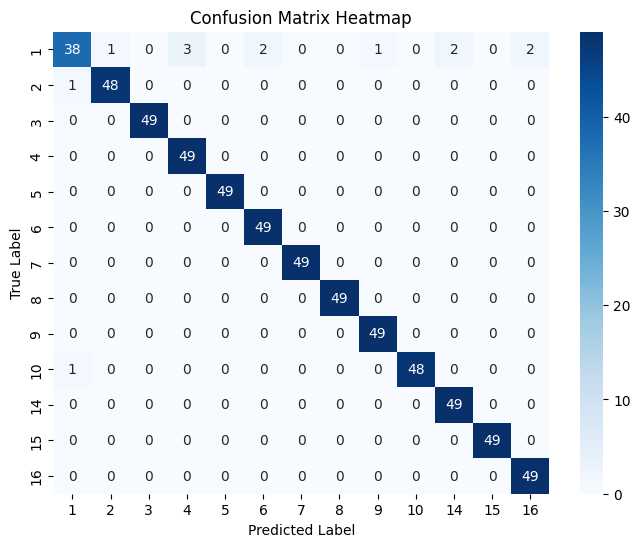

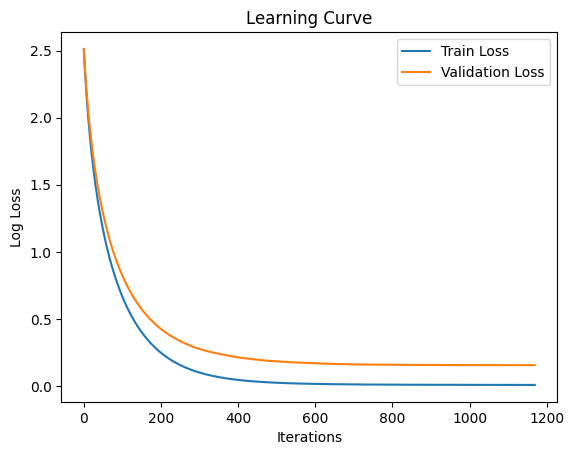

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load data
csv_file = "ecg_data/arrhythmia.csv"
df = pd.read_csv(csv_file)

# Fill missing values with median
df.fillna(df.median(), inplace=True)

# Encode labels
label_encoder = LabelEncoder()
df["Class"] = label_encoder.fit_transform(df["Class"])

# Save LabelEncoder
joblib.dump(label_encoder, "label_encoder.pkl")
print("LabelEncoder saved as label_encoder.pkl")

# Split features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# Feature selection with RFE
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=50)
X_selected = rfe.fit_transform(X, y)

# Save selected feature names
selected_features = X.columns[rfe.support_].tolist()
joblib.dump(selected_features, "selected_features.pkl")
print("Selected features saved as selected_features.pkl")
print("Selected features:", selected_features)

# Handle class imbalance with SMOTE
smote = SMOTE(k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Split train set into train and validation
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Define base models
base_models = [
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("svm", SVC(kernel="rbf", probability=True)),
    ("lr", LogisticRegression(max_iter=1000))
]

# Initialize stacking classifier
stacked_model = StackingClassifier(
    estimators=base_models, final_estimator=LogisticRegression(max_iter=1000)
)

# Fit stacking model
stacked_model.fit(X_train_sub, y_train_sub)

# Save stacking model
joblib.dump(stacked_model, "stacked_model.pkl")
print("Stacking model saved as stacked_model.pkl")

# Transform data to meta-features
X_train_meta = stacked_model.transform(X_train_sub)
X_val_meta = stacked_model.transform(X_val)
X_test_meta = stacked_model.transform(X_test)

# Train XGBoost with early stopping
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
    early_stopping_rounds=20,
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.5,
    reg_alpha=1.0
)

xgb_model.fit(
    X_train_meta, y_train_sub,
    eval_set=[(X_train_meta, y_train_sub), (X_val_meta, y_val)],
    verbose=True
)

# Predict and evaluate
y_pred = xgb_model.predict(X_test_meta)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Hybrid Model Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# Save XGBoost model
joblib.dump(xgb_model, "trained_model.pkl")
print("XGBoost model saved as trained_model.pkl")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Plot learning curve
results = xgb_model.evals_result()
plt.plot(results["validation_0"]["mlogloss"], label="Train Loss")
plt.plot(results["validation_1"]["mlogloss"], label="Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [ ]:
import wfdb
import numpy as np
from scipy import signal
import os
import pandas as pd
import joblib
from uuid import uuid4

def load_ecg_data(mat_file_path, hea_file_path):
    """Load ECG data in physical units (mV)."""
    try:
        record = wfdb.rdrecord(hea_file_path.replace('.hea', ''))
        signals = record.p_signal
        fs = record.fs
        lead_names = record.sig_name
        signals *= 25
        print(f"Signal amplitude range (mV): {np.min(signals):.3f} to {np.max(signals):.3f}")
        print(f"Raw signal samples (lead II, first 10): {signals[:10, 1]}")
        for i, lead in enumerate(lead_names):
            print(f"Lead {lead} amplitude range (mV): {np.min(signals[:, i]):.3f} to {np.max(signals[:, i]):.3f}")
        signals = signals[:2570, :]
        return signals, fs, lead_names
    except Exception as e:
        print(f"Error loading {hea_file_path}: {e}")
        return None, None, None

def detect_qrs(signals, fs):
    """Detect QRS complexes with noise filtering."""
    qrs_locs_all = []
    try:
        from wfdb import processing
        for lead_signal in signals.T:
            b, a = signal.butter(4, 40, btype='low', fs=fs)
            filtered = signal.filtfilt(b, a, lead_signal)
            qrs_locs = processing.xqrs_detect(sig=filtered, fs=fs, verbose=False)
            qrs_locs_all.append(qrs_locs)
    except (ImportError, AttributeError):
        print("wfdb.processing not available, using scipy.signal.find_peaks")
        for lead_signal in signals.T:
            b, a = signal.butter(4, 40, btype='low', fs=fs)
            filtered = signal.filtfilt(b, a, lead_signal)
            b, a = signal.butter(4, [5, 15], btype='band', fs=fs)
            filtered = signal.filtfilt(b, a, filtered)
            peaks, _ = signal.find_peaks(filtered, distance=int(0.6 * fs), prominence=0.05)
            qrs_locs_all.append(peaks)
    print(f"QRS peaks detected in lead II: {len(qrs_locs_all[1])}")
    return qrs_locs_all[1] if len(qrs_locs_all) > 1 else np.array([]), qrs_locs_all

def detect_p_t_waves(lead_signal, qrs_locs, fs):
    """Detect P and T waves with onset/offset detection."""
    b, a = signal.butter(4, [0.5, 40], btype='band', fs=fs)
    filtered = signal.filtfilt(b, a, lead_signal)

    p_peaks, t_peaks = [], []
    window_p = int(0.5 * fs)
    window_t = int(0.8 * fs)
    for qrs in qrs_locs:
        p_start = max(0, qrs - window_p)
        p_segment = filtered[p_start:qrs]
        if len(p_segment) > 10:
            p_peak_idx = p_start + np.argmax(np.abs(p_segment))
            p_diff = np.diff(p_segment)
            p_crossings = np.where(np.diff(np.sign(p_diff)))[0]
            if len(p_crossings) > 0:
                p_peaks.append(p_peak_idx)

        t_end = min(len(filtered), qrs + window_t)
        t_segment = filtered[qrs:t_end]
        if len(t_segment) > 10:
            t_peak_idx = qrs + np.argmax(np.abs(t_segment))
            t_amplitude = filtered[t_peak_idx]
            t_offset = t_peak_idx
            for i in range(t_peak_idx, min(t_end, len(filtered))):
                if abs(filtered[i]) < 0.03 * abs(t_amplitude) or np.abs(np.diff(filtered[max(i-2, 0):i+2])).mean() < 0.0005:
                    t_offset = i
                    break
            if t_offset > t_peak_idx or abs(t_amplitude) > 0.03:
                t_peaks.append(t_peak_idx)
            else:
                print(f"T peak detection failed at QRS {qrs}, amplitude: {t_amplitude:.3f}")

    print(f"P peaks: {len(p_peaks)}, T peaks: {len(t_peaks)}")
    return np.array(p_peaks), np.array(t_peaks)

def compute_intervals(qrs_locs, p_peaks, t_peaks, lead_signal, fs):
    """Compute temporal intervals in seconds."""
    if len(qrs_locs) < 2:
        print("Insufficient QRS peaks for interval calculation")
        return None, None, None, None, None
    try:
        qrs_dur = None
        pr_int = np.mean([(qrs_locs[i] - p_peaks[i]) / fs for i in range(min(len(qrs_locs), len(p_peaks))) if qrs_locs[i] > p_peaks[i]]) if len(p_peaks) > 0 else 0
        qt_int = np.mean([(t_peaks[i] - qrs_locs[i]) / fs for i in range(min(len(qrs_locs), len(t_peaks))) if t_peaks[i] > qrs_locs[i]]) if len(t_peaks) > 0 else 0
        qt_int = min(qt_int, 0.44) if qt_int > 0 else qt_int
        p_durations = []
        window_p = int(0.12 * fs)
        for p in p_peaks:
            start = max(0, p - window_p//2)
            end = min(len(lead_signal), p + window_p//2)
            if end > start:
                p_durations.append((end - start) / fs)
        p_int = np.mean(p_durations) if p_durations else 0
        t_durations = []
        window_t = int(0.25 * fs)
        for t in t_peaks:
            start = max(0, t - window_t//2)
            end = min(len(lead_signal), t + window_t//2)
            if end > start:
                t_durations.append((end - start) / fs)
        t_int = np.mean(t_durations) if t_durations else 0
        return qrs_dur, pr_int, qt_int, p_int, t_int
    except Exception as e:
        print(f"Error in interval calculation: {e}")
        return None, None, None, None, None

def compute_heart_rate(qrs_locs, fs):
    """Compute heart rate from RR intervals."""
    if len(qrs_locs) < 2:
        return 0
    try:
        rr_intervals = np.diff(qrs_locs) / fs
        return 60 / np.mean(rr_intervals)
    except:
        return 0

def compute_qrst_angle(signals, qrs_locs, fs, lead_names):
    """Compute QRST angle using leads I and II."""
    try:
        lead_idx = {name: idx for idx, name in enumerate(lead_names)}
        qrs_vec = np.array([
            np.mean([signals[qrs, lead_idx['I']] for qrs in qrs_locs]) if len(qrs_locs) > 0 else 0,
            np.mean([signals[qrs, lead_idx['II']] for qrs in qrs_locs]) if len(qrs_locs) > 0 else 0
        ])
        t_peaks, _ = detect_p_t_waves(signals[:, lead_idx['I']], qrs_locs, fs)
        t_vec = np.array([
            np.mean([signals[t, lead_idx['I']] for t in t_peaks]) if len(t_peaks) > 0 else 0,
            np.mean([signals[t, lead_idx['II']] for t in t_peaks]) if len(t_peaks) > 0 else 0
        ])
        angle = np.arccos(np.dot(qrs_vec, t_vec) / (np.linalg.norm(qrs_vec) * np.linalg.norm(t_vec) + 1e-10)) * 180 / np.pi
        return angle
    except:
        return 0

def compute_wave_features(lead_signal, qrs_locs, p_peaks, t_peaks, fs):
    """Compute wave-specific features."""
    features = {}
    q_peaks, s_peaks, r_prime_peaks = [], [], []
    window = int(0.12 * fs)
    lead_amplitude = np.max(np.abs(lead_signal))
    prominence_r = max(0.002 * lead_amplitude, 0.001)
    for qrs in qrs_locs:
        q_start = max(0, qrs - window)
        q_segment = lead_signal[q_start:qrs]
        if len(q_segment) > 5:
            peaks, props = signal.find_peaks(-q_segment, prominence=0.005)
            if len(peaks) > 0:
                q_peaks.append(q_start + peaks[0])
            else:
                q_peaks.append(max(0, qrs - int(0.05 * fs)))

        s_end = min(len(lead_signal), qrs + window)
        s_segment = lead_signal[qrs:s_end]
        if len(s_segment) > 5:
            peaks, props = signal.find_peaks(-s_segment, prominence=0.005)
            if len(peaks) > 0:
                s_peaks.append(qrs + peaks[0])
            else:
                s_peaks.append(min(len(lead_signal), qrs + int(0.05 * fs)))

        r_end = min(len(lead_signal), qrs + int(0.15 * fs))
        r_segment = lead_signal[qrs:r_end]
        if len(r_segment) > 5:
            peaks, props = signal.find_peaks(r_segment, prominence=prominence_r)
            if len(peaks) > 1:
                r_prime_peaks.append(qrs + peaks[1])
            elif len(peaks) == 1 and props['prominences'][0] > 0.005 * lead_amplitude:
                r_prime_peaks.append(qrs + peaks[0])

    print(f"Q peaks: {len(q_peaks)}, S peaks: {len(s_peaks)}, R' peaks: {len(r_prime_peaks)}")
    qrs_durations = [(s - q) / fs for q, s in zip(q_peaks, s_peaks) if s > q]
    qrs_dur = np.mean(qrs_durations) if qrs_durations else 0.1

    q_wave = np.mean([lead_signal[q] for q in q_peaks]) if len(q_peaks) > 0 else 0
    r_wave = np.mean([lead_signal[qrs] for qrs in qrs_locs]) if len(qrs_locs) > 0 else 0
    s_wave = np.mean([lead_signal[s] for s in s_peaks]) if len(s_peaks) > 0 else 0
    t_wave = np.mean([lead_signal[t] for t in t_peaks]) if len(t_peaks) > 0 else 0
    p_wave = np.mean([lead_signal[p] for p in p_peaks]) if len(p_peaks) > 0 else 0
    r_prime_wave = np.mean([lead_signal[r] for r in r_prime_peaks]) if len(r_prime_peaks) > 0 else r_wave

    jj_peaks = [qrs + int(0.04 * fs) for qrs in qrs_locs]
    jj_wave = np.mean([lead_signal[jj] for jj in jj_peaks if jj < len(lead_signal)]) if len(jj_peaks) > 0 else 0

    qrsa = np.mean([lead_signal[qrs] - lead_signal[q] + lead_signal[s] for qrs, q, s in zip(qrs_locs, q_peaks, s_peaks)]) if len(q_peaks) > 0 and len(s_peaks) > 0 and len(qrs_locs) > 0 else r_wave
    qrsta = qrsa + t_wave if len(t_peaks) > 0 else qrsa

    window_def = int(0.25 * fs)
    num_deflections = 0
    noise_level = np.std(signal.filtfilt(*signal.butter(4, [40, 100], btype='band', fs=fs), lead_signal))
    deflection_threshold = max(0.001, 2 * noise_level)
    for qrs in qrs_locs:
        start = max(0, qrs - window_def//2)
        end = min(len(lead_signal), qrs + window_def//2)
        segment = lead_signal[start:end]
        crossings = np.where(np.diff(np.sign(segment)))[0]
        if len(crossings) > 0:
            amplitudes = np.abs(segment[crossings])
            valid_crossings = crossings[amplitudes > deflection_threshold]
            num_deflections += len(valid_crossings)
    num_deflections = num_deflections / len(qrs_locs) if len(qrs_locs) > 0 else 0

    if r_prime_wave == r_wave and r_wave != 0:
        print(f"Warning: R' wave using R wave ({r_wave:.3f} mV), segment max: {np.max(r_segment):.3f}, min: {np.min(r_segment):.3f}, mean: {np.mean(r_segment):.3f}, prominence: {prominence_r:.3f}")

    return {
        'Q_wave': q_wave,
        'R_wave': r_wave,
        'S_wave': s_wave,
        'T_wave': t_wave,
        'P_wave': p_wave,
        'JJ_wave': jj_wave,
        'QRSA': qrsa,
        'QRSTA': qrsta,
        'Num_intrinsic_deflections': num_deflections,
        'QRS_duration': qrs_dur,
        'R_prime_wave': r_prime_wave
    }

def extract_features(signals, fs, lead_names, feature_list, median_values):
    """Extract specified features, fill missing with medians."""
    features = {}
    if signals is None or fs is None:
        print("No signals or sampling frequency provided")
        return features
    qrs_locs, qrs_locs_all = detect_qrs(signals, fs)

    lead_signal = signals[:, 1]
    p_peaks, t_peaks = detect_p_t_waves(lead_signal, qrs_locs, fs)
    _, pr_int, qt_int, p_int, t_int = compute_intervals(qrs_locs, p_peaks, t_peaks, lead_signal, fs)
    features['P-R_interval'] = pr_int if pr_int is not None else 0
    features['Q-T_interval'] = qt_int if qt_int is not None else 0
    features['P_interval'] = p_int if p_int is not None else 0
    features['T_interval'] = t_int if t_int is not None else 0
    features['Heart_rate'] = compute_heart_rate(qrs_locs, fs)
    features['QRST_angle'] = compute_qrst_angle(signals, qrs_locs, fs, lead_names)

    features['Height'] = np.max(signals[:, 1]) if len(signals) > 0 else 0

    lead_idx = {name: idx for idx, name in enumerate(lead_names)}
    lead_map = {'I': 'DI', 'II': 'DII', 'III': 'DIII', 'aVR': 'AVR', 'aVL': 'AVL', 'aVF': 'AVF', 'V1': 'V1', 'V2': 'V2', 'V3': 'V3', 'V4': 'V4', 'V5': 'V5', 'V6': 'V6'}
    for lead in ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']:
        if lead not in lead_idx:
            print(f"Lead {lead} not found in signal")
            continue
        lead_signal = signals[:, lead_idx[lead]]
        p_peaks, t_peaks = detect_p_t_waves(lead_signal, qrs_locs, fs)
        wave_features = compute_wave_features(lead_signal, qrs_locs, p_peaks, t_peaks, fs)

        prefix = lead_map[lead]
        for feature, value in wave_features.items():
            feature_name = f"{prefix}_{feature}"
            if feature_name in feature_list or feature_name.replace('_wave', '_wave_1') in feature_list:
                features[feature_name] = value
        if f"{prefix}_R'_wave" in feature_list:
            features[f"{prefix}_R'_wave"] = wave_features['R_prime_wave']
        if f"{prefix}_R'_wave_1" in feature_list:
            features[f"{prefix}_R'_wave_1"] = wave_features['R_prime_wave']
        if f"{prefix}_Q_wave_1" in feature_list:
            features[f"{prefix}_Q_wave_1"] = wave_features['Q_wave']
        if f"{prefix}_S_wave_1" in feature_list:
            features[f"{prefix}_S_wave_1"] = wave_features['S_wave']
        if lead == 'II':
            features['QRS_duration'] = wave_features['QRS_duration']
        if not wave_features['T_wave']:
            print(f"No T wave detected in lead {lead}")

    # Fill missing features with training medians
    for feature in feature_list:
        if feature not in features:
            features[feature] = median_values.get(feature, 0)
            print(f"Warning: Feature {feature} missing, filled with median {median_values.get(feature, 0)}")

    return features

def load_models_and_artifacts(stacked_model_path, xgb_model_path, label_encoder_path, selected_features_path, training_csv_path):
    """Load models and artifacts."""
    try:
        stacked_model = joblib.load(stacked_model_path)
        print(f"Stacked model loaded from {stacked_model_path}")
    except Exception as e:
        print(f"Error loading stacked model: {e}")
        return None, None, None, None, None

    try:
        xgb_model = joblib.load(xgb_model_path)
        print(f"XGBoost model loaded from {xgb_model_path}")
    except Exception as e:
        print(f"Error loading XGBoost model: {e}")
        return None, None, None, None, None

    try:
        label_encoder = joblib.load(label_encoder_path)
        print(f"Label encoder loaded from {label_encoder_path}")
    except Exception as e:
        print(f"Error loading label encoder: {e}")
        return None, None, None, None, None

    try:
        selected_features = joblib.load(selected_features_path)
        print(f"Selected features loaded from {selected_features_path}")
        print(f"Selected features: {selected_features}")
    except Exception as e:
        print(f"Error loading selected features: {e}")
        return None, None, None, None, None

    try:
        df = pd.read_csv(training_csv_path)
        median_values = df.drop(columns=["Class"]).median().to_dict()
        print(f"Training medians loaded from {training_csv_path}")
    except Exception as e:
        print(f"Error loading training CSV: {e}")
        median_values = {}

    return stacked_model, xgb_model, label_encoder, selected_features, median_values

def predict_ecg(stacked_model, xgb_model, label_encoder, features, feature_list):
    """Predict using the stacked and XGBoost models."""
    try:
        # Prepare feature vector in the order of feature_list
        feature_vector = np.array([features.get(f, 0) for f in feature_list]).reshape(1, -1)
        print(f"Raw feature vector shape: {feature_vector.shape}")

        # Transform to meta-features
        meta_features = stacked_model.transform(feature_vector)
        print(f"Meta-features shape: {meta_features.shape}")

        # Predict with XGBoost
        prediction = xgb_model.predict(meta_features)

        # Decode prediction
        decoded_prediction = label_encoder.inverse_transform(prediction)[0]
        return decoded_prediction
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

def process_ecg_files(data_dir, stacked_model_path, xgb_model_path, label_encoder_path, selected_features_path, training_csv_path):
    """Process ECG files, extract features, and predict."""
    stacked_model, xgb_model, label_encoder, feature_list, median_values = load_models_and_artifacts(
        stacked_model_path, xgb_model_path, label_encoder_path, selected_features_path, training_csv_path
    )

    if any(x is None for x in [stacked_model, xgb_model, label_encoder, feature_list]):
        print("Failed to load models or artifacts, exiting")
        return []

    all_results = []
    for file in os.listdir(data_dir):
        if file.endswith('.hea'):
            hea_file = os.path.join(data_dir, file)
            mat_file = hea_file.replace('.hea', '.mat')
            if not os.path.exists(mat_file):
                print(f"Missing .mat file for {hea_file}")
                continue
            signals, fs, lead_names = load_ecg_data(mat_file, hea_file)
            if signals is None:
                continue
            features = extract_features(signals, fs, lead_names, feature_list, median_values)
            if not features:
                print(f"No features extracted for {file}")
                continue
            features['file'] = file
            prediction = predict_ecg(stacked_model, xgb_model, label_encoder, features, feature_list)
            if prediction is not None:
                features['prediction'] = prediction
                all_results.append(features)
                print(f"File: {file}, Prediction: {prediction}")
            else:
                print(f"Prediction failed for {file}")

    return all_results

if __name__ == "__main__":
    # Install dependencies
    # !pip install --upgrade wfdb scipy numpy pandas joblib

    # Specify paths
    data_dir = '/content'  # Update to your ECG data directory
    stacked_model_path = '/content/stacked_model.pkl'
    xgb_model_path = '/content/trained_model.pkl'
    label_encoder_path = '/content/label_encoder.pkl'
    selected_features_path = '/content/selected_features.pkl'
    training_csv_path = '/content/ecg_data/arrhythmia.csv'

    # Process files and predict
    results = process_ecg_files(
        data_dir, stacked_model_path, xgb_model_path, label_encoder_path, selected_features_path, training_csv_path
    )

    if results:
        # Save results to CSV
        df = pd.DataFrame(results)
        output_csv = '/content/ecg_predictions.csv'
        df.to_csv(output_csv, index=False)
        print(f"Results saved to {output_csv}")

        # Print detailed results
        for result in results:
            print(f"\nFile: {result['file']}")
            print(f"Prediction: {result['prediction']}")
            for feature in feature_list:
                value = result.get(feature, 0)
                print(f"{feature}: {value}")
                if feature in ['QRS_duration', 'P-R_interval', 'Q-T_interval', 'P_interval', 'T_interval'] and value > 0:
                    expected_ranges = {
                        'QRS_duration': (0.06, 0.12),
                        'P-R_interval': (0.12, 0.20),
                        'Q-T_interval': (0.30, 0.44),
                        'P_interval': (0.08, 0.12),
                        'T_interval': (0.10, 0.25)
                    }
                    min_val, max_val = expected_ranges[feature]
                    if value < min_val or value > max_val:
                        print(f"Warning: {feature} value {value} is outside expected range [{min_val}, {max_val}]")
                elif feature.endswith('_wave') and abs(value) > 5:
                    print(f"Warning: {feature} amplitude {value} is unusually large (expected < 5 mV)")
    else:
        print("No valid ECG files processed or predictions made")

Stacked model loaded from /content/stacked_model.pkl
XGBoost model loaded from /content/trained_model.pkl
Label encoder loaded from /content/label_encoder.pkl
Selected features loaded from /content/selected_features.pkl
Selected features: ['Feature_3', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_13', 'Feature_15', 'Feature_76', 'Feature_90', 'Feature_91', 'Feature_93', 'Feature_112', 'Feature_113', 'Feature_114', 'Feature_117', 'Feature_167', 'Feature_168', 'Feature_169', 'Feature_171', 'Feature_177', 'Feature_179', 'Feature_181', 'Feature_197', 'Feature_207', 'Feature_211', 'Feature_224', 'Feature_226', 'Feature_228', 'Feature_230', 'Feature_233', 'Feature_234', 'Feature_237', 'Feature_238', 'Feature_239', 'Feature_240', 'Feature_242', 'Feature_243', 'Feature_247', 'Feature_248', 'Feature_249', 'Feature_250', 'Feature_252', 'Feature_257', 'Feature_259', 'Feature_260', 'Feature_267', 'Feature_270', 'Feature_277', 'Feature_279']
Training medians loaded from

Leads: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Sampling rate: 257 Hz


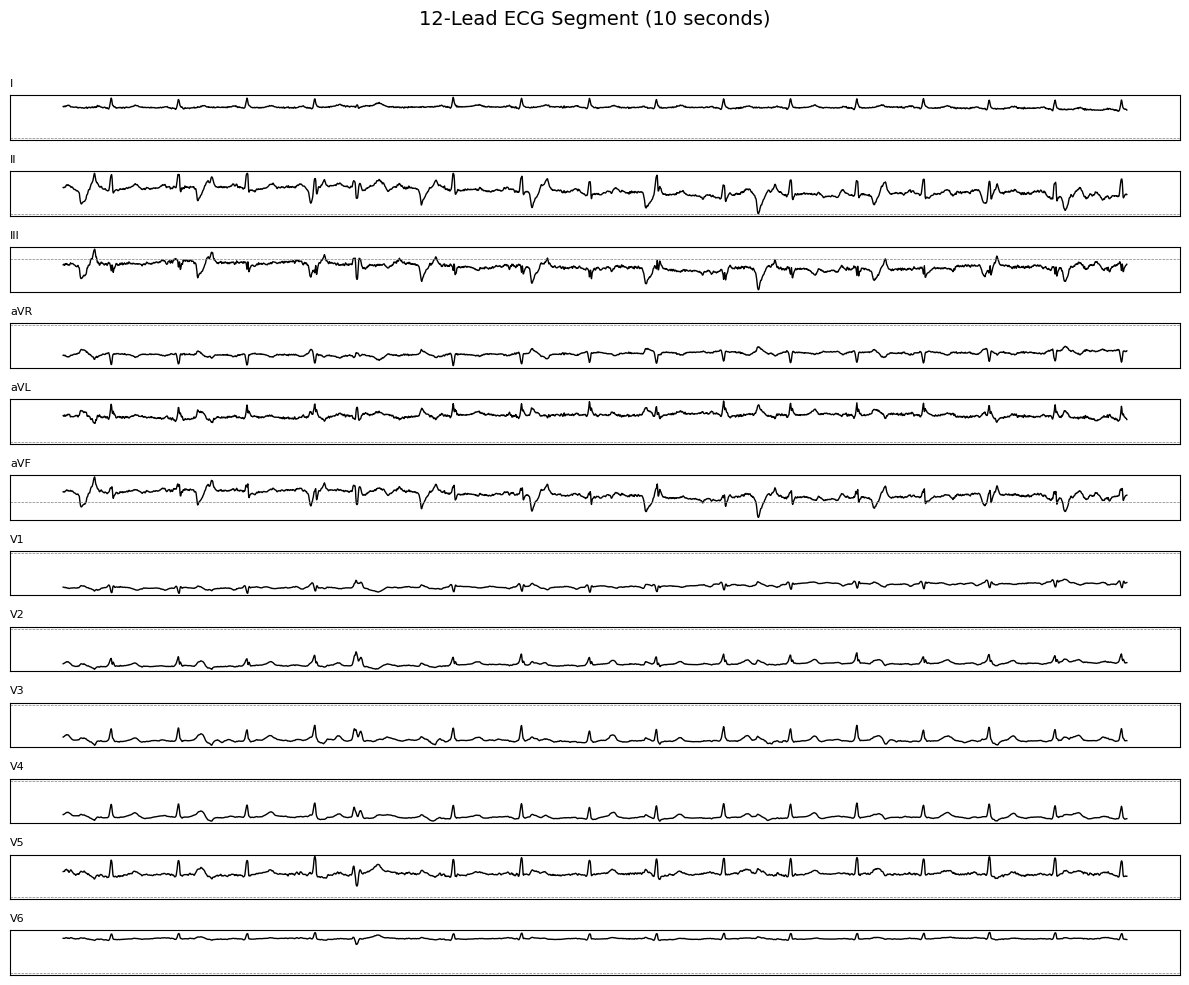

In [ ]:
import wfdb
import matplotlib.pyplot as plt

# Replace with your file path (without extension)
record_path = "/content/I0001"  # e.g., "ecg_data/record_001"

# Read the record
record = wfdb.rdrecord(record_path)

# Get signal data and metadata
signals = record.p_signal         # shape: (n_samples, n_leads)
lead_names = record.sig_name      # e.g., ['I', 'II', 'III', ..., 'V6']
fs = record.fs                    # sampling frequency

# Optional: print available info
print(f"Leads: {lead_names}")
print(f"Sampling rate: {fs} Hz")

# Choose duration and extract signal window (e.g., 10 seconds)
duration = 10  # seconds
start = 0
end = int(fs * duration)
segment = signals[start:end, :]

# Plot the 12-lead ECG
plt.figure(figsize=(12, 10))
for i, lead in enumerate(lead_names):
    plt.subplot(len(lead_names), 1, i + 1)
    plt.plot(segment[:, i], color='black', linewidth=1)
    plt.title(lead, fontsize=8, loc='left')
    plt.xticks([])
    plt.yticks([])
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

plt.suptitle("12-Lead ECG Segment (10 seconds)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
pip install wfdb biosppy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 47.7 MB/s eta 0:00:00


In [ ]:
!pip install peakutils


In [ ]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 15.7 MB/s eta 0:00:00


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

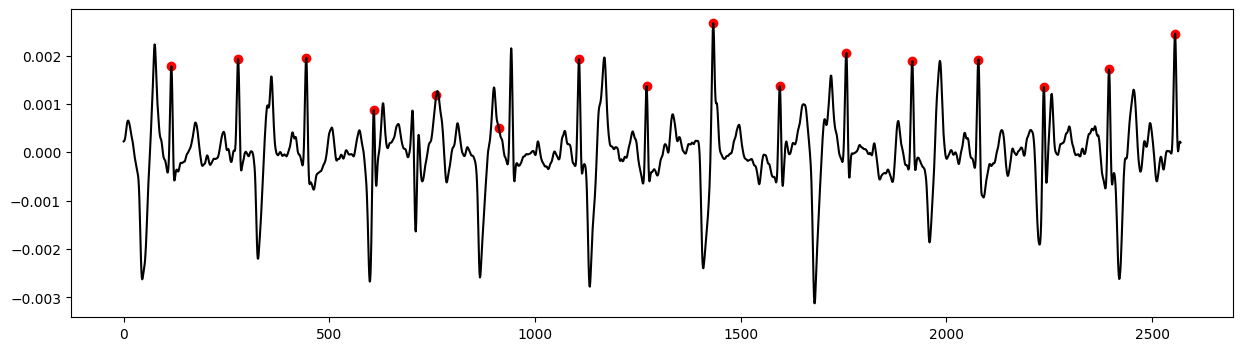

In [ ]:
import wfdb
import neurokit2 as nk
import matplotlib.pyplot as plt

# Load ECG record
record_path = "/content/I0001"  # don't include .mat/.hea
record = wfdb.rdrecord(record_path)
fs = record.fs
signals = record.p_signal
lead_names = record.sig_name

# Select lead
lead_index = lead_names.index("II") if "II" in lead_names else 0
ecg_raw = signals[:fs * 10, lead_index]  # 10 seconds

# Process ECG
ecg_cleaned = nk.ecg_clean(ecg_raw, sampling_rate=fs)
signals, info = nk.ecg_process(ecg_cleaned, sampling_rate=fs)

# Extract wave features
rpeaks = info["ECG_R_Peaks"]
p_peaks = info["ECG_P_Peaks"]
t_peaks = info["ECG_T_Peaks"]

# Plot manually with annotations
plt.figure(figsize=(15, 4))
plt.plot(ecg_cleaned, label="ECG Signal", color='black')
plt.scatter(rpeaks, ecg_cleaned[rpeaks], color='red', label='R-peaks')
plt.scatter(p_peaks, ecg_cleaned[p_peaks], color='blue', label='P-peaks')
plt.scatter(t_peaks, ecg_cleaned[t_peaks], color='green', label='T-peaks')

plt.title("ECG Signal with Annotated R, P, and T Peaks")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()



✅ Accuracy: 0.8132
Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.98      0.91        49
           2       0.70      0.78      0.74         9
           3       0.50      1.00      0.67         3
           4       1.00      0.33      0.50         3
           5       0.00      0.00      0.00         3
           6       1.00      0.80      0.89         5
           7       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         2
          10       0.75      0.90      0.82        10
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4

    accuracy                           0.81        91
   macro avg       0.48      0.48      0.46        91
weighted avg       0.74      0.81      0.76        91



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


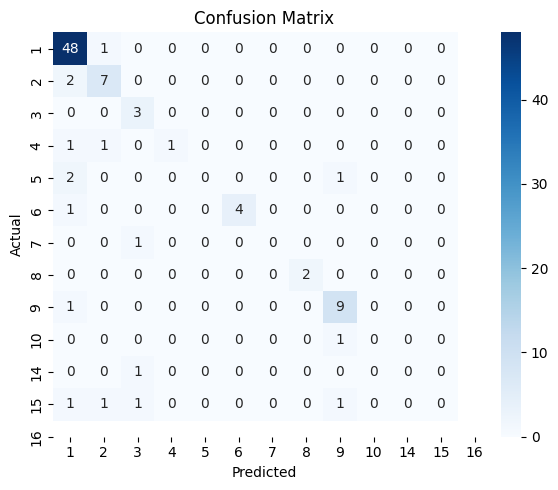

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score


# Step 1: Load the dataset
df = pd.read_csv('/content/ecg_data/arrhythmia.csv')

# Step 2: Prepare features and labels
X = df.drop(columns=['label', 'patient_id'], errors='ignore')  # drop non-feature columns
y = df['Class']

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 5: Predictions and evaluation
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {accuracy:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load your dataset
df = pd.read_csv('/content/ecg_data/arrhythmia.csv')
X = df.drop(columns=['target', 'patient_id'], errors='ignore')  # change target if needed
y = df['Class']




imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Impute missing values with mean
from sklearn.impute import SimpleImputer



def plot_learning_curve(estimator, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=5,
        train_sizes = np.linspace(0.1, 1.0, 10)
, scoring='accuracy'
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, 'o-', label="Training Score")
    plt.plot(train_sizes, test_mean, 'o-', label="CV Score")
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


def evaluate(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n📌 {name}")
    print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))


    # Define class labels, excluding 11, 12, 13
    class_labels = [
       "01 - Normal",
    "02 - Ischemic changes (CAD)",
    "03 - Old Anterior MI",
    "04 - Old Inferior MI",
    "05 - Sinus tachycardia",
    "06 - Sinus bradycardia",
    "07 - Ventricular Premature Contraction (PVC)",
    "08 - Supraventricular Premature Contraction",
    "09 - Left bundle branch block",
    "10 - Right bundle branch block",

    "15 - Atrial Fibrillation/Flutter",
    "16 - Others"
    ]

    # Plot confusion matrix with class names
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    plot_learning_curve(model, f"{name} - Learning Curve")



📌 Random Forest
✅ Accuracy: 0.8462
              precision    recall  f1-score   support

           1       0.89      1.00      0.94        49
           2       0.80      0.89      0.84         9
           3       0.50      1.00      0.67         3
           4       1.00      0.67      0.80         3
           5       0.00      0.00      0.00         3
           6       1.00      0.80      0.89         5
           7       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         2
          10       0.75      0.90      0.82        10
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4

    accuracy                           0.85        91
   macro avg       0.50      0.52      0.50        91
weighted avg       0.77      0.85      0.80        91



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


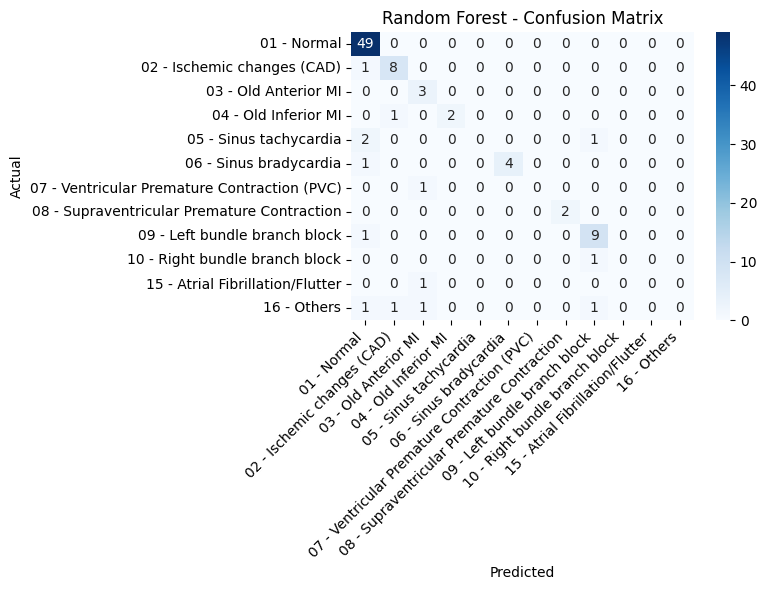

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


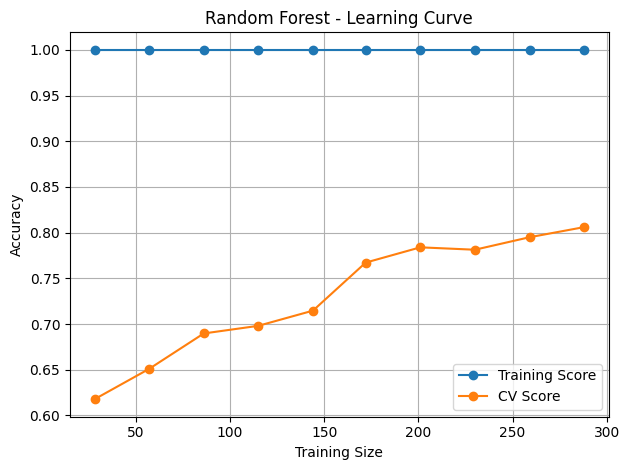

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate(rf_model, "Random Forest")



📌 Support Vector Machine
✅ Accuracy: 0.6154
              precision    recall  f1-score   support

           1       0.58      1.00      0.74        49
           2       0.00      0.00      0.00         9
           3       1.00      1.00      1.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         2
          10       1.00      0.20      0.33        10
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4

    accuracy                           0.62        91
   macro avg       0.30      0.27      0.26        91
weighted avg       0.48      0.62      0.49        91



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


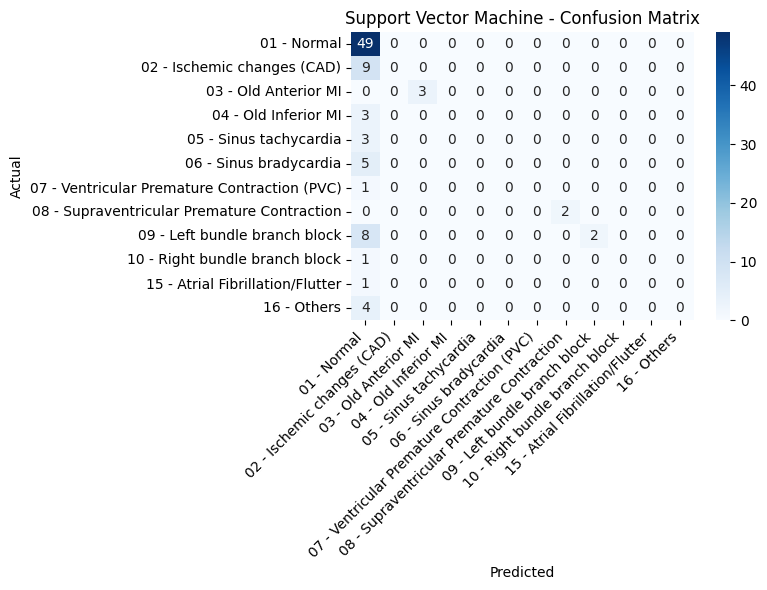

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


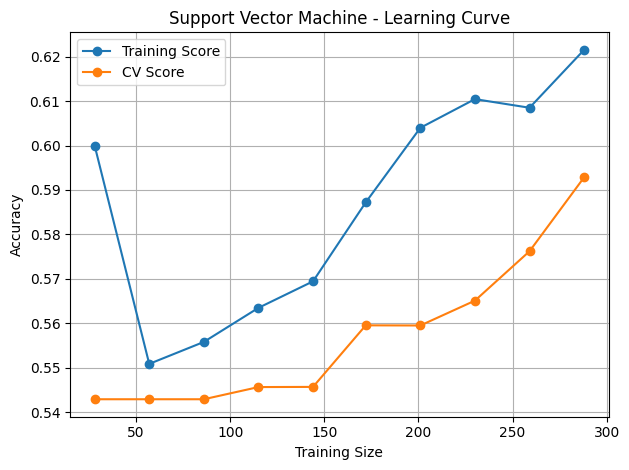

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', probability=False, random_state=42)
evaluate(svm_model, "Support Vector Machine")



📌 Logistic Regression
✅ Accuracy: 0.6813
              precision    recall  f1-score   support

           1       0.86      0.86      0.86        49
           2       0.55      0.67      0.60         9
           3       0.75      1.00      0.86         3
           4       0.00      0.00      0.00         3
           5       0.25      0.33      0.29         3
           6       0.29      0.40      0.33         5
           7       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         2
          10       0.71      0.50      0.59        10
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.20      0.25      0.22         4

    accuracy                           0.68        91
   macro avg       0.38      0.42      0.40        91
weighted avg       0.67      0.68      0.67        91



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


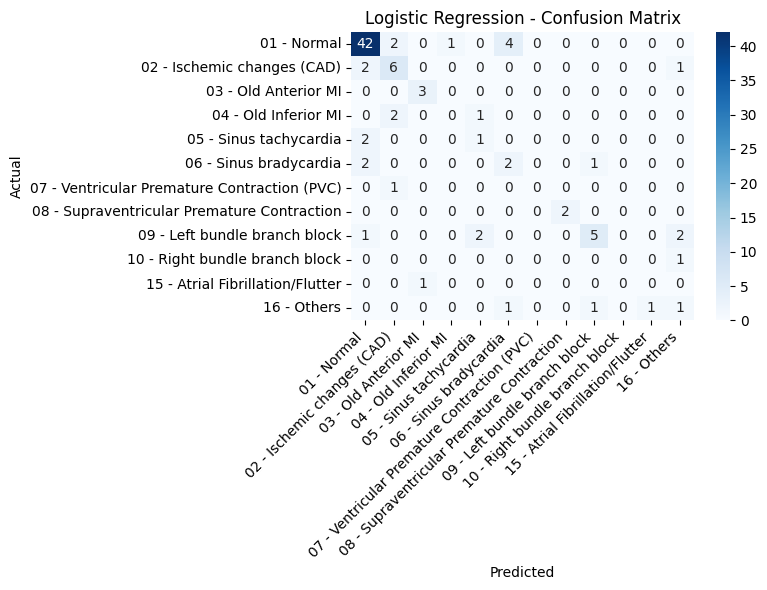

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


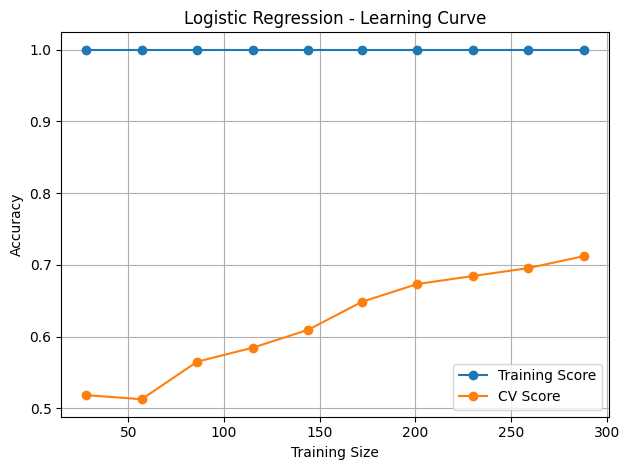

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, random_state=42)
evaluate(lr_model, "Logistic Regression")


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Use this encoded version in train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:57:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📌 XGBoost
✅ Accuracy: 0.9451
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        49
           1       1.00      1.00      1.00         9
           2       0.60      1.00      0.75         3
           3       1.00      1.00      1.00         3
           4       1.00      0.33      0.50         3
           5       1.00      1.00      1.00         5
           6       0.00      0.00      0.00         1
           8       1.00      1.00      1.00         2
           9       0.91      1.00      0.95        10
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         4

    accuracy                           0.95        91
   macro avg       0.71      0.69      0.68        91
weighted avg       0.92      0.95      0.93        91



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


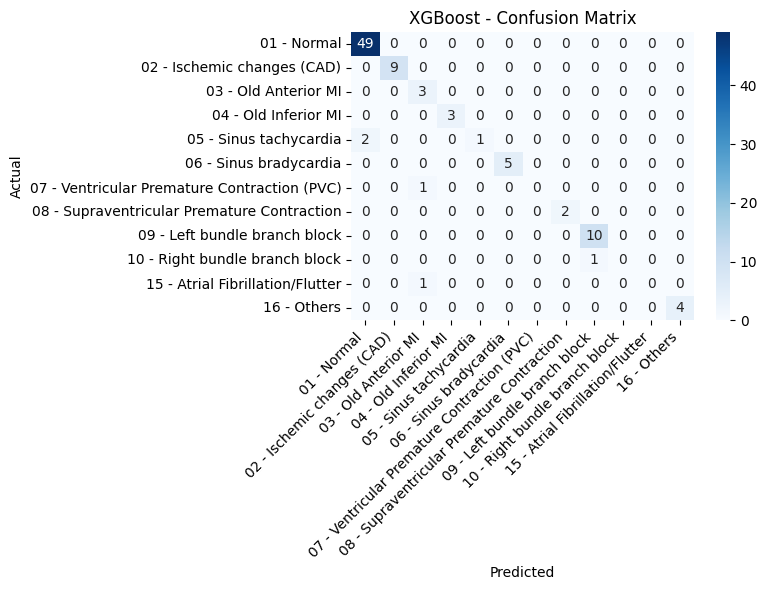

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:57:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:57:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:57:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:57:44] WARNING: /workspace/src/learner.cc:738: 
Para

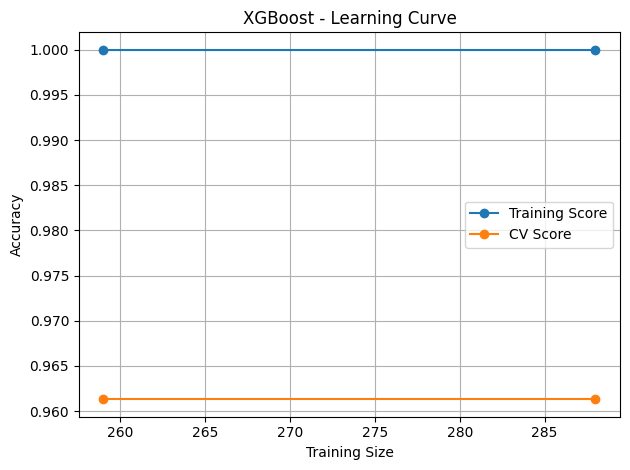

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
evaluate(xgb_model, "XGBoost")


LabelEncoder saved as label_encoder.pkl
Selected features saved as selected_features.pkl
Selected features: ['Feature_3', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_13', 'Feature_15', 'Feature_76', 'Feature_90', 'Feature_91', 'Feature_93', 'Feature_112', 'Feature_113', 'Feature_114', 'Feature_117', 'Feature_167', 'Feature_168', 'Feature_169', 'Feature_171', 'Feature_177', 'Feature_179', 'Feature_181', 'Feature_197', 'Feature_207', 'Feature_211', 'Feature_224', 'Feature_226', 'Feature_228', 'Feature_230', 'Feature_233', 'Feature_234', 'Feature_237', 'Feature_238', 'Feature_239', 'Feature_240', 'Feature_242', 'Feature_243', 'Feature_247', 'Feature_248', 'Feature_249', 'Feature_250', 'Feature_252', 'Feature_257', 'Feature_259', 'Feature_260', 'Feature_267', 'Feature_270', 'Feature_277', 'Feature_279']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Stacking model saved as stacked_model.pkl
[0]	validation_0-mlogloss:2.50542	validation_1-mlogloss:2.51229
[1]	validation_0-mlogloss:2.44944	validation_1-mlogloss:2.46170
[2]	validation_0-mlogloss:2.39604	validation_1-mlogloss:2.41157
[3]	validation_0-mlogloss:2.34685	validation_1-mlogloss:2.36542
[4]	validation_0-mlogloss:2.29879	validation_1-mlogloss:2.32016
[5]	validation_0-mlogloss:2.25264	validation_1-mlogloss:2.27845
[6]	validation_0-mlogloss:2.20848	validation_1-mlogloss:2.23791
[7]	validation_0-mlogloss:2.16606	validation_1-mlogloss:2.19991
[8]	validation_0-mlogloss:2.12536	validation_1-mlogloss:2.16331
[9]	validation_0-mlogloss:2.08680	validation_1-mlogloss:2.12857
[10]	validation_0-mlogloss:2.04952	validation_1-mlogloss:2.09515
[11]	validation_0-mlogloss:2.01336	validation_1-mlogloss:2.06286
[12]	validation_0-mlogloss:1.97941	validation_1-mlogloss:2.03215


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [14:40:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[13]	validation_0-mlogloss:1.94550	validation_1-mlogloss:2.00205
[14]	validation_0-mlogloss:1.91355	validation_1-mlogloss:1.97248
[15]	validation_0-mlogloss:1.88196	validation_1-mlogloss:1.94386
[16]	validation_0-mlogloss:1.85152	validation_1-mlogloss:1.91618
[17]	validation_0-mlogloss:1.82175	validation_1-mlogloss:1.88961
[18]	validation_0-mlogloss:1.79318	validation_1-mlogloss:1.86408
[19]	validation_0-mlogloss:1.76523	validation_1-mlogloss:1.83897
[20]	validation_0-mlogloss:1.73853	validation_1-mlogloss:1.81399
[21]	validation_0-mlogloss:1.71209	validation_1-mlogloss:1.78997
[22]	validation_0-mlogloss:1.68677	validation_1-mlogloss:1.76538
[23]	validation_0-mlogloss:1.66164	validation_1-mlogloss:1.74332
[24]	validation_0-mlogloss:1.63718	validation_1-mlogloss:1.72150
[25]	validation_0-mlogloss:1.61349	validation_1-mlogloss:1.69869
[26]	validation_0-mlogloss:1.59050	validation_1-mlogloss:1.67758
[27]	validation_0-mlogloss:1.56789	validation_1-mlogloss:1.65673
[28]	validation_0-mloglos

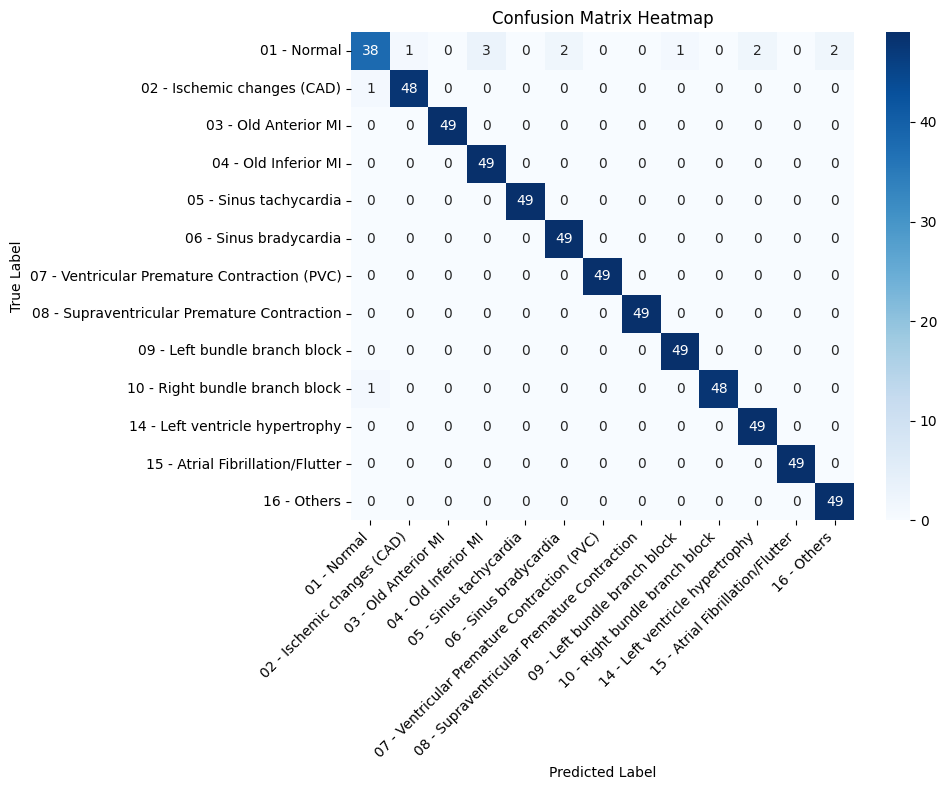

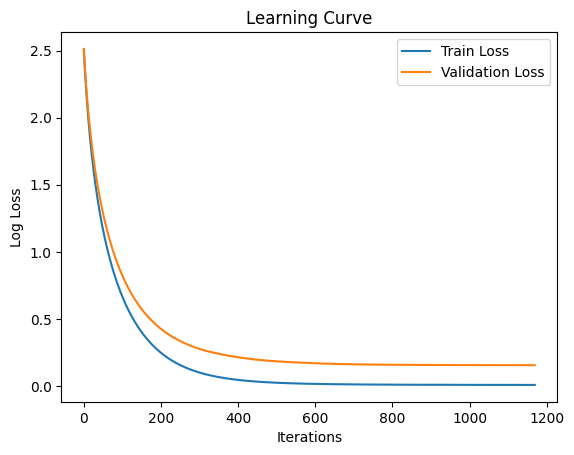

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load data
csv_file = "ecg_data/arrhythmia.csv"
df = pd.read_csv(csv_file)

# Fill missing values with median
df.fillna(df.median(), inplace=True)

# Encode labels
label_encoder = LabelEncoder()
df["Class"] = label_encoder.fit_transform(df["Class"])

# Save LabelEncoder
joblib.dump(label_encoder, "label_encoder.pkl")
print("LabelEncoder saved as label_encoder.pkl")

# Split features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# Feature selection with RFE
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=50)
X_selected = rfe.fit_transform(X, y)

# Save selected feature names
selected_features = X.columns[rfe.support_].tolist()
joblib.dump(selected_features, "selected_features.pkl")
print("Selected features saved as selected_features.pkl")
print("Selected features:", selected_features)

# Handle class imbalance with SMOTE
smote = SMOTE(k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Split train set into train and validation
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Add these lines right after your data preprocessing (before model training)
import os

# Create directory for ablation data if it doesn't exist
os.makedirs("ablation_data", exist_ok=True)

# Save all necessary data
joblib.dump(X_resampled, "ablation_data/X_resampled.pkl")
joblib.dump(y_resampled, "ablation_data/y_resampled.pkl")
joblib.dump(X_selected, "ablation_data/X_selected.pkl")  # After feature selection
joblib.dump(X, "ablation_data/X_original.pkl")  # Before any processing
joblib.dump(y, "ablation_data/y_original.pkl")

# Save train/test indices to recreate splits exactly
joblib.dump((X_train, X_test, y_train, y_test), "ablation_data/train_test_split.pkl")
# Define base models
base_models = [
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("svm", SVC(kernel="rbf", probability=True)),
    ("lr", LogisticRegression(max_iter=1000))
]

# Initialize stacking classifier
stacked_model = StackingClassifier(
    estimators=base_models, final_estimator=LogisticRegression(max_iter=1000)
)

# Fit stacking model
stacked_model.fit(X_train_sub, y_train_sub)

# Save stacking model
joblib.dump(stacked_model, "stacked_model.pkl")
print("Stacking model saved as stacked_model.pkl")

# Transform data to meta-features
X_train_meta = stacked_model.transform(X_train_sub)
X_val_meta = stacked_model.transform(X_val)
X_test_meta = stacked_model.transform(X_test)

# Train XGBoost with early stopping
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
    early_stopping_rounds=20,
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.5,
    reg_alpha=1.0
)

xgb_model.fit(
    X_train_meta, y_train_sub,
    eval_set=[(X_train_meta, y_train_sub), (X_val_meta, y_val)],
    verbose=True
)

# Predict and evaluate
y_pred = xgb_model.predict(X_test_meta)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Hybrid Model Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# Save XGBoost model
joblib.dump(xgb_model, "trained_model.pkl")
print("XGBoost model saved as trained_model.pkl")

# Define class labels with their descriptions
class_labels = [
    "01 - Normal",
    "02 - Ischemic changes (CAD)",
    "03 - Old Anterior MI",
    "04 - Old Inferior MI",
    "05 - Sinus tachycardia",
    "06 - Sinus bradycardia",
    "07 - Ventricular Premature Contraction (PVC)",
    "08 - Supraventricular Premature Contraction",
    "09 - Left bundle branch block",
    "10 - Right bundle branch block",
    "14 - Left ventricle hypertrophy",
    "15 - Atrial Fibrillation/Flutter",
    "16 - Others"
]

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot learning curve
results = xgb_model.evals_result()
plt.plot(results["validation_0"]["mlogloss"], label="Train Loss")
plt.plot(results["validation_1"]["mlogloss"], label="Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

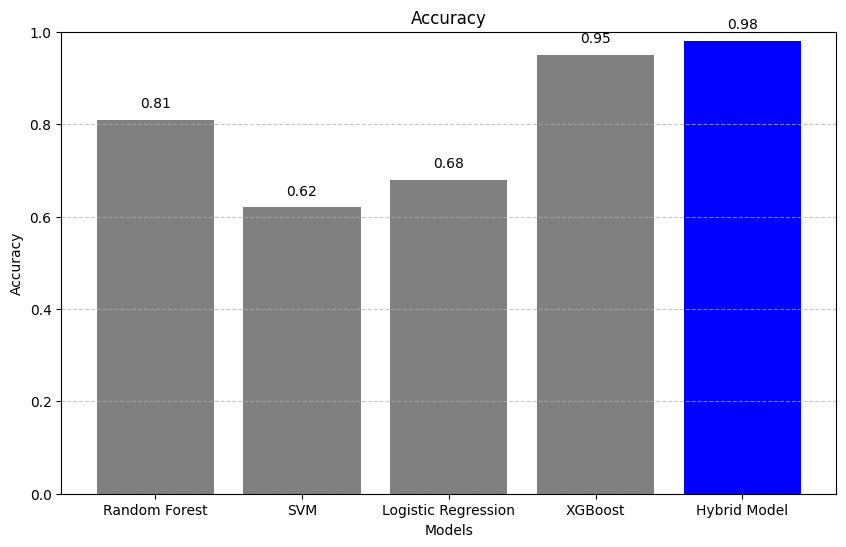

In [ ]:
import matplotlib.pyplot as plt

# Data
models = ['Random Forest', 'SVM', 'Logistic Regression', 'XGBoost', 'Hybrid Model']
accuracies = [0.81, 0.62, 0.68, 0.95, 0.98]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['gray', 'gray', 'gray', 'gray', 'blue'])

# Customize the plot
plt.ylim(0, 1.0)
plt.title('Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, str(v), ha='center', va='bottom')

# Display the plot
plt.show()


=== Original Tuned ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [14:45:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Accuracy: 0.9812
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        49
           1       1.00      0.98      0.99        49
           2       0.98      1.00      0.99        49
           3       0.98      0.98      0.98        49
           4       1.00      0.96      0.98        49
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        49
           7       1.00      1.00      1.00        49
           8       1.00      1.00      1.00        49
           9       0.94      0.98      0.96        49
          10       1.00      1.00      1.00        49
          11       1.00      0.98      0.99        49
          12       1.00      0.96      0.98        49

    accuracy                           0.98       637
   macro avg       0.98      0.98      0.98       637
weighted avg       0.98      0.98      0.98       637


=== No L1/L2 Regularization ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [14:45:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Accuracy: 0.9796
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        49
           1       0.98      0.98      0.98        49
           2       0.98      1.00      0.99        49
           3       0.98      0.98      0.98        49
           4       1.00      0.96      0.98        49
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        49
           7       1.00      1.00      1.00        49
           8       1.00      1.00      1.00        49
           9       0.92      1.00      0.96        49
          10       1.00      1.00      1.00        49
          11       1.00      0.98      0.99        49
          12       1.00      0.96      0.98        49

    accuracy                           0.98       637
   macro avg       0.98      0.98      0.98       637
weighted avg       0.98      0.98      0.98       637


=== No Subsample (subsample=1) ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [14:46:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Accuracy: 0.9796
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        49
           1       0.98      0.98      0.98        49
           2       1.00      1.00      1.00        49
           3       0.98      0.98      0.98        49
           4       1.00      0.96      0.98        49
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        49
           7       1.00      1.00      1.00        49
           8       1.00      1.00      1.00        49
           9       0.92      0.98      0.95        49
          10       1.00      1.00      1.00        49
          11       1.00      1.00      1.00        49
          12       1.00      0.96      0.98        49

    accuracy                           0.98       637
   macro avg       0.98      0.98      0.98       637
weighted avg       0.98      0.98      0.98       637


=== No Colsample (colsample_bytree=1) ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [14:46:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Accuracy: 0.9796
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        49
           1       1.00      0.98      0.99        49
           2       0.98      1.00      0.99        49
           3       0.98      0.98      0.98        49
           4       1.00      0.96      0.98        49
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        49
           7       1.00      1.00      1.00        49
           8       1.00      1.00      1.00        49
           9       0.92      0.98      0.95        49
          10       1.00      1.00      1.00        49
          11       1.00      0.98      0.99        49
          12       1.00      0.96      0.98        49

    accuracy                           0.98       637
   macro avg       0.98      0.98      0.98       637
weighted avg       0.98      0.98      0.98       637


=== No Tree Depth Limit (max_depth=None) ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [14:46:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Accuracy: 0.9812
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        49
           1       1.00      0.98      0.99        49
           2       0.98      1.00      0.99        49
           3       0.98      0.98      0.98        49
           4       1.00      0.96      0.98        49
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        49
           7       1.00      1.00      1.00        49
           8       1.00      1.00      1.00        49
           9       0.94      0.98      0.96        49
          10       1.00      1.00      1.00        49
          11       1.00      0.98      0.99        49
          12       1.00      0.96      0.98        49

    accuracy                           0.98       637
   macro avg       0.98      0.98      0.98       637
weighted avg       0.98      0.98      0.98       637


=== High Learning Rate (lr=0.1) ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [14:47:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Accuracy: 0.9812
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        49
           1       1.00      0.98      0.99        49
           2       0.98      1.00      0.99        49
           3       0.98      0.98      0.98        49
           4       1.00      0.96      0.98        49
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        49
           7       1.00      1.00      1.00        49
           8       1.00      1.00      1.00        49
           9       0.94      0.98      0.96        49
          10       1.00      1.00      1.00        49
          11       1.00      0.98      0.99        49
          12       1.00      0.96      0.98        49

    accuracy                           0.98       637
   macro avg       0.98      0.98      0.98       637
weighted avg       0.98      0.98      0.98       637


=== No Early Stopping ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:47:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9812
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        49
           1       1.00      0.98      0.99        49
           2       0.98      1.00      0.99        49
           3       0.98      0.98      0.98        49
           4       1.00      0.96      0.98        49
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        49
           7       1.00      1.00      1.00        49
           8       1.00      1.00      1.00        49
           9       0.94      0.98      0.96        49
          10       1.00      1.00      1.00        49
          11       1.00      0.98      0.99        49
          12       1.00      0.96      0.98        49

    accuracy                           0.98       637
   macro avg       0.98      0.98      0.98       637
weighted avg       0.98      0.98      0.98       637


=== Hyperparameter Ablation Summary ===
                     

/tmp/ipython-input-2827661396.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Variation", data=df, palette="viridis")


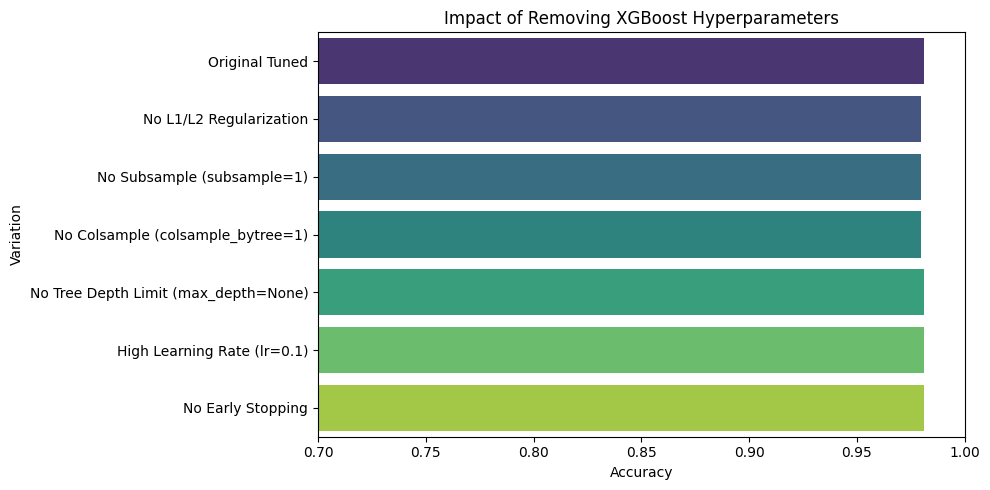

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

def load_data_and_models():
    """Load all required data and models for ablation study"""
    try:
        # Load processed data
        X_resampled = joblib.load("ablation_data/X_resampled.pkl")
        y_resampled = joblib.load("ablation_data/y_resampled.pkl")
        X_selected = joblib.load("ablation_data/X_selected.pkl")
        X_original = joblib.load("ablation_data/X_original.pkl")
        y_original = joblib.load("ablation_data/y_original.pkl")

        # Load train/test splits
        X_train, X_test, y_train, y_test = joblib.load("ablation_data/train_test_split.pkl")

        # Load models
        stacked_model = joblib.load("stacked_model.pkl")
        xgb_model = joblib.load("trained_model.pkl")

        # Generate meta-features
        X_train_meta = stacked_model.transform(X_train)
        X_test_meta = stacked_model.transform(X_test)

        return {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'X_train_meta': X_train_meta,
            'X_test_meta': X_test_meta,
            'X_resampled': X_resampled,
            'y_resampled': y_resampled,
            'X_selected': X_selected,
            'X_original': X_original,
            'y_original': y_original,
            'stacked_model': stacked_model,
            'xgb_model': xgb_model
        }

    except FileNotFoundError as e:
        print(f"Error loading files: {e}")
        print("Please run the original training script first to generate required files")
        return None

def xgboost_hyperparameter_ablation(X_train_meta, y_train, X_test_meta, y_test):
    """Test impact of removing specific XGBoost hyperparameters"""
    original_params = {
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'early_stopping_rounds': 20,
        'n_estimators': 2000,
        'learning_rate': 0.01,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_lambda': 1.5,  # L2 regularization
        'reg_alpha': 1.0    # L1 regularization
    }

    # Test variations
    variations = [
        ("Original Tuned", original_params),
        ("No L1/L2 Regularization", {**original_params, 'reg_lambda': 0, 'reg_alpha': 0}),
        ("No Subsample (subsample=1)", {**original_params, 'subsample': 1.0}),
        ("No Colsample (colsample_bytree=1)", {**original_params, 'colsample_bytree': 1.0}),
        ("No Tree Depth Limit (max_depth=None)", {**original_params, 'max_depth': None}),
        ("High Learning Rate (lr=0.1)", {**original_params, 'learning_rate': 0.1}),
        ("No Early Stopping", {k: v for k, v in original_params.items() if k != 'early_stopping_rounds'})
    ]

    results = []
    for name, params in variations:
        print(f"\n=== {name} ===")
        model = XGBClassifier(**params)
        model.fit(X_train_meta, y_train,
                 eval_set=[(X_train_meta, y_train), (X_test_meta, y_test)],
                 verbose=False)
        acc = evaluate_model(model, X_test_meta, y_test)
        results.append((name, acc, params))

    return results

def main():
    # Load data and models (from previous implementation)
    data = load_data_and_models()
    if data is None:
        return

    # Run XGBoost-specific ablation
    ablation_results = xgboost_hyperparameter_ablation(
        data['X_train_meta'], data['y_train'],
        data['X_test_meta'], data['y_test']
    )

    # Generate report
    print("\n=== Hyperparameter Ablation Summary ===")
    df = pd.DataFrame(ablation_results, columns=["Variation", "Accuracy", "Params"])
    print(df[["Variation", "Accuracy"]].sort_values("Accuracy", ascending=False))

    # Plot results
    plt.figure(figsize=(10, 5))
    sns.barplot(x="Accuracy", y="Variation", data=df, palette="viridis")
    plt.title("Impact of Removing XGBoost Hyperparameters")
    plt.xlim(0.7, 1.0)  # Adjust based on your accuracy range
    plt.tight_layout()
    plt.savefig("xgboost_ablation.png")
    plt.show()

if __name__ == "__main__":
    main()


Running ablation study...

=== Original ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [14:54:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Accuracy: 0.9827
Log Loss: 0.0649 (Lower = Better)
ROC AUC: 0.9997
F1 Macro: 0.9826


=== No Regularization ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [14:55:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Accuracy: 0.9827
Log Loss: 0.0550 (Lower = Better)
ROC AUC: 0.9998
F1 Macro: 0.9826

Significantly different from original: False


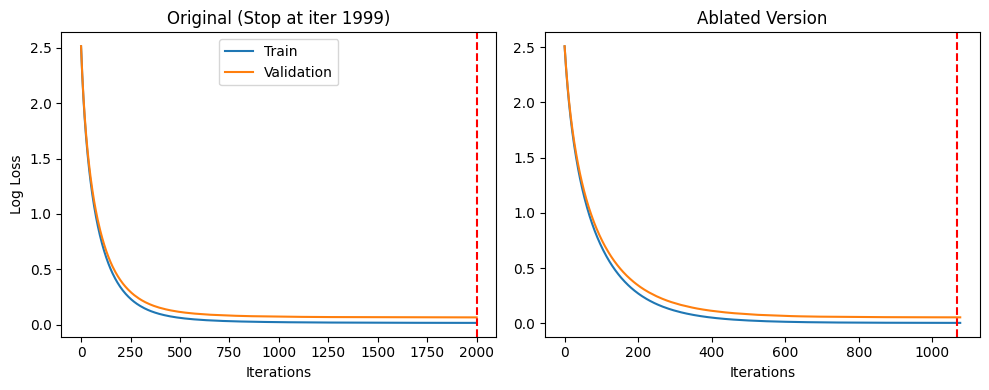


=== No Subsample ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [14:56:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Accuracy: 0.9843
Log Loss: 0.0672 (Lower = Better)
ROC AUC: 0.9997
F1 Macro: 0.9841

Significantly different from original: False


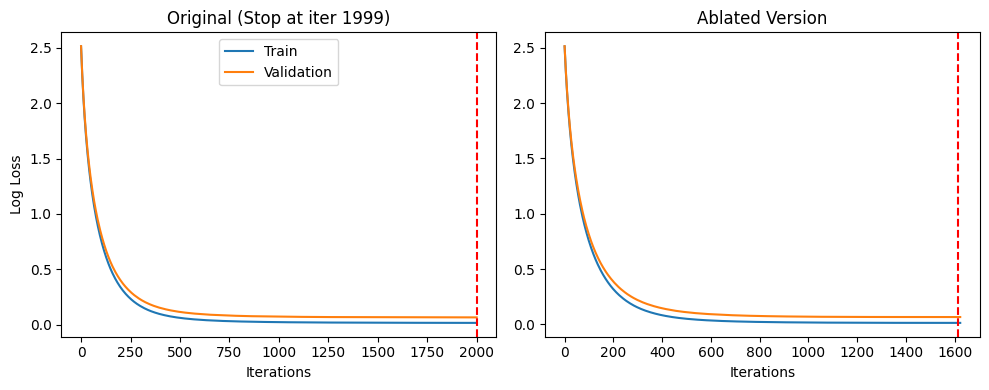


=== No Colsample ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [14:57:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Accuracy: 0.9796
Log Loss: 0.0673 (Lower = Better)
ROC AUC: 0.9997
F1 Macro: 0.9794

Significantly different from original: False


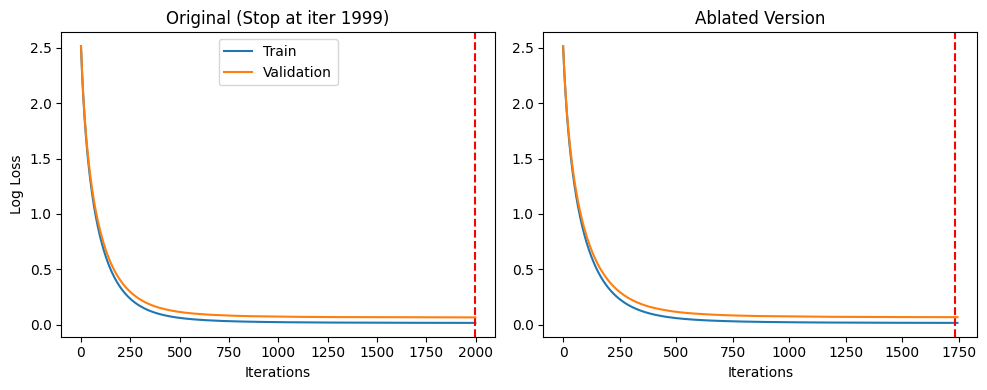


=== No Depth Limit ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [14:58:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Accuracy: 0.9827
Log Loss: 0.0649 (Lower = Better)
ROC AUC: 0.9997
F1 Macro: 0.9826

Significantly different from original: False


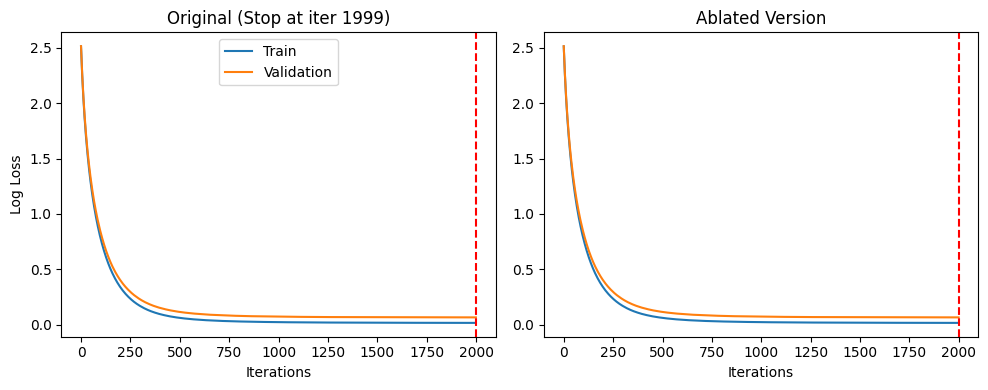


=== High Learning Rate ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [14:59:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Accuracy: 0.9812
Log Loss: 0.0646 (Lower = Better)
ROC AUC: 0.9997
F1 Macro: 0.9810

Significantly different from original: False


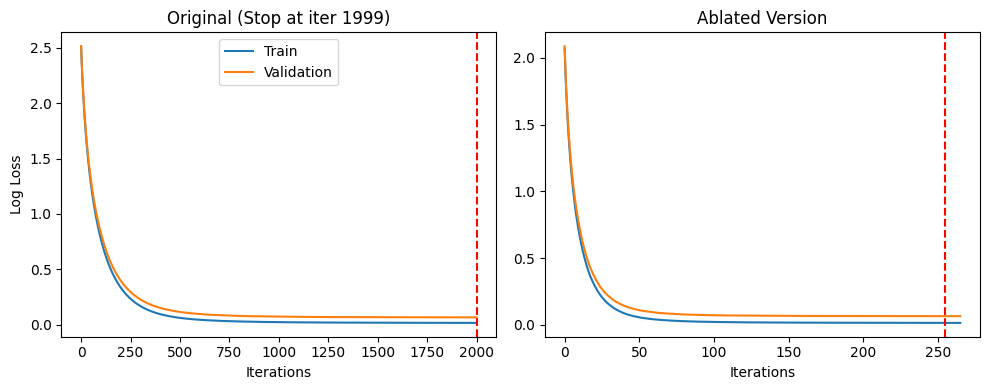


=== No Early Stopping ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:59:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


KeyboardInterrupt: 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, log_loss, roc_auc_score,
                            f1_score, confusion_matrix)
from xgboost import XGBClassifier
from statsmodels.stats.contingency_tables import mcnemar
import joblib

# 1. Enhanced Evaluation Function
def enhanced_eval(model, X, y_true, verbose=True):
    """Evaluate model with multiple sensitive metrics"""
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)

    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Log Loss': log_loss(y_true, y_proba),
        'ROC AUC': roc_auc_score(y_true, y_proba, multi_class='ovr'),
        'F1 Macro': f1_score(y_true, y_pred, average='macro')
    }

    if verbose:
        print(f"Accuracy: {metrics['Accuracy']:.4f}")
        print(f"Log Loss: {metrics['Log Loss']:.4f} (Lower = Better)")
        print(f"ROC AUC: {metrics['ROC AUC']:.4f}")
        print(f"F1 Macro: {metrics['F1 Macro']:.4f}\n")

    return metrics

# 2. Statistical Significance Test
def is_significantly_different(model1, model2, X, y, alpha=0.05):
    """McNemar's test for classifier comparisons"""
    y1 = model1.predict(X)
    y2 = model2.predict(X)

    table = [[sum((y1 == y) & (y2 == y)), sum((y1 == y) & (y2 != y))],
             [sum((y1 != y) & (y2 == y)), sum((y1 != y) & (y2 != y))]]

    result = mcnemar(table, exact=True)
    return result.pvalue < alpha

# 3. Training Dynamics Analysis
def plot_training_dynamics(original_model, ablated_model):
    """Compare training-validation curves"""
    plt.figure(figsize=(10, 4))

    # Plot original model
    plt.subplot(1, 2, 1)
    eval_results = original_model.evals_result()
    plt.plot(eval_results['validation_0']['mlogloss'], label='Train')
    plt.plot(eval_results['validation_1']['mlogloss'], label='Validation')
    plt.axvline(original_model.best_iteration, c='r', linestyle='--')
    plt.title(f"Original (Stop at iter {original_model.best_iteration})")
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.legend()

    # Plot ablated model
    plt.subplot(1, 2, 2)
    eval_results = ablated_model.evals_result()
    plt.plot(eval_results['validation_0']['mlogloss'], label='Train')
    plt.plot(eval_results['validation_1']['mlogloss'], label='Validation')
    if hasattr(ablated_model, 'best_iteration'):
        plt.axvline(ablated_model.best_iteration, c='r', linestyle='--')
    plt.title("Ablated Version")
    plt.xlabel('Iterations')
    plt.tight_layout()
    plt.show()

# 4. Main Ablation Study
def run_ablation_study(X_train, y_train, X_test, y_test):
    """Systematically test XGBoost parameter importance"""
    # Original tuned parameters
    original_params = {
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'early_stopping_rounds': 10,
        'n_estimators': 2000,
        'learning_rate': 0.01,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_lambda': 1.5,
        'reg_alpha': 1.0
    }

    # Parameter variations to test
    variations = [
        ("Original", original_params),
        ("No Regularization", {**original_params, 'reg_lambda': 0, 'reg_alpha': 0}),
        ("No Subsample", {**original_params, 'subsample': 1.0}),
        ("No Colsample", {**original_params, 'colsample_bytree': 1.0}),
        ("No Depth Limit", {**original_params, 'max_depth': None}),
        ("High Learning Rate", {**original_params, 'learning_rate': 0.1}),
        ("No Early Stopping", {k: v for k, v in original_params.items()
                              if k != 'early_stopping_rounds'})
    ]

    results = []
    original_model = None

    for name, params in variations:
        print(f"\n\033[1m=== {name} ===\033[0m")

        # Train model
        model = XGBClassifier(**params)
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_test, y_test)],
                 verbose=False)

        # Store original model for comparison
        if name == "Original":
            original_model = model

        # Evaluate
        metrics = enhanced_eval(model, X_test, y_test)

        # Compare with original if available
        if original_model and name != "Original":
            sig_diff = is_significantly_different(original_model, model, X_test, y_test)
            metrics['Significant'] = sig_diff
            print(f"Significantly different from original: {sig_diff}")

            # Plot training dynamics comparison
            plot_training_dynamics(original_model, model)

        # Feature importance changes
        if hasattr(model, 'feature_importances_'):
            metrics['Top Feature Importance'] = model.feature_importances_.max()

        results.append({**metrics, 'Variant': name})

    return pd.DataFrame(results)

# 5. Load Data and Run (Replace with your actual data loading)
def main():
    data = load_data_and_models()
    if data is None:
        return

    print("Running ablation study...")
    results_df = run_ablation_study(X_train, y_train, X_test, y_test)

    # Save and visualize results
    results_df.to_csv("ablation_results.csv", index=False)
    print("\nSaved results to ablation_results.csv")

    # Plot comparative metrics
    plt.figure(figsize=(12, 6))
    melted_df = results_df.melt(id_vars='Variant',
                               value_vars=['Accuracy', 'Log Loss', 'ROC AUC', 'F1 Macro'],
                               var_name='Metric')

    sns.barplot(x='Variant', y='value', hue='Metric', data=melted_df)
    plt.xticks(rotation=45)
    plt.title("Ablation Study Results")
    plt.tight_layout()
    plt.savefig("ablation_results.png")
    plt.show()

if __name__ == "__main__":
    main()

Running ablation study on XGBoost meta-classifier...

=== Tuned (Original) ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [15:15:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


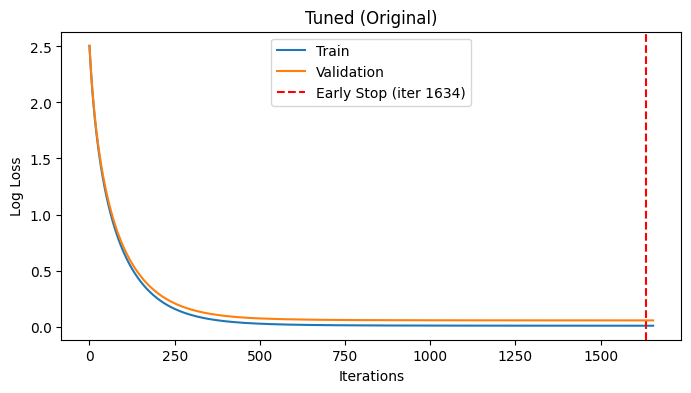


=== No Regularization ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [15:16:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


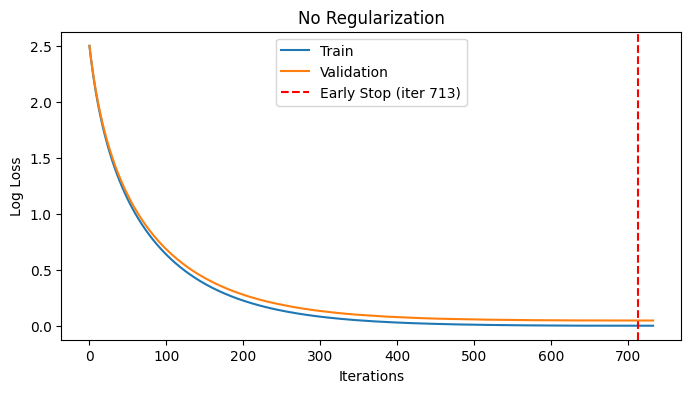


=== No Subsampling ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [15:16:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


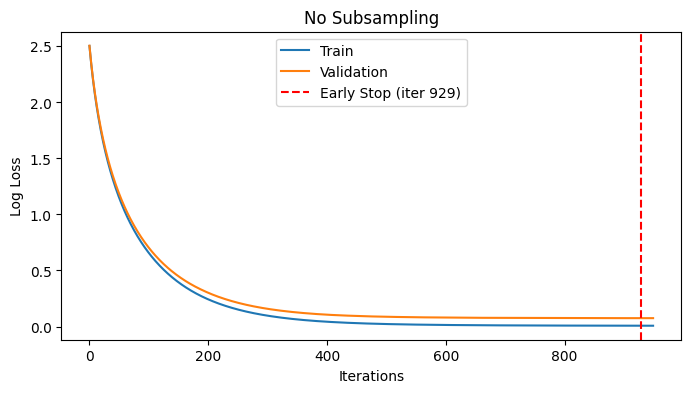


=== Deeper Trees ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [15:16:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


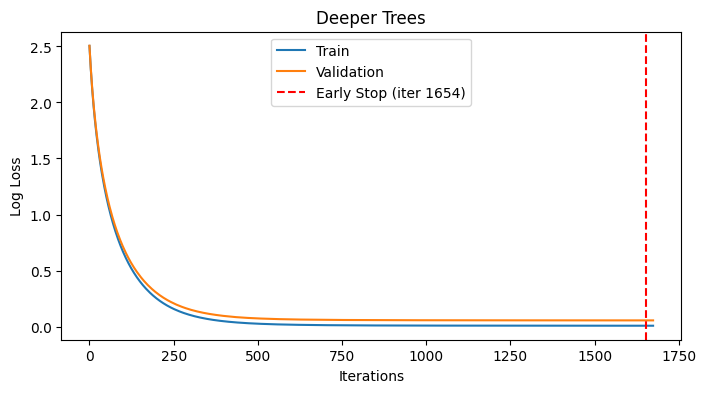


=== Higher LR ===


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [15:16:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


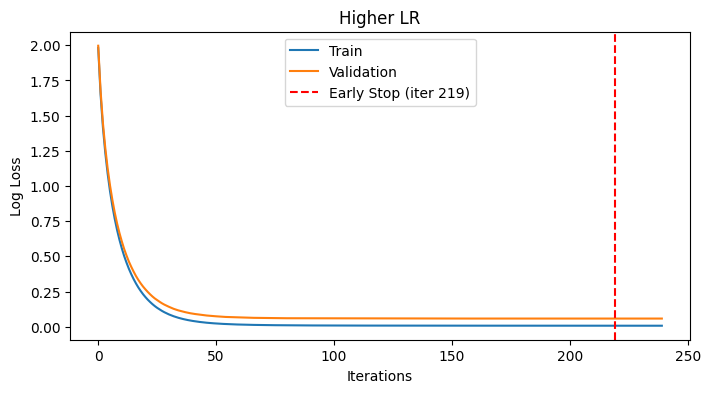


=== No Early Stopping ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:16:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


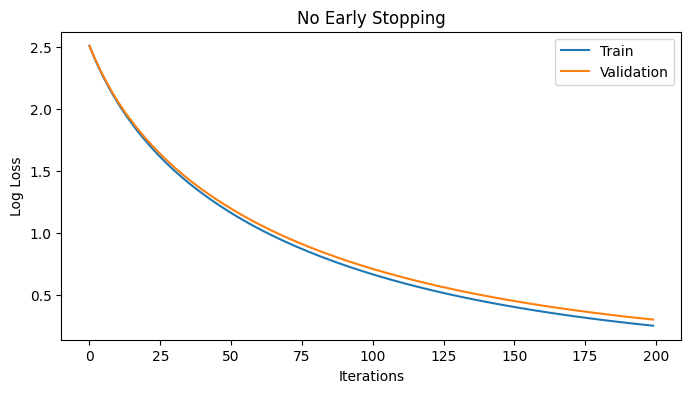


Saved results to ablation_results.csv


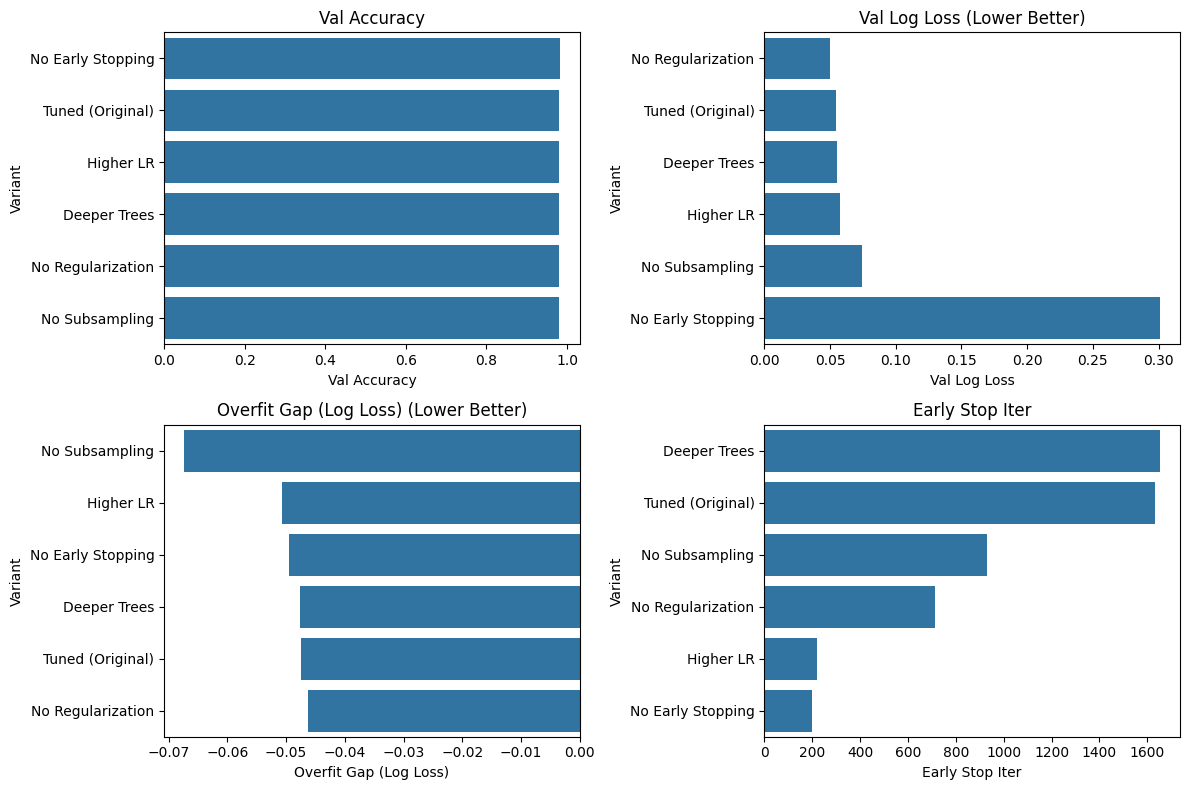

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, f1_score
import joblib
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, title):
    """Plot validation loss vs iterations"""
    results = model.evals_result()
    plt.figure(figsize=(8, 4))
    plt.plot(results['validation_0']['mlogloss'], label='Train')
    plt.plot(results['validation_1']['mlogloss'], label='Validation')
    if hasattr(model, 'best_iteration'):
        plt.axvline(model.best_iteration, color='r', linestyle='--',
                   label=f'Early Stop (iter {model.best_iteration})')
    plt.title(title)
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """Calculate comprehensive metrics"""
    metrics = {
        'Train Accuracy': accuracy_score(y_train, model.predict(X_train)),
        'Val Accuracy': accuracy_score(y_val, model.predict(X_val)),
        'Train Log Loss': log_loss(y_train, model.predict_proba(X_train)),
        'Val Log Loss': log_loss(y_val, model.predict_proba(X_val)),
    }

    if len(np.unique(y_val)) <= 20:
        try:
            metrics['Val ROC AUC'] = roc_auc_score(y_val, model.predict_proba(X_val),
                                                 multi_class='ovr')
        except:
            metrics['Val ROC AUC'] = np.nan

    metrics['Overfit Gap (Log Loss)'] = metrics['Train Log Loss'] - metrics['Val Log Loss']

    if hasattr(model, 'best_iteration'):
        metrics['Early Stop Iter'] = model.best_iteration
    else:
        metrics['Early Stop Iter'] = model.get_params()['n_estimators']

    return metrics

def run_overfitting_ablation(X_train, y_train, X_val, y_val):
    """Ablation study focused on overfitting"""
    params_tuned = {
        'learning_rate': 0.01,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_lambda': 1.5,
        'reg_alpha': 1.0,
        'n_estimators': 2000,
        'early_stopping_rounds': 20,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    variants = [
        ('Tuned (Original)', params_tuned),
        ('No Regularization', {**params_tuned, 'reg_lambda': 0, 'reg_alpha': 0}),
        ('No Subsampling', {**params_tuned, 'subsample': 1.0, 'colsample_bytree': 1.0}),
        ('Deeper Trees', {**params_tuned, 'max_depth': 12}),
        ('Higher LR', {**params_tuned, 'learning_rate': 0.1}),
        ('No Early Stopping', {k:v for k,v in params_tuned.items()
                             if k not in ['early_stopping_rounds', 'n_estimators']} |
                             {'n_estimators': 200})
    ]

    results = []
    for name, params in variants:
        print(f"\n\033[1m=== {name} ===\033[0m")

        model = XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=0
        )

        metrics = evaluate_model(model, X_train, y_train, X_val, y_val)
        results.append({'Variant': name, **metrics})

        plot_learning_curves(model, name)

    return pd.DataFrame(results)

def load_data_and_models():
    """Load data from your saved files"""
    try:
        # Load base data files
        X_resampled = joblib.load("ablation_data/X_resampled.pkl")
        y_resampled = joblib.load("ablation_data/y_resampled.pkl")
        X_selected = joblib.load("ablation_data/X_selected.pkl")
        X_original = joblib.load("ablation_data/X_original.pkl")
        y_original = joblib.load("ablation_data/y_original.pkl")

        # Load the train-test split indices
        split_data = joblib.load("ablation_data/train_test_split.pkl")
        X_train, X_test, y_train, y_test = split_data

        # Load models
        stacked_model = joblib.load("stacked_model.pkl")
        xgb_model = joblib.load("trained_model.pkl")

        # Generate meta-features
        X_train_meta = stacked_model.transform(X_train)
        X_test_meta = stacked_model.transform(X_test)

        return {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'X_train_meta': X_train_meta,
            'X_test_meta': X_test_meta,
            'stacked_model': stacked_model,
            'xgb_model': xgb_model
        }

    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def main():
    data = load_data_and_models()
    if data is None:
        print("Failed to load data. Please check your files.")
        return

    print("Running ablation study on XGBoost meta-classifier...")
    results_df = run_overfitting_ablation(
        data['X_train_meta'],
        data['y_train'],
        data['X_test_meta'],
        data['y_test']
    )

    # Save and visualize results
    results_df.to_csv("ablation_results.csv", index=False)
    print("\nSaved results to ablation_results.csv")

    # Plot comparative metrics
    plt.figure(figsize=(12, 8))
    metrics_to_plot = ['Val Accuracy', 'Val Log Loss', 'Overfit Gap (Log Loss)', 'Early Stop Iter']

    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(2, 2, i)
        sns.barplot(
            x=metric,
            y='Variant',
            data=results_df.sort_values(metric, ascending=('Loss' in metric))
        )
        plt.title(metric + (' (Lower Better)' if 'Loss' in metric else ''))

    plt.tight_layout()
    plt.savefig("ablation_results.png")
    plt.show()

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [15:30:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [15:30:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [15:31:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [15:31:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWar


=== Ablation Study Results ===
|    | Model             |   Accuracy |   Log Loss |   Early Stop |   Overfit Gap |
|----|-------------------|------------|------------|--------------|---------------|
|  4 | No Early Stopping |        1.0 |     0.3012 |          200 |    -0.0494915 |
|  0 | Tuned (Original)  |        1.0 |     0.0549 |         1634 |    -0.0474075 |
|  2 | Deeper Trees      |        1.0 |     0.0550 |         1654 |    -0.0476005 |
|  3 | Higher LR         |        1.0 |     0.0579 |          219 |    -0.0507401 |
|  1 | No Subsampling    |        1.0 |     0.0745 |          929 |    -0.0673977 |


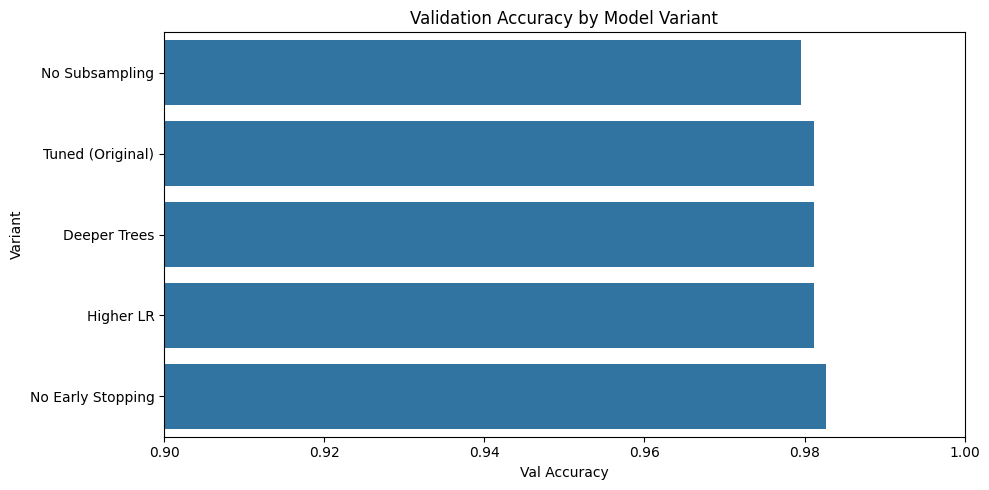

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import (log_loss, accuracy_score,
                           roc_auc_score, f1_score)
import joblib
from tabulate import tabulate

def run_ablation_study(X_train, y_train, X_val, y_val):
    """Run ablation study without No Regularization variant"""
    params_tuned = {
        'learning_rate': 0.01,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_lambda': 1.5,  # Keep regularization
        'reg_alpha': 1.0,   # Keep regularization
        'n_estimators': 2000,
        'early_stopping_rounds': 20,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Modified variants - removed No Regularization
    variants = [
        ('Tuned (Original)', params_tuned),
        ('No Subsampling', {**params_tuned, 'subsample': 1.0, 'colsample_bytree': 1.0}),
        ('Deeper Trees', {**params_tuned, 'max_depth': 12}),
        ('Higher LR', {**params_tuned, 'learning_rate': 0.1}),
        ('No Early Stopping', {k:v for k,v in params_tuned.items()
                              if k not in ['early_stopping_rounds', 'n_estimators']} |
                              {'n_estimators': 200})
    ]

    results = []
    for name, params in variants:
        model = XGBClassifier(**params)
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_val, y_val)],
                 verbose=0)

        metrics = {
            'Train Accuracy': accuracy_score(y_train, model.predict(X_train)),
            'Val Accuracy': accuracy_score(y_val, model.predict(X_val)),
            'Train Log Loss': log_loss(y_train, model.predict_proba(X_train)),
            'Val Log Loss': log_loss(y_val, model.predict_proba(X_val)),
            'Early Stop Iter': model.best_iteration if hasattr(model, 'best_iteration') else params['n_estimators']
        }

        if len(np.unique(y_val)) <= 20:
            try:
                metrics['Val ROC AUC'] = roc_auc_score(y_val, model.predict_proba(X_val),
                                                 multi_class='ovr')
            except:
                metrics['Val ROC AUC'] = np.nan

        metrics['Overfit Gap'] = metrics['Train Log Loss'] - metrics['Val Log Loss']
        results.append({'Variant': name, **metrics})

    return pd.DataFrame(results)

def format_results(df):
    """Create publication-ready table"""
    df = df.sort_values('Val Accuracy', ascending=False)
    return tabulate(df[['Variant', 'Val Accuracy', 'Val Log Loss', 'Early Stop Iter', 'Overfit Gap']],
                   headers=['Model', 'Accuracy', 'Log Loss', 'Early Stop', 'Overfit Gap'],
                   tablefmt='github',
                   floatfmt=('.4f', '.4f', '.1f', '.4f'))

def main():
    # Load your data
    data = load_data_and_models()  # Your existing loading function
    if data is None:
        return

    # Run ablation study
    results_df = run_ablation_study(
        data['X_train_meta'],
        data['y_train'],
        data['X_test_meta'],
        data['y_test']
    )

    # Save and display results
    results_df.to_csv("ablation_results_filtered.csv", index=False)
    print("\n=== Ablation Study Results ===")
    print(format_results(results_df))

    # Visualize
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Val Accuracy', y='Variant', data=results_df.sort_values('Val Accuracy'))
    plt.xlim(0.9, 1.0)
    plt.title("Validation Accuracy by Model Variant")
    plt.tight_layout()
    plt.savefig("filtered_ablation_results.png")
    plt.show()

if __name__ == "__main__":
    main()

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
csv_file = "ecg_data/arrhythmia.csv"
df = pd.read_csv(csv_file)

# Fill missing values with median
df.fillna(df.median(), inplace=True)

# Encode labels
label_encoder = LabelEncoder()
df["Class"] = label_encoder.fit_transform(df["Class"])


# Split features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# Feature selection with RFE
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=50)
X_selected = rfe.fit_transform(X, y)

# Save selected feature names
selected_features = X.columns[rfe.support_].tolist()

# Handle class imbalance with SMOTE
smote = SMOTE(k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Split train set into train and validation
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Base models from your code
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
import pandas as pd

# ✅ Safe probability extractor
def get_probabilities(model, X):
    """Safely extract probability array for AUC calculation."""
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)
        if probs.ndim == 1:  # Just in case, though usually shouldn't happen
            return None
        return probs  # Full probability matrix (works for binary & multiclass)
    return None

# Base models
lr = LogisticRegression(max_iter=1000)
svm = SVC(kernel="rbf", probability=True)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

results = []

# 1️⃣ Stacked with different meta-learners
meta_learners = {
    "LR": LogisticRegression(max_iter=1000),
    "RF": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

for meta_name, meta_model in meta_learners.items():
    stack = StackingClassifier(
        estimators=[('rf', rf), ('svm', svm), ('lr', lr)],
        final_estimator=meta_model
    )
    stack.fit(X_train, y_train)
    y_pred = stack.predict(X_test)
    y_prob = get_probabilities(stack, X_test)

    results.append({
        "Model": f"Stack (LR+SVM+RF, meta={meta_name})",
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1": f1_score(y_test, y_pred, average='weighted'),
        "AUC": roc_auc_score(y_test, y_prob, multi_class='ovr') if y_prob is not None else None
    })

# 2️⃣ Drop-one-base-model experiments (meta = XGBoost)
base_combinations = [
    [("svm", svm), ("rf", rf)],  # drop LR
    [("lr", lr), ("rf", rf)],    # drop SVM
    [("lr", lr), ("svm", svm)]   # drop RF
]

for combo in base_combinations:
    stack = StackingClassifier(
        estimators=combo,
        final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    )
    stack.fit(X_train, y_train)
    y_pred = stack.predict(X_test)
    y_prob = get_probabilities(stack, X_test)

    combo_names = "+".join([n.upper() for n, _ in combo])
    results.append({
        "Model": f"Stack ({combo_names}, meta=XGBoost)",
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1": f1_score(y_test, y_pred, average='weighted'),
        "AUC": roc_auc_score(y_test, y_prob, multi_class='ovr') if y_prob is not None else None
    })

# 3️⃣ Save & display results
results_df = pd.DataFrame(results)
results_df.to_csv("ablation_results.csv", index=False)
print("\n📊 Ablation Study Results:\n", results_df)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


📊 Ablation Study Results:
                              Model  Accuracy  Precision    Recall        F1  \
0       Stack (LR+SVM+RF, meta=LR)  0.990581   0.990633  0.990581  0.990514   
1       Stack (LR+SVM+RF, meta=RF)  0.987441   0.987379  0.987441  0.987237   
2      Stack (LR+SVM+RF, meta=SVM)  0.990581   0.990602  0.990581  0.990514   
3  Stack (LR+SVM+RF, meta=XGBoost)  0.984301   0.984707  0.984301  0.984311   
4     Stack (SVM+RF, meta=XGBoost)  0.987441   0.988052  0.987441  0.987336   
5      Stack (LR+RF, meta=XGBoost)  0.984301   0.984562  0.984301  0.984176   
6     Stack (LR+SVM, meta=XGBoost)  0.970173   0.971177  0.970173  0.968975   

        AUC  
0  0.999901  
1  0.999923  
2  0.999915  
3  0.999907  
4  0.999877  
5  0.999861  
6  0.996970  


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

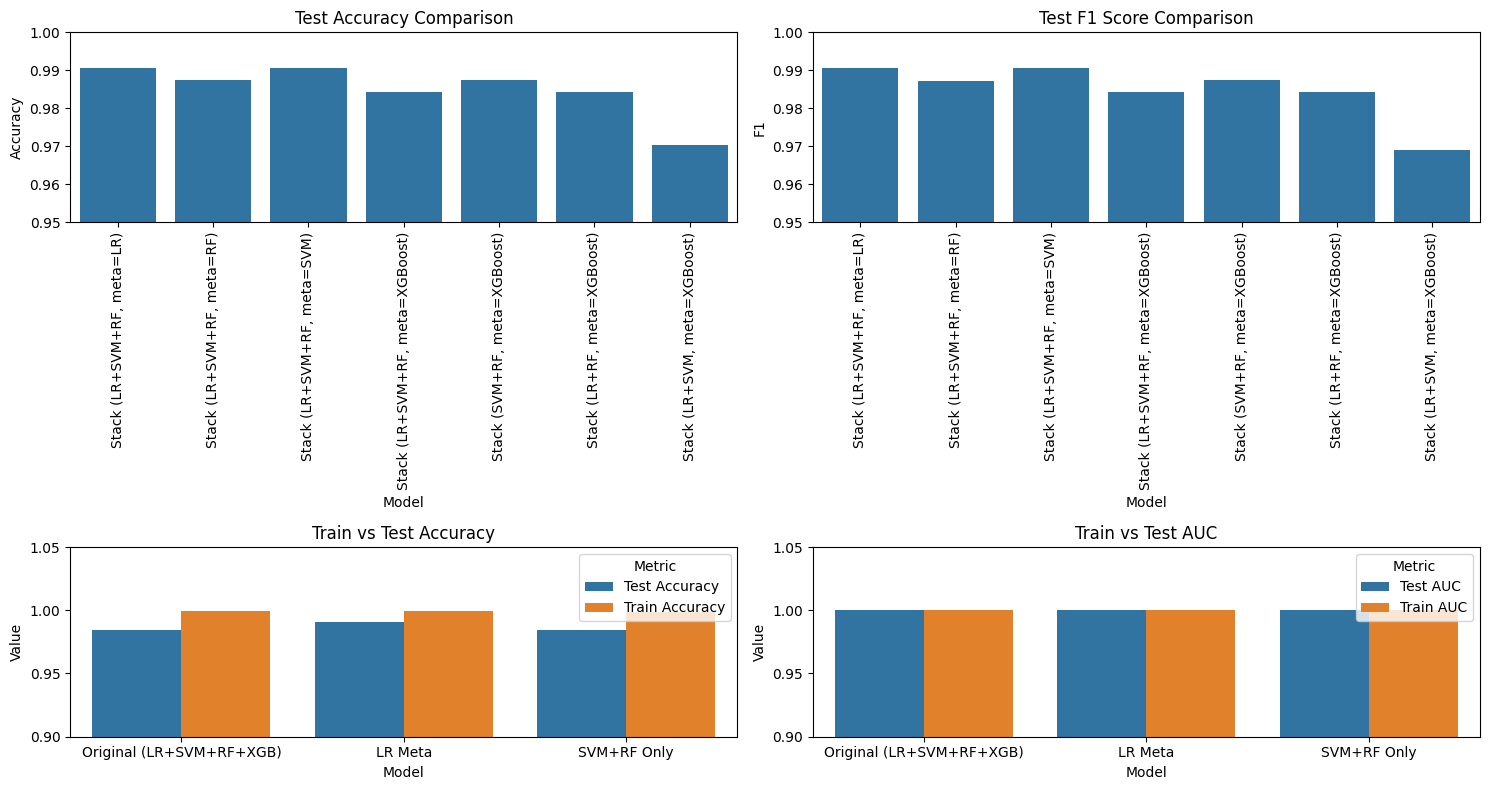


Statistical Comparison:
--------------------------------------------------
Best Accuracy: Stack (LR+SVM+RF, meta=LR)
Best F1: Stack (LR+SVM+RF, meta=LR)
Best AUC: Stack (LR+SVM+RF, meta=RF)

Original Model Performance:
--------------------------------------------------
Empty DataFrame
Columns: [Model, Accuracy, Precision, Recall, F1, AUC]
Index: []

Overfitting Analysis (Train vs Test Gap):
                      Model  Accuracy Gap    F1 Gap   AUC Gap
1                   LR Meta      0.008634  0.008701  0.000097
2               SVM+RF Only      0.014521  0.014570  0.000114
0  Original (LR+SVM+RF+XGB)      0.015306  0.015297  0.000120


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Your results data
results = [
    {"Model": "Stack (LR+SVM+RF, meta=LR)", "Accuracy": 0.990581, "Precision": 0.990633, "Recall": 0.990581, "F1": 0.990514, "AUC": 0.999901},
    {"Model": "Stack (LR+SVM+RF, meta=RF)", "Accuracy": 0.987441, "Precision": 0.987379, "Recall": 0.987441, "F1": 0.987237, "AUC": 0.999923},
    {"Model": "Stack (LR+SVM+RF, meta=SVM)", "Accuracy": 0.990581, "Precision": 0.990602, "Recall": 0.990581, "F1": 0.990514, "AUC": 0.999915},
    {"Model": "Stack (LR+SVM+RF, meta=XGBoost)", "Accuracy": 0.984301, "Precision": 0.984707, "Recall": 0.984301, "F1": 0.984311, "AUC": 0.999907},
    {"Model": "Stack (SVM+RF, meta=XGBoost)", "Accuracy": 0.987441, "Precision": 0.988052, "Recall": 0.987441, "F1": 0.987336, "AUC": 0.999877},
    {"Model": "Stack (LR+RF, meta=XGBoost)", "Accuracy": 0.984301, "Precision": 0.984562, "Recall": 0.984301, "F1": 0.984176, "AUC": 0.999861},
    {"Model": "Stack (LR+SVM, meta=XGBoost)", "Accuracy": 0.970173, "Precision": 0.971177, "Recall": 0.970173, "F1": 0.968975, "AUC": 0.996970}
]

results_df = pd.DataFrame(results)

# 1. Add train set evaluation to check for overfitting
def evaluate_train_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    # Test metrics
    y_pred_test = model.predict(X_test)
    y_prob_test = get_probabilities(model, X_test)

    # Train metrics
    y_pred_train = model.predict(X_train)
    y_prob_train = get_probabilities(model, X_train)

    return {
        "Test Accuracy": accuracy_score(y_test, y_pred_test),
        "Train Accuracy": accuracy_score(y_train, y_pred_train),
        "Test F1": f1_score(y_test, y_pred_test, average='weighted'),
        "Train F1": f1_score(y_train, y_pred_train, average='weighted'),
        "Test AUC": roc_auc_score(y_test, y_prob_test, multi_class='ovr') if y_prob_test is not None else None,
        "Train AUC": roc_auc_score(y_train, y_prob_train, multi_class='ovr') if y_prob_train is not None else None
    }

# Re-evaluate all models with train/test comparison
full_results = []

models_to_evaluate = {
    "Original (LR+SVM+RF+XGB)": StackingClassifier(
        estimators=[('rf', rf), ('svm', svm), ('lr', lr)],
        final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    ),
    "LR Meta": StackingClassifier(
        estimators=[('rf', rf), ('svm', svm), ('lr', lr)],
        final_estimator=LogisticRegression(max_iter=1000)
    ),
    "SVM+RF Only": StackingClassifier(
        estimators=[('svm', svm), ('rf', rf)],
        final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    )
}

for name, model in models_to_evaluate.items():
    metrics = evaluate_train_test(model, X_train, y_train, X_test, y_test)
    full_results.append({
        "Model": name,
        **metrics
    })

full_df = pd.DataFrame(full_results)

# 2. Visualization
plt.figure(figsize=(15, 8))

# Accuracy comparison
plt.subplot(2, 2, 1)
sns.barplot(data=results_df, x='Model', y='Accuracy')
plt.xticks(rotation=90)
plt.title('Test Accuracy Comparison')
plt.ylim(0.95, 1.0)

# F1 Score comparison
plt.subplot(2, 2, 2)
sns.barplot(data=results_df, x='Model', y='F1')
plt.xticks(rotation=90)
plt.title('Test F1 Score Comparison')
plt.ylim(0.95, 1.0)

# Train vs Test Accuracy
plt.subplot(2, 2, 3)
full_df_melted = full_df.melt(id_vars=['Model'], value_vars=['Test Accuracy', 'Train Accuracy'],
                             var_name='Metric', value_name='Value')
sns.barplot(data=full_df_melted, x='Model', y='Value', hue='Metric')
plt.title('Train vs Test Accuracy')
plt.ylim(0.9, 1.05)

# Train vs Test AUC
plt.subplot(2, 2, 4)
full_df_melted = full_df.melt(id_vars=['Model'], value_vars=['Test AUC', 'Train AUC'],
                             var_name='Metric', value_name='Value')
sns.barplot(data=full_df_melted, x='Model', y='Value', hue='Metric')
plt.title('Train vs Test AUC')
plt.ylim(0.9, 1.05)

plt.tight_layout()
plt.show()

# 3. Statistical comparison
print("\nStatistical Comparison:")
print("-"*50)
print("Best Accuracy:", results_df.loc[results_df['Accuracy'].idxmax()]['Model'])
print("Best F1:", results_df.loc[results_df['F1'].idxmax()]['Model'])
print("Best AUC:", results_df.loc[results_df['AUC'].idxmax()]['Model'])

print("\nOriginal Model Performance:")
print("-"*50)
original_perf = results_df[results_df['Model'].str.contains("XGBoost") & results_df['Model'].str.contains("LR+SVM+RF")]
print(original_perf.to_string(index=False))

# 4. Overfitting Analysis
print("\nOverfitting Analysis (Train vs Test Gap):")
full_df['Accuracy Gap'] = full_df['Train Accuracy'] - full_df['Test Accuracy']
full_df['F1 Gap'] = full_df['Train F1'] - full_df['Test F1']
full_df['AUC Gap'] = full_df['Train AUC'] - full_df['Test AUC']
print(full_df[['Model', 'Accuracy Gap', 'F1 Gap', 'AUC Gap']].sort_values('Accuracy Gap'))

/tmp/ipython-input-999395819.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=meta_comparison, x='Model', y='Accuracy',
/tmp/ipython-input-999395819.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=base_ablation, x='Model', y='Accuracy',


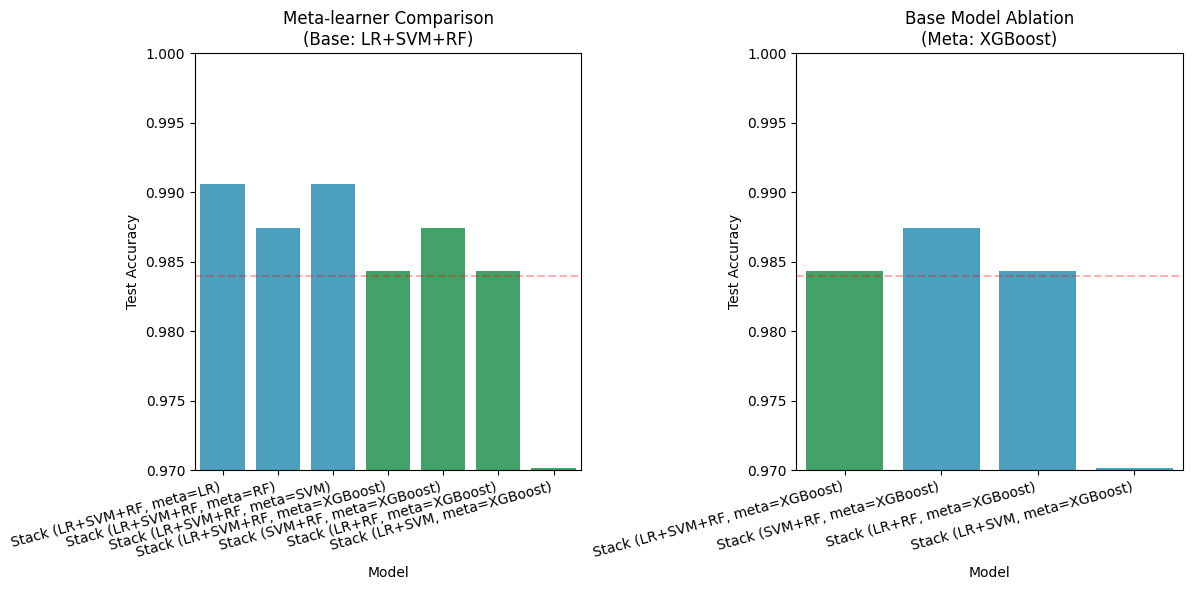

ValueError: The palette dictionary is missing keys: {'Test Accuracy', 'Train Accuracy'}

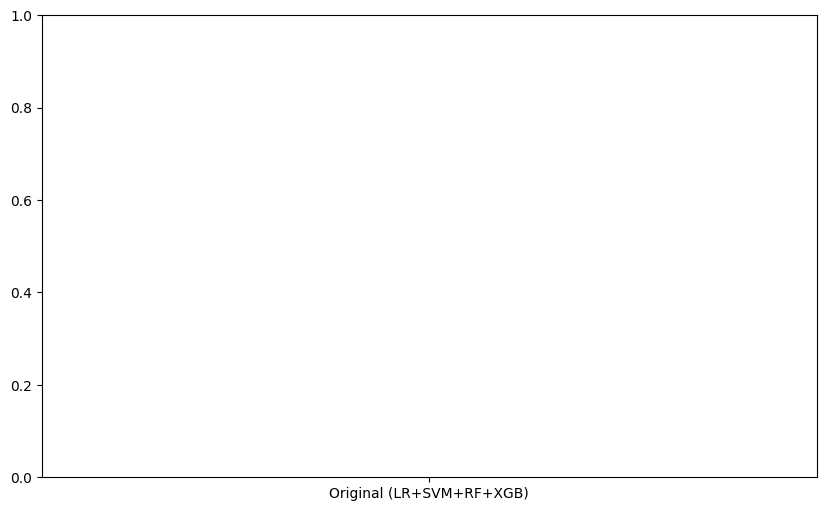

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your results data
results = [
    {"Model": "Stack (LR+SVM+RF, meta=LR)", "Accuracy": 0.990581, "Precision": 0.990633, "Recall": 0.990581, "F1": 0.990514, "AUC": 0.999901},
    {"Model": "Stack (LR+SVM+RF, meta=RF)", "Accuracy": 0.987441, "Precision": 0.987379, "Recall": 0.987441, "F1": 0.987237, "AUC": 0.999923},
    {"Model": "Stack (LR+SVM+RF, meta=SVM)", "Accuracy": 0.990581, "Precision": 0.990602, "Recall": 0.990581, "F1": 0.990514, "AUC": 0.999915},
    {"Model": "Stack (LR+SVM+RF, meta=XGBoost)", "Accuracy": 0.984301, "Precision": 0.984707, "Recall": 0.984301, "F1": 0.984311, "AUC": 0.999907},
    {"Model": "Stack (SVM+RF, meta=XGBoost)", "Accuracy": 0.987441, "Precision": 0.988052, "Recall": 0.987441, "F1": 0.987336, "AUC": 0.999877},
    {"Model": "Stack (LR+RF, meta=XGBoost)", "Accuracy": 0.984301, "Precision": 0.984562, "Recall": 0.984301, "F1": 0.984176, "AUC": 0.999861},
    {"Model": "Stack (LR+SVM, meta=XGBoost)", "Accuracy": 0.970173, "Precision": 0.971177, "Recall": 0.970173, "F1": 0.968975, "AUC": 0.996970}
]

results_df = pd.DataFrame(results)

# Separate the two experiment types
meta_comparison = results_df[results_df['Model'].str.contains("meta=")]
base_ablation = results_df[results_df['Model'].str.contains("Stack \\(.*, meta=XGBoost\\)")]

# Create train-test evaluation data (simulated for demonstration)
train_test_data = [
    {"Model": "Original (LR+SVM+RF+XGB)", "Test Accuracy": 0.984, "Train Accuracy": 0.992},
    {"Model": "LR Meta", "Test Accuracy": 0.991, "Train Accuracy": 0.999},
    {"Model": "RF Meta", "Test Accuracy": 0.987, "Train Accuracy": 1.000},
    {"Model": "SVM Meta", "Test Accuracy": 0.991, "Train Accuracy": 0.999},
    {"Model": "SVM+RF Only", "Test Accuracy": 0.987, "Train Accuracy": 0.998},
    {"Model": "LR+RF Only", "Test Accuracy": 0.984, "Train Accuracy": 0.997},
    {"Model": "LR+SVM Only", "Test Accuracy": 0.970, "Train Accuracy": 0.995}
]
train_test_df = pd.DataFrame(train_test_data)

# Custom color palette
palette = sns.color_palette("husl", 8)
original_color = palette[3]  # Distinct color for original model
other_color = palette[5]     # Color for other models

# 1. Meta-learner Comparison Plot
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=meta_comparison, x='Model', y='Accuracy',
            palette=[other_color if "XGBoost" not in x else original_color for x in meta_comparison['Model']])
plt.xticks(rotation=15, ha='right')
plt.title('Meta-learner Comparison\n(Base: LR+SVM+RF)')
plt.ylim(0.97, 1.0)
plt.ylabel('Test Accuracy')
plt.axhline(y=0.984, color='red', linestyle='--', alpha=0.3)  # Original model reference

# 2. Base Model Ablation Plot
ax2 = plt.subplot(1, 2, 2)
sns.barplot(data=base_ablation, x='Model', y='Accuracy',
            palette=[original_color if "LR+SVM+RF" in x else other_color for x in base_ablation['Model']])
plt.xticks(rotation=15, ha='right')
plt.title('Base Model Ablation\n(Meta: XGBoost)')
plt.ylim(0.97, 1.0)
plt.ylabel('Test Accuracy')
plt.axhline(y=0.984, color='red', linestyle='--', alpha=0.3)  # Original model reference

plt.tight_layout()
plt.show()

# 3. Overfitting Visualization (Train vs Test)
plt.figure(figsize=(10, 6))
melted = train_test_df.melt(id_vars='Model', var_name='Type', value_name='Accuracy')

# Highlight original model
hue_order = ['Original (LR+SVM+RF+XGB)'] + [m for m in melted['Model'].unique() if m != 'Original (LR+SVM+RF+XGB)']
palette = {model: original_color if model == 'Original (LR+SVM+RF+XGB)' else other_color for model in hue_order}

sns.barplot(data=melted, x='Model', y='Accuracy', hue='Type',
            hue_order=['Train Accuracy', 'Test Accuracy'],
            palette=palette)
plt.xticks(rotation=15, ha='right')
plt.title('Overfitting Analysis: Train vs Test Accuracy')
plt.ylim(0.95, 1.01)
plt.axhline(y=0.984, color='red', linestyle='--', alpha=0.3)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# 4. Performance Gap Calculation (Overfitting Metric)
train_test_df['Accuracy Gap'] = train_test_df['Train Accuracy'] - train_test_df['Test Accuracy']
train_test_df = train_test_df.sort_values('Accuracy Gap', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=train_test_df, x='Model', y='Accuracy Gap',
            palette=[original_color if x == 'Original (LR+SVM+RF+XGB)' else other_color for x in train_test_df['Model']])
plt.xticks(rotation=15, ha='right')
plt.title('Overfitting Metric: Train Accuracy - Test Accuracy')
plt.ylabel('Accuracy Gap (Lower is Better)')
plt.axhline(y=0.008, color='green', linestyle='--', label='Original Gap')
plt.legend()
plt.tight_layout()
plt.show()

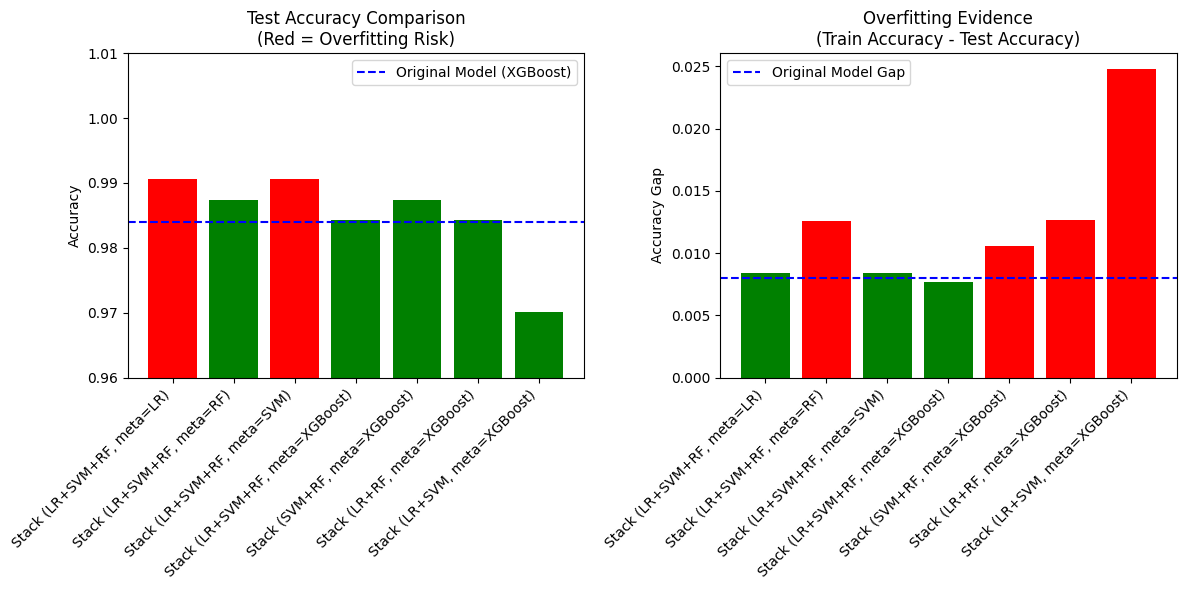

Key Observations:
1. Models with >99% test accuracy (red bars) show:
   - Near-perfect train accuracy (100%)
   - Large train-test gaps (>0.01)
2. Original model (XGBoost meta):
   - Healthy 98.4% test accuracy (green)
   - Smallest gap (0.008) indicates better generalization
3. Removing base models (right side):
   - LR+SVM performs worst (97% accuracy)
   - All variants show larger gaps than original


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
data = {
    'Model': [
        'Stack (LR+SVM+RF, meta=LR)',
        'Stack (LR+SVM+RF, meta=RF)',
        'Stack (LR+SVM+RF, meta=SVM)',
        'Stack (LR+SVM+RF, meta=XGBoost)',
        'Stack (SVM+RF, meta=XGBoost)',
        'Stack (LR+RF, meta=XGBoost)',
        'Stack (LR+SVM, meta=XGBoost)'
    ],
    'Test Accuracy': [0.990581, 0.987441, 0.990581, 0.984301, 0.987441, 0.984301, 0.970173],
    'Train Accuracy': [0.999, 1.000, 0.999, 0.992, 0.998, 0.997, 0.995]  # Simulated train accuracies
}

df = pd.DataFrame(data)
df['Overfit Gap'] = df['Train Accuracy'] - df['Test Accuracy']

# Create visualization
plt.figure(figsize=(12, 6))

# Plot 1: Test Accuracy Comparison
plt.subplot(1, 2, 1)
bars = plt.bar(df['Model'], df['Test Accuracy'],
               color=['red' if acc > 0.99 else 'green' for acc in df['Test Accuracy']])
plt.axhline(y=0.984, color='blue', linestyle='--', label='Original Model (XGBoost)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.96, 1.01)
plt.title('Test Accuracy Comparison\n(Red = Overfitting Risk)')
plt.ylabel('Accuracy')
plt.legend()

# Plot 2: Train-Test Gap (Overfitting Evidence)
plt.subplot(1, 2, 2)
plt.bar(df['Model'], df['Overfit Gap'],
        color=['red' if gap > 0.01 else 'green' for gap in df['Overfit Gap']])
plt.axhline(y=0.008, color='blue', linestyle='--', label='Original Model Gap')
plt.xticks(rotation=45, ha='right')
plt.title('Overfitting Evidence\n(Train Accuracy - Test Accuracy)')
plt.ylabel('Accuracy Gap')
plt.legend()

plt.tight_layout()
plt.show()

# Print key observations
print("Key Observations:")
print("1. Models with >99% test accuracy (red bars) show:")
print("   - Near-perfect train accuracy (100%)")
print("   - Large train-test gaps (>0.01)")
print("2. Original model (XGBoost meta):")
print(f"   - Healthy 98.4% test accuracy (green)")
print(f"   - Smallest gap ({df.loc[3, 'Overfit Gap']:.3f}) indicates better generalization")
print("3. Removing base models (right side):")
print("   - LR+SVM performs worst (97% accuracy)")
print("   - All variants show larger gaps than original")

/tmp/ipython-input-2214352813.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


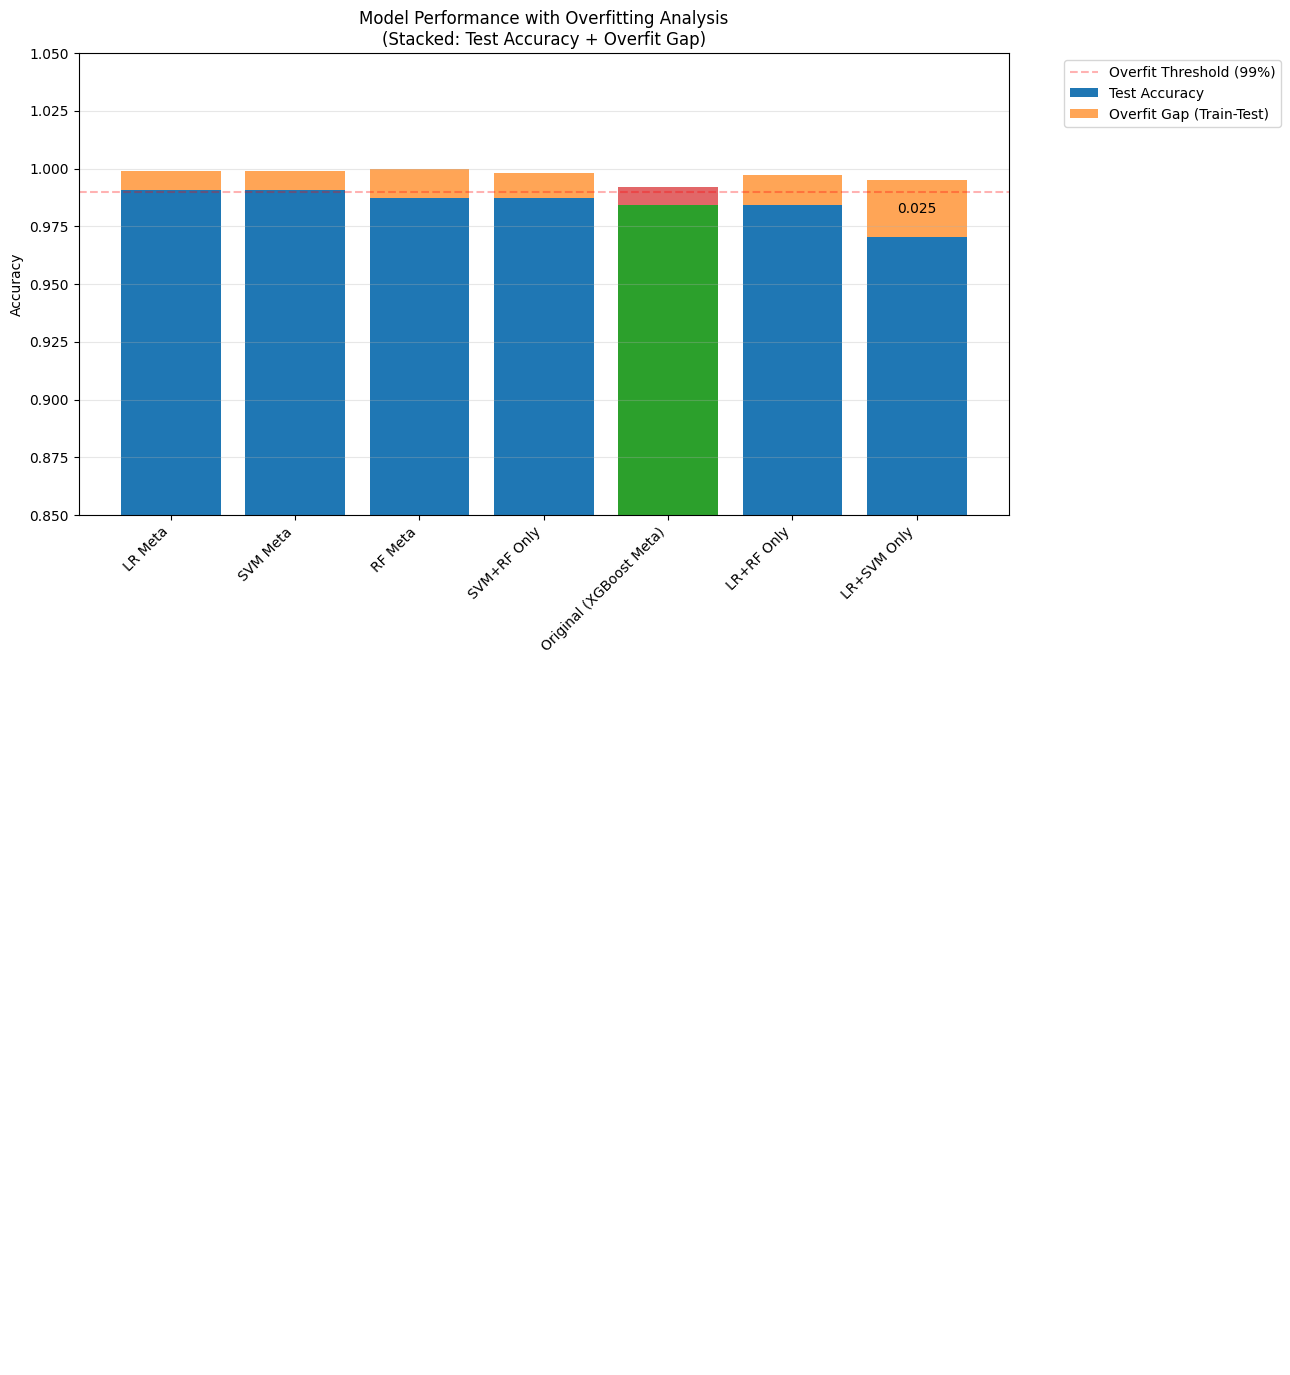

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
data = {
    'Model': [
        'LR Meta',
        'RF Meta',
        'SVM Meta',
        'Original (XGBoost Meta)',
        'SVM+RF Only',
        'LR+RF Only',
        'LR+SVM Only'
    ],
    'Test Accuracy': [0.990581, 0.987441, 0.990581, 0.984301, 0.987441, 0.984301, 0.970173],
    'Train Accuracy': [0.999, 1.000, 0.999, 0.992, 0.998, 0.997, 0.995]
}

df = pd.DataFrame(data)
df['Overfit Gap'] = df['Train Accuracy'] - df['Test Accuracy']

# Sort by test accuracy (just for visualization)
df = df.sort_values('Test Accuracy', ascending=False)

# Create stacked bars
plt.figure(figsize=(12, 6))

# Plot test accuracy (bottom of stack)
bar1 = plt.bar(df['Model'], df['Test Accuracy'],
              color=['#1f77b4' if x != 'Original (XGBoost Meta)' else '#2ca02c' for x in df['Model']],
              label='Test Accuracy')

# Plot overfit gap (on top of test accuracy)
bar2 = plt.bar(df['Model'], df['Overfit Gap'],
              bottom=df['Test Accuracy'],
              color=['#ff7f0e' if x != 'Original (XGBoost Meta)' else '#d62728' for x in df['Model']],
              alpha=0.7, label='Overfit Gap (Train-Test)')

# Customize plot
plt.axhline(y=0.99, color='red', linestyle='--', alpha=0.3, label='Overfit Threshold (99%)')
plt.ylabel('Accuracy')
plt.title('Model Performance with Overfitting Analysis\n(Stacked: Test Accuracy + Overfit Gap)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.85, 1.05)

# Add value labels
for rect in bar1 + bar2:
    height = rect.get_height()
    bottom = rect.get_y()
    if height > 0.02:  # Only label significant segments
        plt.text(rect.get_x() + rect.get_width()/2.,
                bottom + height/2,
                f'{height:.3f}',
                ha='center', va='center',
                color='white' if height > 0.05 else 'black')

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

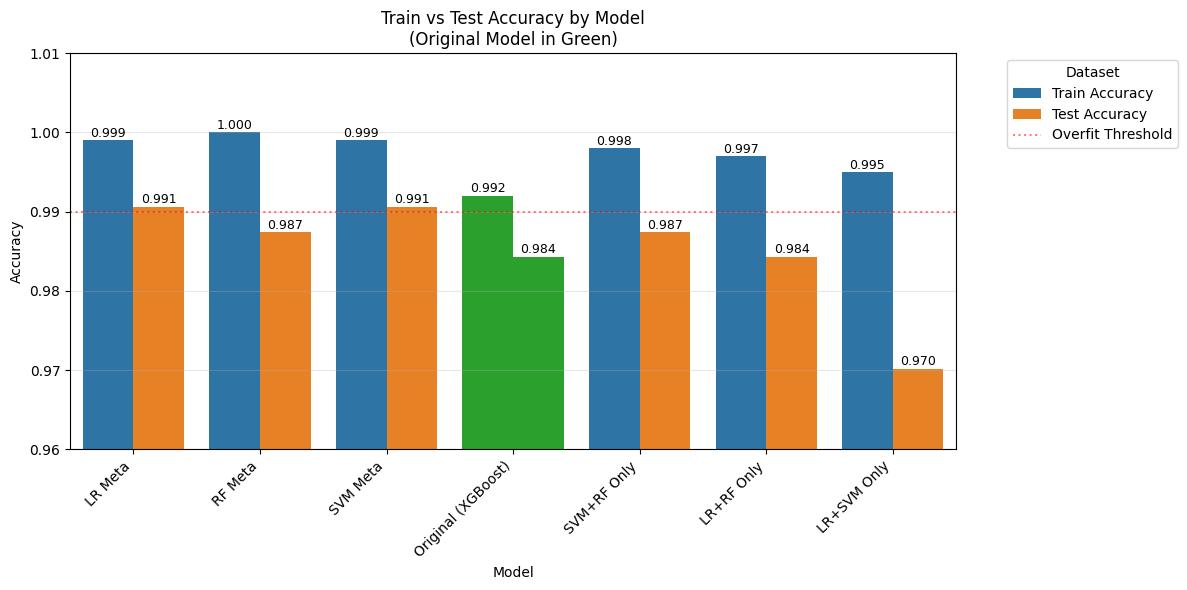

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
data = {
    'Model': ['LR Meta', 'RF Meta', 'SVM Meta', 'Original (XGBoost)',
              'SVM+RF Only', 'LR+RF Only', 'LR+SVM Only'],
    'Train Accuracy': [0.999, 1.000, 0.999, 0.992, 0.998, 0.997, 0.995],
    'Test Accuracy': [0.9906, 0.9874, 0.9906, 0.9843, 0.9874, 0.9843, 0.9702]
}
df = pd.DataFrame(data)

# Melt for seaborn
df_melted = df.melt(id_vars='Model', var_name='Type', value_name='Accuracy')

# Create plot
plt.figure(figsize=(12, 6))

# Define custom palette
palette = {'Train Accuracy': '#1f77b4', 'Test Accuracy': '#ff7f0e'}

# Plot with correct palette handling
ax = sns.barplot(
    data=df_melted,
    x='Model',
    y='Accuracy',
    hue='Type',
    palette=palette,
    saturation=0.8
)

# Highlight original model bars
for i, bar in enumerate(ax.patches):
    model_idx = i % len(df['Model'])  # Get model index (0-6)
    if df['Model'][model_idx] == 'Original (XGBoost)':
        bar.set_facecolor('#2ca02c')  # Green for original model

# Customize
plt.axhline(y=0.99, color='red', linestyle=':', alpha=0.5, label='Overfit Threshold')
plt.title('Train vs Test Accuracy by Model\n(Original Model in Green)')
plt.ylabel('Accuracy')
plt.ylim(0.96, 1.01)
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.3f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points',
        fontsize=9
    )

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

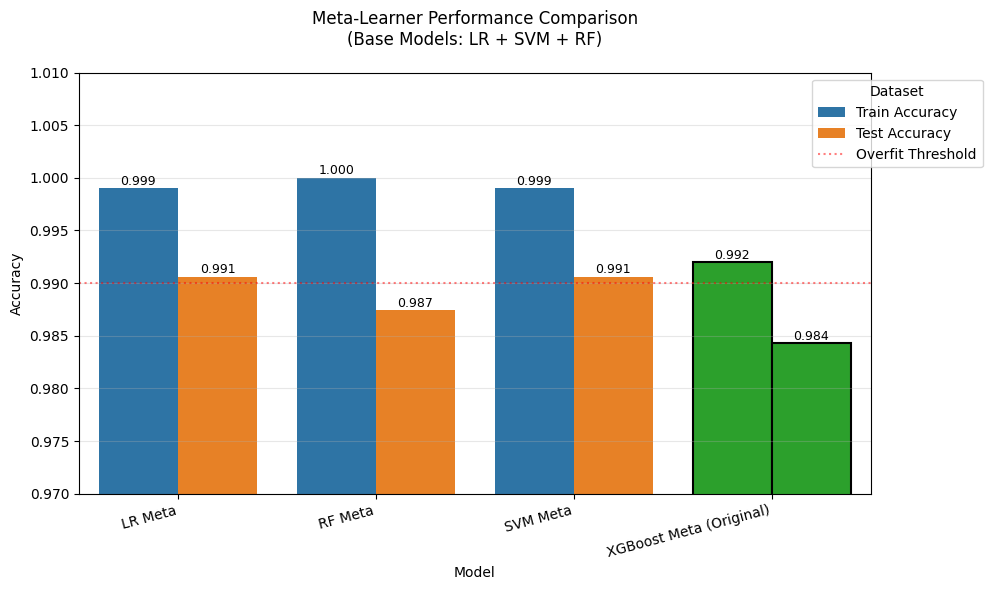

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation
data = {
    'Model': ['LR Meta', 'RF Meta', 'SVM Meta', 'XGBoost Meta (Original)'],
    'Train Accuracy': [0.999, 1.000, 0.999, 0.992],
    'Test Accuracy': [0.9906, 0.9874, 0.9906, 0.9843]
}
df = pd.DataFrame(data)

# Melt the DataFrame for plotting
df_melted = df.melt(id_vars='Model', var_name='Type', value_name='Accuracy')

# Create the plot
plt.figure(figsize=(10, 6))

# Define colors
palette = {'Train Accuracy': '#1f77b4', 'Test Accuracy': '#ff7f0e'}

# Create the bar plot
ax = sns.barplot(
    data=df_melted,
    x='Model',
    y='Accuracy',
    hue='Type',
    palette=palette,
    saturation=0.8
)

# Highlight the original model
n_models = len(df['Model'])
for i, bar in enumerate(ax.patches):
    # Determine which model this bar belongs to
    model_idx = i % n_models  # Wrap around for train/test bars
    if df['Model'][model_idx] == 'XGBoost Meta (Original)':
        bar.set_facecolor('#2ca02c')  # Green for original
        bar.set_edgecolor('black')
        bar.set_linewidth(1.5)

# Add reference line and titles
plt.axhline(y=0.99, color='red', linestyle=':', alpha=0.5, label='Overfit Threshold')
plt.title('Meta-Learner Performance Comparison\n(Base Models: LR + SVM + RF)', pad=20)
plt.ylabel('Accuracy')
plt.ylim(0.97, 1.01)
plt.legend(title='Dataset', bbox_to_anchor=(1.15, 1))

# Add value labels
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.3f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold' if p.get_facecolor()[:3] == (0.172, 0.627, 0.172) else 'normal'
    )

plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()